In [19]:
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import sys, os, glob, gc, re, linecache
sys.path.append('/Users/earnric/Google Drive/ASU/Codes/PythonCode/modules')
import numpy as np
from scipy.io import readsav
from scipy.stats import norm as normDist
from scipy.optimize import curve_fit
from scipy import optimize

import pandas as pd
import seaborn as sns
# sns.set(color_codes=True)
sns.set(style="whitegrid", font_scale=2, color_codes=True)
sns.set_style({'axes.edgecolor': '0.0','axes.linewidth': 2.0})

from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
import astropy 

import matplotlib.mlab as mlab
import matplotlib.pylab as pylab
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt 
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import NullFormatter
import matplotlib as mpl
import copy as copy

import loadfilt as lf
import igm as lyA
import buildFluxTables as bft
import loadSP as lsp

pylab.rcParams['figure.figsize'] = (10,8)

mpl.rcParams['font.size'] = 24
mpl.rcParams['legend.fontsize'] = 'large'
#mpl.rcParams['figure.titlesize'] = 'medium'


pylab.rcParams.update({'font.size': 22, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
#pylab.rcParams.update({'font.size': 20, 'text.usetex': False})

print("Python version:\n{}\n".format(sys.version))
print("matplotlib version: {}".format(mpl.__version__))
print("pandas version: {}".format(pd.__version__))
print("numpy version: {}".format(np.__version__))

Python version:
3.6.3 |Anaconda, Inc.| (default, Oct  6 2017, 12:04:38) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]

matplotlib version: 2.1.0
pandas version: 0.20.3
numpy version: 1.13.3


In [20]:
def log_formatter(x,pos):
    return format(np.log10(x), '.0f')
logfmt  = FuncFormatter(log_formatter)

def log_GHzFormatter(x,pos):
    return format(np.log10(x)-9.0, '.0f')
logGHzfmt  = FuncFormatter(log_GHzFormatter)

def GHzFormatter(x,pos):
    return format(x/1e9, '.2e')
GHzfmt  = FuncFormatter(GHzFormatter)

def mic_formatter(x,pos):
    return format(x/10000., '.1f')
micfmt  = FuncFormatter(mic_formatter)

nullfmt = NullFormatter()
labelsize = 24

In [21]:
# Setup the cosmology used in the runs
# This provides comoving distance, lumin distance, etc... 
cosmo = FlatLambdaCDM(H0=71, Om0=0.267, Ob0=0.0449,name='myCosmo')

In [22]:
cosmo.age([16,12,10,8])

<Quantity [ 0.25347056, 0.37899712, 0.48685892, 0.65766597] Gyr>

# Load data... 

In [23]:
# SB99 format:     TIME [YR]    WAVELENGTH [A]   LOG TOTAL  LOG STELLAR  LOG NEBULAR  [ERG/SEC/A]
# REMEMBER, SB99 data is for a population of 1e6 M_sun
# THIS IS WHY I HAVE "-6" when constructing the flux per wavelen below... 
rootPath = '/Users/earnric/Dropbox (ASU)/RAMSES-output/12Mpc-n.48-eps20-output/' # Home computer dir... 
filePat = 'haloFluxes_UV_z_[0-9]*.[05].txt' ###### We are using DM determined halos here... note the .75 R_v -> r75 ########
files   = glob.glob(rootPath+filePat)  # All the files in the dir... should be one!
fileListz = []
for file in files:
    start = file.index('z_') + 2
    end = len(file) - 4
    fileListz.append(file[start:end])
fluxes = {float(filez):  np.genfromtxt(file, delimiter=',',names=True) for filez,file in zip(fileListz,files)}
# Access fluxes as: fluxes[z][colName] to get a list of fluxes for the halos... 
# Also possible are indx, <Z>/Z_sun, <Z_P>/Z_sun, M/M_sun
for z in sorted(fileListz,reverse=True):
    print("Number of halos for z={} is {}".format(z,len(fluxes[float(z)]['halo'])) )
thezs= [float(i) for i in fileListz]


Number of halos for z=9.0 is 3872
Number of halos for z=8.0 is 9417
Number of halos for z=7.0 is 8925
Number of halos for z=16.0 is 164
Number of halos for z=15.0 is 294
Number of halos for z=14.0 is 531
Number of halos for z=13.0 is 889
Number of halos for z=12.0 is 1365
Number of halos for z=11.0 is 2030
Number of halos for z=10.0 is 2651


In [24]:
print(fluxes[12].dtype.names)

('halo', 'r_v', 'ZZsun', 'ZPZsun', 'MstarMsun', 'M3StarMsun', 'M3YngMsun', '1500A', '1500A_P3', '1500A_NM', '1500A_P3NM', '1500A_10pc', '1500A_P3_10pc')


In [25]:
simVol = (12.0/0.71)**3

In [45]:
#
# Convert flux into magnitude, no extinction...
#
ABref = 48.6
def mag(flux):
    """Convert flux into magnitude, no extinction"""
    return -2.5 * np.log10(flux) - ABref # (1+z) there since I forgot it in flux computation.

def compMags(z):
    """Convert observed magnitude to Absolute"""
    # See notebook for calculation: D = m_ab - M_ab
    cDM = 2.5*np.log10((1.0+z)**-1*(cosmo.luminosity_distance(z).to(u.pc)/(10.0 * u.pc))**2) 

    print("Convert to Abs Mag. DM = {:.2f} @ z={:.1f}".format(cDM,z))
    absMag   = mag(fluxes[z]['1500A'])-cDM
    pop3Mag  = mag(fluxes[z]['1500A_P3'])-cDM
    nmAbsMag = mag(fluxes[z]['1500A_NM'])-cDM
    return absMag, pop3Mag,nmAbsMag


def getMag(Mags,z):
    """Convert Absolute magnitude to observational at z"""
    cDM = 2.5*np.log10((1.0+z)**-1*(cosmo.luminosity_distance(z).to(u.pc)/(10.0 * u.pc))**2) 
    return Mags + cDM


def getHaloMasses(z):
    return fluxes[z]['MstarMsun']

def getHaloP3Masses(z):
    return fluxes[z]['M3StarMsun']

def getHaloRadii(z):
    return fluxes[z]['r_v']

In [46]:
# Schechter values from Finkelstein, 2016
# Phi*, alpha, M*
# z=10 is based only on 4 datapoints... !!!!
finkel = {
    5: [10**-3.18,-1.8,-20.92],
    6: [10**-3.37,-1.91,-20.79],
    7: [10**-3.56,-2.02,-20.66],
    8: [10**-3.75,-2.13,-20.52],
    9: [10**-3.94,-2.24,-20.39],
    10:[10**-4.13,-2.35,-20.25], # Weak constraints on this ... 
    11:[10**-4.29,-2.47,-20.11], # Extrapolated from here
    12:[10**-4.49,-2.58,-19.98],
    13:[10**-4.69,-2.69,-19.84],
    14:[10**-4.89,-2.81,-19.71],
    15:[10**-5.08,-2.92,-19.57],
    16:[10**-5.28,-3.03,-19.44]
}

finkel10Bounds = {
    'low':[10**-4.07,-2.31,-20.19],
    'up':[10**-4.21,-2.41,-20.32]

}

# From Finkel+16
def finkelAlphaEvolution(x):
    return -1.22928 - 0.112557 * x

bouwens15 =np.loadtxt("Bouwens15-errs.txt",skiprows=1)
oesch13   =np.loadtxt("Oesch13-Errs.txt",skiprows=1)

In [47]:
# phiStar=1.46e-2, MStar=-20.79, alpha=-1.2 from Finkelstein
# From mathematica fit for z=10 data - Use to check this fit... 
# \[Phi]star -> 0.16573, \[Alpha] -> -1.18934, Mstar -> -17.1986
def schechterM_forFit(params, magnitude):
    """Schechter luminosity function by magnitudes."""
    phiStar = params[0]
    alpha   = params[1]
    MStar   = params[2]
    MStarMinM = 0.4 * (MStar - magnitude)
    return (0.4 * np.log(10) * phiStar *
            10.0**(MStarMinM * (alpha + 1.)) * np.exp(-10.**MStarMinM))


# phiStar=1.46e-2, MStar=-20.79, alpha=-1.2 from Finkelstein
# From mathematica fit for z=10 data - Use to check this fit... 
# \[Phi]star -> 0.16573, \[Alpha] -> -1.18934, Mstar -> -17.1986
def pwrLaw_forFit(params, magnitude):
    """Schechter luminosity function by magnitudes."""
    phiStar = params[0]
    alpha   = params[1]
    MStar   = params[2]
    MStarMinM = 0.4 * (MStar - magnitude)
    return (phiStar * 10.0**((0.4 * (MStar - magnitude)) * (alpha + 1.)))

In [48]:
print(plt.style.available)
print(sns.axes_style())

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']
{'axes.facecolor': 'white', 'axes.edgecolor': '0.0', 'axes.grid': True, 'axes.axisbelow': True, 'axes.linewidth': 2.0, 'axes.labelcolor': '.15', 'figure.facecolor': 'white', 'grid.color': '.8', 'grid.linestyle': '-', 'text.color': '.15', 'xtick.color': '.15', 'ytick.color': '.15', 'xtick.direction': 'out', 'ytick.direction': 'out', 'xtick.major.size': 0.0, 'ytick.major.size': 0.0, 'xtick.minor.size': 0.0, 'ytick.minor.size': 0.0, 'legend.frameon': False, 'legend.numpoints': 1, 'legend.scatterpoints': 1, 'lines.solid_capstyle': 'round', 'image.cmap': 'rocket', 'font.family': ['sans-

# The following is a more logical way to plot the data

We really can't see M*, so a power law fit makes more sense.

Limiting absolute magnitude: -13
Convert to Abs Mag. DM = 47.20 @ z=8.0
Number of galaxies at z=8 is 9417
Convert to Abs Mag. DM = 47.38 @ z=9.0
Number of galaxies at z=9 is 3872

/Users/earnric/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys



Convert to Abs Mag. DM = 47.54 @ z=10.0
Number of galaxies at z=10 is 2651
Convert to Abs Mag. DM = 47.68 @ z=11.0
Number of galaxies at z=11 is 2030
Convert to Abs Mag. DM = 47.81 @ z=12.0
Number of galaxies at z=12 is 1365
Convert to Abs Mag. DM = 47.92 @ z=13.0
Number of galaxies at z=13 is 889
Convert to Abs Mag. DM = 48.03 @ z=14.0
Number of galaxies at z=14 is 531
Convert to Abs Mag. DM = 48.13 @ z=15.0
Number of galaxies at z=15 is 294
Convert to Abs Mag. DM = 48.22 @ z=16.0
Number of galaxies at z=16 is 164


40

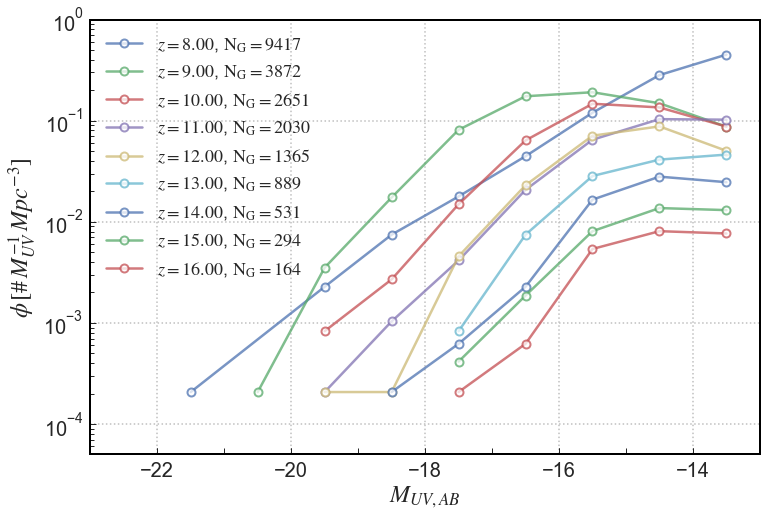

In [49]:
brightM = -23
limitM  = -13
magBins = np.linspace(brightM,limitM,-brightM+limitM+1) 

np.set_printoptions(precision=3)

sns.set(style="whitegrid", font_scale=2, color_codes=True)
sns.set_style({'axes.edgecolor': '0.0','axes.linewidth': 2.0})

print("Limiting absolute magnitude: {:d}".format(limitM))

rgForSFunc = np.arange(brightM,limitM, 0.1)

fig = plt.figure(figsize=(12,8))
ax = plt.axes()
# ax.set_axis_bgcolor('w')

#for z in np.sort(thezs):
for z in np.sort([8,9,10,11,12,13,14,15,16]):

    # Convert observed magnitude to Absolute ...
    absMag, pop3Mag, nmAbsMag       = compMags(z)
    Ng = len(absMag)
    print("Number of galaxies at z={} is {}".format(z,Ng))
    # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
    # both the improved Pop III luminosity and the classical

    nTempA, binsA = np.histogram(absMag,bins=magBins, density=False,
                                weights=[1.0/simVol for i in absMag]) 
    ################################
    # Replace zero halos in a bin with
    # nan ... since we are undersampled
    ################################
    AllNonZero    = np.nonzero(nTempA)  # Define a mask of non-zero values
    
    # Find bin-centers
    binDeltaA = (binsA[0]-binsA[1])/2.0
    binCentersA = binsA[1::]+binDeltaA
    

    # So here we are only plotting non-zero values -- and connecting them with a line.
    # So there are dropouts in this data that we are ignorning! I think this is ok since
    # we are sampling a small volume and are gonna miss halos in the intermediate mags
    ax.plot(binCentersA[AllNonZero],nTempA[AllNonZero],ls='-',marker='o',  
            alpha=0.75, markerfacecolor="w",markeredgewidth=2.0,
            markersize=8,lw=2.5,label=r'$z={:.2f}$, $\rm{{N}}_G={}$'.format(z,Ng))

    ax.set_xscale('linear')
    ax.set_yscale('log')
    ax.set_xlim([brightM,limitM])
    ax.yaxis.set_tick_params(which='major',width=1,length=6)
    ax.yaxis.set_tick_params(which='minor',width=1,length=4)
    ax.xaxis.set_tick_params(which='both',width=1,length=6)
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=6))
    ax.xaxis.set_minor_locator(ticker.MaxNLocator(nbins=-brightM+limitM+1))
    ax.get_yaxis().set_tick_params(which='both', direction='in')
    ax.get_xaxis().set_tick_params(which='both', direction='in')
    ax.set_ylim([5e-5,1])
    ax.set_xlabel('$M_{UV,AB}$',fontsize=24)
    ax.set_ylabel(r'$\phi\, [\#\, M_{UV}^{-1}\, Mpc^{-3}]$',fontsize=24)
    ax.grid(color='0.75', linestyle=':', linewidth=1.5)

#     plt.gca().invert_xaxis()
    gc.collect()
    

ax.legend(loc=0, fontsize=18, numpoints=1 )
#plt.savefig("haloUVMag_All_scatter.pdf",dpi=fig.dpi,bbox_inches='tight')

gc.collect()

In [50]:
(1.0+z)**-1

0.058823529411764705

In [51]:
bouwens=np.loadtxt("Bouwensz12LF.txt",skiprows=1)
OShea12=np.loadtxt("OShea-z12.txt",skiprows=1)
OShea14=np.loadtxt("OShea-z14.txt",skiprows=1)
OShea15=np.loadtxt("OShea-z15.txt",skiprows=1)
OShea16=np.loadtxt("OShea-z16.txt",skiprows=1)
OShea = {
    12: OShea12,
    14: OShea14,
    15: OShea15,
    16: OShea16
}

In [52]:
oesch13

array([[-21.275,  -5.575,  -0.833,   0.293],
       [-20.781,  -5.167,  -0.417,   0.232],
       [-20.291,  -5.071,  -0.256,   0.   ],
       [-19.776,  -4.71 ,  -0.189,   0.   ],
       [-19.278,  -4.08 ,  -0.182,   0.   ],
       [-18.775,  -3.647,  -0.153,   0.   ],
       [-18.27 ,  -3.214,  -0.178,   0.   ],
       [-17.785,  -2.903,  -0.811,   0.313]])

In [53]:
# This converts a error (dx) in log space (so log of the error in x)
# into a error away from the central data point 
def logErrFix(dp, dx):
    return np.abs((10**dx-1.0)*dp)

In [54]:
logErrFix(10**bouwens15[3,1],bouwens15[3,2]),logErrFix(10**bouwens15[3,1],bouwens15[3,3])

(0.00016818495285944842, 0.00015769982919490588)

In [55]:
simVol, (12/.71)**3

(4828.01590339498, 4828.01590339498)

In [56]:
print(np.ma.masked_where(fluxes[11]['1500A_P3']==0,fluxes[11]['1500A_P3']))

[8.637e-38 5.014e-38 4e-38 ..., 7.392e-37 1.438e-38 5.265e-33]


In [57]:
z

16

Convert to Abs Mag. DM = 47.20 @ z=8.0
JWST lim -15.8
JWST lim -14.2
Bin size is 1.0
[   1    0   11   36   86  215  579 1364]
[ 0.     0.     0.001  0.001  0.002  0.003  0.005  0.008] 
 [ 0.     0.     0.001  0.001  0.002  0.003  0.005  0.008]
[ 0.     0.     0.001  0.001  0.002  0.003  0.005  0.008] 
 [  1.571e-04  -5.000e-05   6.870e-04   1.243e-03   1.921e-03   3.037e-03
   4.984e-03   7.650e-03]
Convert to Abs Mag. DM = 47.38 @ z=9.0
JWST lim -16.0
JWST lim -14.4
Bin size is 1.0
[  0   1  17  84 392 842 923 718]


/Users/earnric/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


[ 0.     0.     0.001  0.002  0.004  0.006  0.006  0.006] 
 [ 0.     0.     0.001  0.002  0.004  0.006  0.006  0.006]
[ 0.     0.     0.001  0.002  0.004  0.006  0.006  0.006] 
 [ -5.000e-05   1.571e-04   8.540e-04   1.898e-03   4.101e-03   6.010e-03
   6.293e-03   5.550e-03]
Convert to Abs Mag. DM = 47.54 @ z=10.0
JWST lim -16.1
JWST lim -14.5
Bin size is 1.0
[  0   0   4  13  72 308 710 653]
[ 0.     0.     0.     0.001  0.002  0.004  0.006  0.005] 
 [ 0.     0.     0.     0.001  0.002  0.004  0.006  0.005]
[ 0.     0.     0.     0.001  0.002  0.004  0.006  0.005] 
 [ -5.000e-05  -5.000e-05   4.142e-04   7.468e-04   1.758e-03   3.635e-03
   5.519e-03   5.293e-03]
Convert to Abs Mag. DM = 47.68 @ z=11.0
JWST lim -16.3
JWST lim -14.7
Bin size is 1.0
[  0   0   1   5  20 100 313 500]
[ 0.     0.     0.     0.     0.001  0.002  0.004  0.005] 
 [ 0.     0.     0.     0.     0.001  0.002  0.004  0.005]
[ 0.     0.     0.     0.     0.001  0.002  0.004  0.005] 
 [ -5.000e-05  -5.000e-05   1

14016

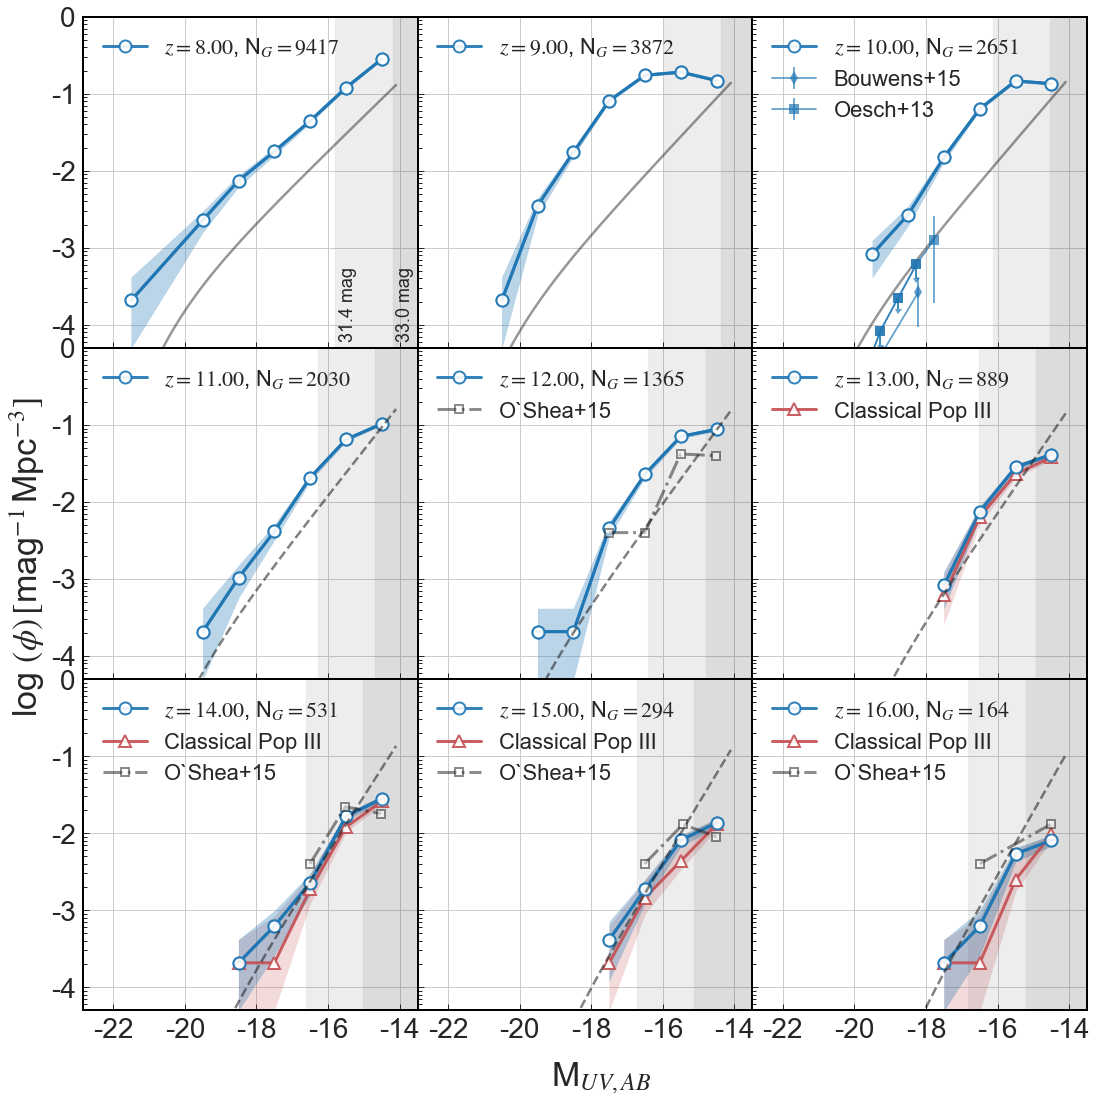

In [60]:
# Print LFs compared to Finkelstein projections... 
# Four plots in one figure

sns.set(style="whitegrid", font_scale=2,color_codes=True)
sns.set_style({'axes.edgecolor': '0.0','axes.linewidth': 2.0})
colors = ['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']
colors = ['#1f77b4',
'#1f77b4',
'#1f77b4',
'#1f77b4',
'#1f77b4',
'#1f77b4',
'#1f77b4',
'#1f77b4',
'#1f77b4',
'#1f77b4']
# colors = ['b','g','r','m','c','y']

brightM = -22 # Plot range... 
limitM  = -14
magBins = np.linspace(brightM,limitM,(-brightM+limitM)*1+1) 

jwstUDC = 31.4
jwstUDC2 = 33.0

fig, axs = plt.subplots(nrows=3, ncols=3, sharex='col',sharey='row',figsize=(15,15))
for z,c,ax in zip(np.sort([8,9,10,11,12,13,14,15,16]),colors, axs.reshape(-1)):
    # Convert observed magnitude to Absolute ...
    absMag, pop3Mag, nmAbsMag       = compMags(z)
    
    # Get the JWST ultra-deep campaign limit
    jwstUDCM= jwstUDC - 2.5*np.log10((1.0+z)**-1*(cosmo.luminosity_distance(z).to(u.pc)/(10.0 * u.pc))**2)
    jwstUDC2M= jwstUDC2 - 2.5*np.log10((1.0+z)**-1*(cosmo.luminosity_distance(z).to(u.pc)/(10.0 * u.pc))**2)
    print("JWST lim {:.1f}".format(jwstUDCM))
    print("JWST lim {:.1f}".format(jwstUDC2M))
    Ng = len(absMag) # Number of galaxies at this z
    
    rgForSFunc = np.arange(brightM,limitM, 0.1) # Smooth Schechter (Finkelstein data) curve... 

    dx = np.diff(magBins)
    print("Bin size is {}".format(dx[0]))

    # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
    # both the improved Pop III luminosity and the classical
    n, binsA = np.histogram(absMag,bins=magBins, density=False)
    nNM, binsANM = np.histogram(nmAbsMag,bins=magBins, density=False)
    
    # This error is correct, but it'll plot 'funny' (i.e. - looks like bigger error on the dimmer end)
    # because the error at 1e-1 on the negative side of the value covers a large portion of the plot...
    # Look at the size of the positive error
#     print(n)
    errUp = (np.sqrt(n))/dx/simVol
    errDn = (np.sqrt(n))/dx/simVol
#     print(errUp,"\n",errDn)
    errUpNM = (np.sqrt(nNM))/dx/simVol
    errDnNM = (np.sqrt(nNM))/dx/simVol
    
    n = n/dx/simVol
    nNM = nNM/dx/simVol
    
    # Fix error when it is 100% ... if n = sqrt(n) we need error to go to bottom of plot
    errDn[n-errDn <= 0.0] = n[n-errDn <= 0] - 5e-5 # which extends error to the plot's lower limit
    errDnNM[nNM-errDnNM <= 0.0] = nNM[nNM-errDnNM <= 0] - 5e-5 # which extends error to the plot's lower limit
    print(errUp,"\n",errDn)

    ################################
    # Replace zero halos in a bin with
    # nan ... since we are undersampled
    ################################
    AllNonZero    = np.nonzero(n)  # Define a mask of non-zero values
    AllNonZeroNM  = np.nonzero(nNM)  # Define a mask of non-zero values
    
    # Find bin-centers
    binDeltaA = (binsA[0]-binsA[1])/2.0
    binCentersA = binsA[1::]+binDeltaA
    
        
    mec = mpl.colors.colorConverter.to_rgba(c, alpha=1.0)
    # So here we are only plotting non-zero values -- and connecting them with a line.
    # So there are dropouts in this data that we are ignorning! I think this is ok since
    # we are sampling a small volume and are gonna miss halos in the intermediate mags
    ax.plot(binCentersA[AllNonZero],n[AllNonZero],markeredgewidth=2.0,
            ls='-',marker='o', c=c, alpha=0.9,markerfacecolor="w",
            markersize=12,lw=3.0,mec=mec,label=r'$z={:.2f}$, N$_G={}$'.format(z,Ng))
    if z > 12:
        ax.plot(binCentersA[AllNonZeroNM],nNM[AllNonZeroNM],markeredgewidth=2.0,
            ls='-',marker='^', c='C2', alpha=0.9,markerfacecolor="w",
            markersize=12,lw=3.0,mec='C2',label=r'Classical Pop III'.format(z,Ng))
        ax.fill_between(binCentersA[AllNonZeroNM],n[AllNonZeroNM]+errUpNM[AllNonZeroNM],nNM[AllNonZeroNM]-errDnNM[AllNonZeroNM],
            color='C2', alpha=0.2)
    ax.plot(binCentersA[AllNonZero],n[AllNonZero],markeredgewidth=2.0,
            ls='-',marker='o', c=c, alpha=0.9,markerfacecolor="w",
            markersize=12,lw=3.0,mec=mec) # Plot again so overlaps Classic
    ax.fill_between(binCentersA[AllNonZero],n[AllNonZero]+errUp[AllNonZero],n[AllNonZero]-errDn[AllNonZero],
            color=c, alpha=0.3)
    ax.axvspan( jwstUDCM, limitM+0.5, alpha=0.08, color='k')
    ax.axvspan( jwstUDC2M, limitM+0.5, alpha=0.08, color='k')
    if z == 8:
        ax.annotate('31.4 mag', xy = (0.5, 0.5), xytext = (jwstUDCM+0.1, 6e-5), xycoords='axes fraction',
            textcoords = 'data', ha = 'left', va = 'bottom',fontsize=18, rotation=90)
        ax.annotate('33.0 mag', xy = (0.5, 0.5), xytext = (jwstUDC2M+0.1, 6e-5), xycoords='axes fraction',
            textcoords = 'data', ha = 'left', va = 'bottom',fontsize=18, rotation=90)

    # Format plt
    ax.set_xscale('linear')
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(logfmt)
    ax.set_xlim([brightM-0.85,limitM+0.5])
    ax.set_xticks(np.arange(brightM,limitM+1,2))
    ax.set_xticklabels([str(i) for i in np.arange(brightM,limitM+1,2)])
    ax.set_ylim([5e-5,1])
    ax.set_yticks([1e-4,1e-3,1e-2,1e-1,1])
    ax.xaxis.set_tick_params(which='both',width=1,length=6,direction='in',labelsize=28)
    ax.yaxis.set_tick_params(which='major',width=1,length=6,direction='in',labelsize=28)
    ax.yaxis.set_tick_params(which='minor',width=1,length=4,direction='in')

    #     plt.gca().invert_xaxis()
    gc.collect()
    
    # Add O'Shea data if available
    if z in OShea:
        ax.plot(OShea[z][:,0][OShea[z][:,0] < -14],OShea[z][:,1][OShea[z][:,0] < -14],ls='-.',marker='s',
                markeredgewidth=2.0,markerfacecolor="w",c='k', ms=8, lw=3.0,alpha=0.5, label='O`Shea+15')

    if z > 10:
        ax.plot(rgForSFunc, schechterM_forFit(finkel[z], rgForSFunc),'k--',lw=2.5,alpha=0.55)
    else:
        ax.plot(rgForSFunc, schechterM_forFit(finkel[z], rgForSFunc),'k-',lw=2.5,alpha=0.45)

    if z==10:
#         print("To logErrFix:",(10**bouwens15[:,1],bouwens15[:,2]),(10**bouwens15[:,1],bouwens15[:,3]))
        
        ax.errorbar(bouwens15[:,0],10**bouwens15[:,1], yerr=[logErrFix(10**bouwens15[:,1],bouwens15[:,2]),
                                                         logErrFix(10**bouwens15[:,1],bouwens15[:,3])],
                    marker='d',c=c,alpha=0.7, markersize=10, mec='None',
                    label=r'Bouwens+15')
        ax.errorbar(oesch13[:,0],10**oesch13[:,1], yerr=[logErrFix(10**oesch13[:,1],oesch13[:,2]),
                                                         logErrFix(10**oesch13[:,1],oesch13[:,3])],
                    marker='s',c=c,alpha=0.7,markersize=10,mec='k',label=r'Oesch+13'.format(z,Ng))
        ax.errorbar(oesch13[2:7,0],10**oesch13[2:7,1], yerr=[logErrFix(10**oesch13[2:7,1],oesch13[2:7,2]),
                                                         logErrFix(10**oesch13[2:7,1],oesch13[2:7,3])],
                    marker='s',c=c,alpha=0.7,markersize=10,mec='k',uplims=True)
    
    ax.legend(loc=2, fontsize=22, numpoints=1 )

fig.text(0.55, 0.01,'M$_{UV,AB}$', ha='center',size=34, )
fig.text(0.00, 0.5, r'log $(\phi)\, [$mag$^{-1}\, $Mpc$^{-3}]$',size=34,
         va='center', rotation='vertical')
plt.subplots_adjust(left=0.07, bottom=0.08, right=1.0, top=1.0, wspace=.0, hspace=.0)
plt.savefig("haloUVMag_Summary_scatter9.pdf".format(z),dpi=fig.dpi,bbox_inches='tight')
gc.collect()

In [62]:
# Print LFs compared to Finkelstein projections... 
# Four plots in one figure

sns.set(style="whitegrid", font_scale=2,color_codes=True)
sns.set_style({'axes.edgecolor': '0.0','axes.linewidth': 2.0})
colors = ['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']
colors = ['#1f77b4',
'#1f77b4',
'#1f77b4',
'#1f77b4',
'#1f77b4',
'#1f77b4',
'#1f77b4',
'#1f77b4',
'#1f77b4',
'#1f77b4']
# colors = ['b','g','r','m','c','y']

brightM = -22 # Plot range... 
limitM  = -14
magBins = np.linspace(brightM,limitM,(-brightM+limitM)*1+1) 

jwstUDC = 31.4

fig, axs = plt.subplots(nrows=2, ncols=3, sharex='col',sharey='row',figsize=(22,12))
axs[0, 0].axis('off')
axs[0, 1].axis('off')
for z,c,ax in zip(np.sort([11,12,13,14,15,16]),colors, axs.reshape(-1)):
    if z < 13:
        continue
    # Convert observed magnitude to Absolute ...
    absMag, pop3Mag, nmAbsMag       = compMags(z)
    
    # Get the JWST ultra-deep campaign limit
    jwstUDCM= jwstUDC - 2.5*np.log10((1.0+z)**-1*(cosmo.luminosity_distance(z).to(u.pc)/(10. * u.pc))**2)
    print("JWST lim {:.1f}".format(jwstUDCM))
    Ng = len(absMag) # Number of galaxies at this z
    
    rgForSFunc = np.arange(brightM,limitM, 0.1) # Smooth Schechter (Finkelstein data) curve... 

    dx = np.diff(magBins)
    print("Bin size is {}".format(dx[0]))

    # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
    # both the improved Pop III luminosity and the classical
    n, binsA = np.histogram(absMag,bins=magBins, density=False)
    nNM, binsANM = np.histogram(nmAbsMag,bins=magBins, density=False)
    
    errUp = (np.sqrt(n))/dx/simVol
    errDn = (np.sqrt(n))/dx/simVol
#     print(errUp,"\n",errDn)
    errUpNM = (np.sqrt(nNM))/dx/simVol
    errDnNM = (np.sqrt(nNM))/dx/simVol
    
    n = n/dx/simVol
    nNM = nNM/dx/simVol
    
    # Fix error when it is 100% ... if n = sqrt(n) we need error to go to bottom of plot
    errDn[n-errDn <= 0.0] = n[n-errDn <= 0] - 5e-5 # which extends error to the plot's lower limit
    errDnNM[nNM-errDnNM <= 0.0] = nNM[nNM-errDnNM <= 0] - 5e-5 # which extends error to the plot's lower limit
#     print(errUp,"\n",errDn)

    ################################
    # Replace zero halos in a bin with
    # nan ... since we are undersampled
    ################################
    AllNonZero    = np.nonzero(n)  # Define a mask of non-zero values
    AllNonZeroNM  = np.nonzero(nNM)  # Define a mask of non-zero values
    
    # Find bin-centers
    binDeltaA = (binsA[0]-binsA[1])/2.0
    binCentersA = binsA[1::]+binDeltaA
    
        
    mec = mpl.colors.colorConverter.to_rgba(c, alpha=1.0)
    # So here we are only plotting non-zero values -- and connecting them with a line.
    # So there are dropouts in this data that we are ignorning! I think this is ok since
    # we are sampling a small volume and are gonna miss halos in the intermediate mags
    ax.plot(binCentersA[AllNonZero],n[AllNonZero],markeredgewidth=2.0,
            ls='-',marker='o', c=c, alpha=0.6,markerfacecolor="w",
            markersize=12,lw=3.0,mec=mec,label=r'$z={:.2f}$'.format(z,Ng))
    ax.plot(binCentersA[AllNonZeroNM],nNM[AllNonZeroNM],markeredgewidth=2.0,
            ls='-',marker='^', c='#ff7f0e', alpha=0.9,markerfacecolor="w",
            markersize=12,lw=3.0,mec=mec,label=r'No Mix'.format(z,Ng))
    ax.axvspan( jwstUDCM, limitM+0.5, alpha=0.10, color='k')
#     ax.annotate('31.4 mag', xy = (0.5, 0.5), xytext = (jwstUDCM+0.1, 6e-5), xycoords='axes fraction',
#         textcoords = 'data', ha = 'left', va = 'bottom',fontsize=18, rotation=90)
    ax.fill_between(binCentersA[AllNonZero],n[AllNonZero]+errUp[AllNonZero],n[AllNonZero]-errDn[AllNonZero],
            color=c, alpha=0.3)
    ax.fill_between(binCentersA[AllNonZeroNM],n[AllNonZeroNM]+errUpNM[AllNonZeroNM],nNM[AllNonZeroNM]-errDnNM[AllNonZeroNM],
            color='#ff7f0e', alpha=0.3)

    # Format plt
    ax.set_xscale('linear')
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(logfmt)
    ax.set_xlim([brightM-0.85,limitM+0.5])
    ax.set_xticks(np.arange(brightM,limitM+1,2))
    ax.set_xticklabels([str(i) for i in np.arange(brightM,limitM+1,2)])
    ax.set_ylim([5e-5,1])
    ax.xaxis.set_tick_params(which='both',width=1,length=6,direction='in',labelsize=28)
    ax.yaxis.set_tick_params(which='major',width=1,length=6,direction='in',labelsize=28)
    ax.yaxis.set_tick_params(which='minor',width=1,length=4,direction='in')
    if z == 13:
        for tk in ax.get_yticklabels():
            tk.set_visible(True)

    #     plt.gca().invert_xaxis()
    gc.collect()
    
    # Add O'Shea data if available
    if z in OShea:
        ax.plot(OShea[z][:,0][OShea[z][:,0] < -14],OShea[z][:,1][OShea[z][:,0] < -14],ls='-.',marker='s',
                markeredgewidth=2.0,markerfacecolor="w",c='k', ms=8, lw=3.0,alpha=0.5, label='O`Shea+15')

    if z > 10:
        ax.plot(rgForSFunc, schechterM_forFit(finkel[z], rgForSFunc),'k--',lw=2.5,alpha=0.55)
    else:
        ax.plot(rgForSFunc, schechterM_forFit(finkel[z], rgForSFunc),'k-',lw=2.5,alpha=0.45)

    if z==10:
#         print("To logErrFix:",(10**bouwens15[:,1],bouwens15[:,2]),(10**bouwens15[:,1],bouwens15[:,3]))
        
        ax.errorbar(bouwens15[:,0],10**bouwens15[:,1], yerr=[logErrFix(10**bouwens15[:,1],bouwens15[:,2]),
                                                         logErrFix(10**bouwens15[:,1],bouwens15[:,3])],
                    marker='d',c=c,alpha=0.7, markersize=10, mec='None',
                    label=r'Bouwens+15')
        ax.errorbar(oesch13[:,0],10**oesch13[:,1], yerr=[logErrFix(10**oesch13[:,1],oesch13[:,2]),
                                                         logErrFix(10**oesch13[:,1],oesch13[:,3])],
                    marker='s',c=c,alpha=0.7,markersize=10,mec='k',label=r'Oesch+13'.format(z,Ng))
        ax.errorbar(oesch13[2:7,0],10**oesch13[2:7,1], yerr=[logErrFix(10**oesch13[2:7,1],oesch13[2:7,2]),
                                                         logErrFix(10**oesch13[2:7,1],oesch13[2:7,3])],
                    marker='s',c=c,alpha=0.7,markersize=10,mec='k',uplims=True)
    
    ax.legend(loc=2, fontsize=28, numpoints=1 )

fig.text(0.55, 0.01,'M$_{UV,AB}$', ha='center',size=38, )
fig.text(0.00, 0.5, r'log $(\phi)\, [$mag$^{-1}\, $Mpc$^{-3}]$',size=38,
         va='center', rotation='vertical')
plt.subplots_adjust(left=0.07, bottom=0.08, right=1.0, top=1.0, wspace=.0, hspace=.0)
plt.savefig("haloUVMag_Summary_scatter6-NM.pdf".format(z),dpi=fig.dpi,bbox_inches='tight')
gc.collect()

Convert to Abs Mag. DM = 47.92 @ z=13.0
JWST lim -16.5
Bin size is 1.0
Convert to Abs Mag. DM = 48.03 @ z=14.0
JWST lim -16.6
Bin size is 1.0

/Users/earnric/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys



Convert to Abs Mag. DM = 48.13 @ z=15.0
JWST lim -16.7
Bin size is 1.0
Convert to Abs Mag. DM = 48.22 @ z=16.0
JWST lim -16.8
Bin size is 1.0


10477

In [12]:
# ##########################################################
# Normalizes the histogram's bar height by the bin width
# and co-moving volume of the simulation
# ##########################################################
def normBarHeight(bins, patches, cmvol, rotated=False):
    widths = np.diff(bins)
    for item,dx in zip(patches,widths):
#         print ("Starting height: %.5f bin width: %.2e"%(item.get_height(),dx))
        if not rotated:
            item.set_height(item.get_height()/dx/cmvol)
        else:
            item.set_width(item.get_width()/dx/cmvol)
#         print ("Ending width: %.5f"%item.get_width())
    return


Limiting absolute magnitude: -13
Convert to Abs Mag. DM = 47.20 @ z=8.0
Pop III flux fraction is 0.06457 at z=8
Number of galaxies 9417
Largest bin value: 2.503, smallest -2.77844139821


/Users/earnric/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/Users/earnric/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:55: RuntimeWarning: divide by zero encountered in log10


Number in histogram 4464.0
Convert to Abs Mag. DM = 47.38 @ z=9.0
Pop III flux fraction is 0.31201 at z=9
Number of galaxies 3872
Largest bin value: 2.145, smallest -2.77844139821
Number in histogram 3398.0
Convert to Abs Mag. DM = 47.54 @ z=10.0
Pop III flux fraction is 0.12048 at z=10
Number of galaxies 2651
Largest bin value: 2.007, smallest -2.93568347249
Number in histogram 2182.0
Convert to Abs Mag. DM = 47.68 @ z=11.0
Pop III flux fraction is 0.19452 at z=11
Number of galaxies 2030
Largest bin value: 1.793, smallest -3.11177473154
Number in histogram 1432.0
Convert to Abs Mag. DM = 47.80 @ z=12.0
Pop III flux fraction is 0.21308 at z=12
Number of galaxies 1365
Largest bin value: 1.715, smallest -2.77844139821
Number in histogram 1145.0
Convert to Abs Mag. DM = 48.03 @ z=14.0
Pop III flux fraction is 0.44895 at z=14
Number of galaxies 531
Largest bin value: 1.039, smallest -3.11177473154
Number in histogram 349.0
Convert to Abs Mag. DM = 48.21 @ z=16.0
Pop III flux fraction is 0.

3802

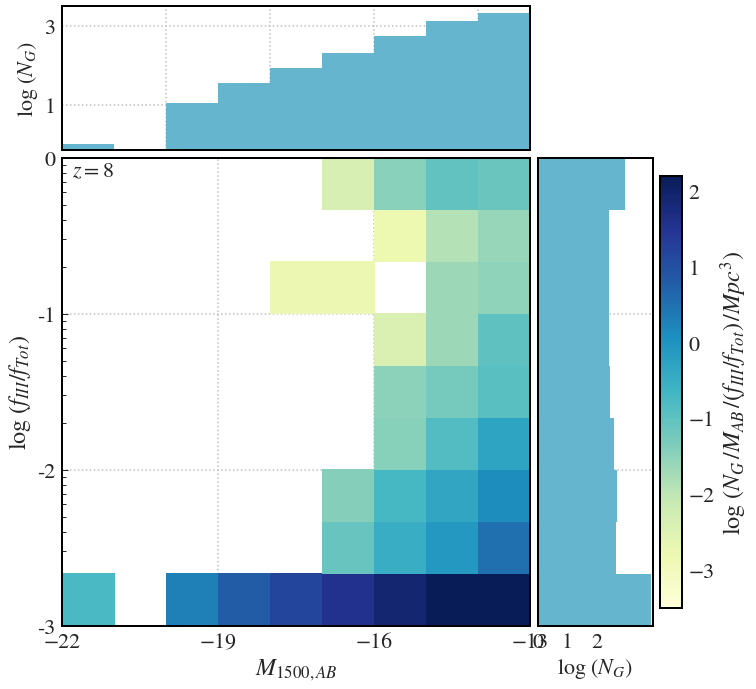

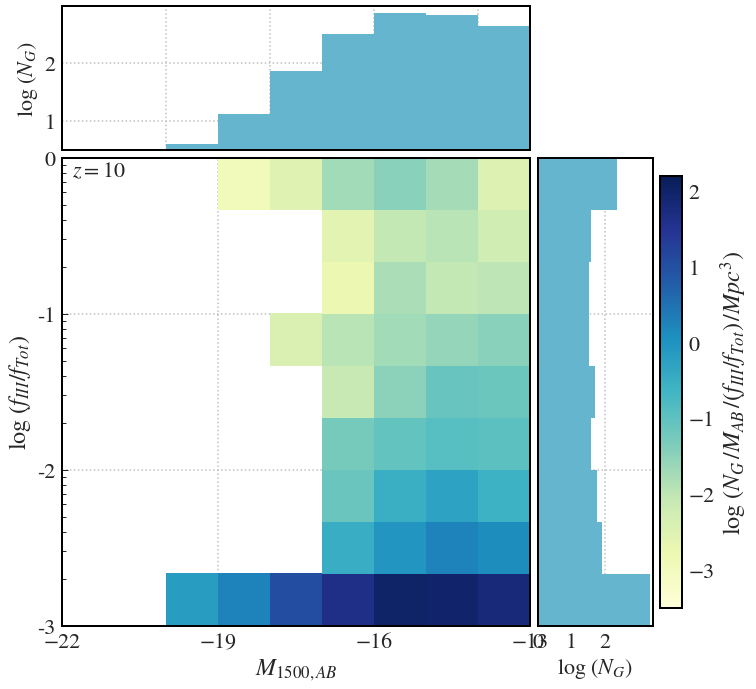

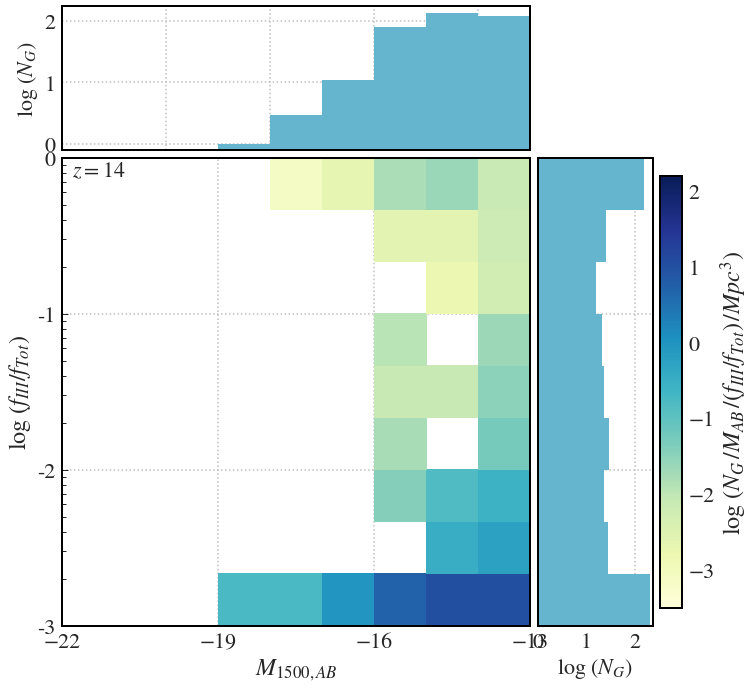

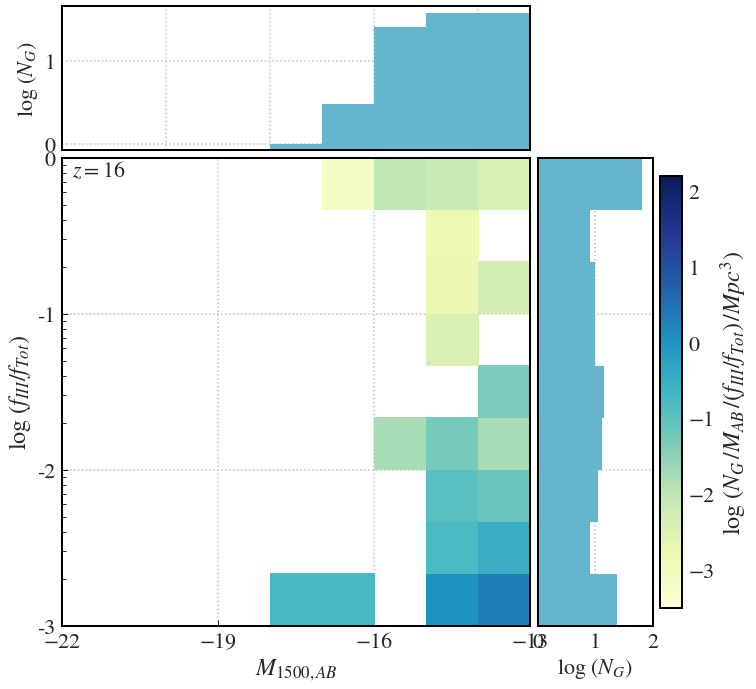

In [13]:
# Plot the fraction of Pop III magnitude vs M_AB NORMALIZED...
# Normalize by bin size and vol of simulation... 

brightM = -22
limitM  = -13
magBins = np.linspace(brightM,limitM,(-brightM+limitM)*1 + 1) 
fracBins = np.logspace(-3,0,(-brightM+limitM)*1 + 1)
print("Limiting absolute magnitude: {:d}".format(limitM))

left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.01

rect_2dhist = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]


rgForSFunc = np.arange(brightM,limitM, 0.1)

for z in np.sort([8,9,10,11,12,14,16]):
    fig = plt.figure(figsize=(10, 10))
    ax       = plt.axes(rect_2dhist)
    axHistx  = plt.axes(rect_histx)
    axHisty  = plt.axes(rect_histy)

    # Convert observed magnitude to Absolute ...
    absMag, pop3Mag, nmAbsMag   = compMags(z)    
    pop3Fraction                = fluxes[z]['1500A_P3']/fluxes[z]['1500A']
    print("Pop III flux fraction is {:.5f} at z={}".format(fluxes[z]['1500A_P3'].sum()/fluxes[z]['1500A'].sum(),z))
    pop3Fraction[pop3Fraction<1e-3] = 1e-3
    
    Ng = len(absMag) # Number of galaxies at this z
    print("Number of galaxies {}".format(Ng))
    # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
    # both the improved Pop III luminosity and the classical

    # Note that we are reversing x,y here since pcolormesh interprets them backwards!
    nTempA, binsx, binsy = np.histogram2d(pop3Fraction,absMag,bins=[fracBins,magBins],normed=False)
    # could use weights=[1/simVol for i in absMag] to normalize by vol here... 
    # normed : bool, optional
    #        If False, returns the number of samples in each bin. If True, returns the bin density 
    #        bin_count / sample_count / bin_area.

    X, Y = np.meshgrid(magBins, fracBins)  # Create a grid over the range of bins for the plot

    # Mask out 0 values before taking log10... 
    masked_array=np.ma.masked_where(nTempA==0.0, nTempA)
    dx = np.diff(magBins)
    dy = np.diff(fracBins) 
    area = dx[:,None] * dy # compute the area of each bin using broadcasting
    #H = masked_array
    H = masked_array/area.T  # Divide out bin area... area has column, row... Need TRANSPOSE!
    H = H/simVol           # Divide out vol of sim
    H = np.log10(H)        # Take log of counts, we've already normalized by volume and area
    print("Largest bin value: {:.3f}, smallest {}".format(H.max(),H.min()))
    # Create the plot
    cax = (ax.pcolormesh(X, Y, H, cmap=mpl.cm.YlGnBu, vmin=-3.5, vmax=2.2) )
    
    # Create the colorbar
    cbar = fig.colorbar(cax)
    cbar.ax.tick_params(labelsize=22) 
    #cbar.ax.set_yticklabels(['1', '2', '4', '6', '10', maxCV], size=24)
    cbar.set_label("log ($N_G\,/M_{AB}\,/(f_{III}/f_{Tot})\,/Mpc^3)$",fontsize=24)

    ax.set_xscale('linear')
    ax.set_yscale('log')
    ax.yaxis.set_tick_params(which='major',width=1,length=6)
    ax.yaxis.set_tick_params(which='minor',width=1,length=4)
    ax.xaxis.set_tick_params(which='both',width=1,length=6)
    ax.xaxis.set_ticks(np.arange(-22,-2, 3))
    ax.get_yaxis().set_tick_params(which='both', direction='in',labelsize=22)
    ax.get_xaxis().set_tick_params(which='both', direction='in',labelsize=22)
    ax.yaxis.set_major_formatter(logfmt)
    ax.set_xlim([brightM,limitM])
    ax.set_xlabel('$M_{1500,AB}$',fontsize=24)
    ax.set_ylabel(r'log ($f_{III}/f_{Tot}$)',fontsize=24)
    ax.grid(color='0.75', linestyle=':', linewidth=1.5)

    # plt.gca().invert_xaxis()
    gc.collect()
    
    ax.annotate('$z={}$'.format(z), xy = (0.95, 0.1), xytext = (0.02, 0.95), xycoords='axes fraction',
        textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=22)
    
    #
    # Generate histograms on top (for LF) and right side (for Pop III mag fraction)
    #
    # Generate the xy axes histograms
    # Remember -- using the weights parameter here weights each value, not the histogram count!
    N, bins, patches = axHistx.hist(absMag, bins=magBins, log=True, ec='None', color='C5')
#     normBarHeight(bins, patches, simVol, rotated=False)
    print("Number in histogram {}".format(np.sum(N)))
    N, bins, patches = axHisty.hist(pop3Fraction, bins=fracBins, range=(fracBins.min(),fracBins.max()), 
                                    log=True, orientation='horizontal', ec='None',color='C5')
#     normBarHeight(bins, patches, simVol, rotated=True)

    axHistx.set_yscale("log")
    axHisty.set_xscale("log")
    axHisty.set_yscale("log")
    axHistx.set_xlim(ax.get_xlim())
    axHisty.set_ylim(ax.get_ylim())
#     axHistx.set_ylim([0,1e3])
#     axHisty.set_xlim([0,1.5e3])
    axHisty.set_xticks([1,10,1e2])
    axHistx.yaxis.set_major_formatter(logfmt)
    axHisty.xaxis.set_major_formatter(logfmt)
    axHistx.grid(color='0.75', linestyle=':', linewidth=1.5)
    axHisty.grid(color='0.75', linestyle=':', linewidth=1.5)
    axHistx.get_yaxis().set_tick_params(which='both', direction='in',labelsize=22)
    axHisty.get_xaxis().set_tick_params(which='both', direction='in',labelsize=22)
    axHistx.set_ylabel('log ($N_G$)',fontsize=22)
    axHisty.set_xlabel(r'log ($N_G$)',fontsize=22)

    # no labels on these axes -- already on main plot
    axHistx.xaxis.set_major_formatter(nullfmt)
    axHisty.yaxis.set_major_formatter(nullfmt)
  
    plt.savefig("PopIII_fraction_{}-Histograms.pdf".format(z),dpi=fig.dpi,bbox_inches='tight')

gc.collect()

In [14]:
np.floor(-19.1)

-20.0

Convert to Abs Mag. DM = 47.20 @ z=8.0
Pop III flux fraction is 0.05545 at z=8
-22.0
Limiting absolute magnitude: -12.0
Number of galaxies 9199
Largest bin value: 0.000, smallest -2.8159096508867747


/Users/earnric/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:54: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


Convert to Abs Mag. DM = 47.38 @ z=9.0
Pop III flux fraction is 0.30985 at z=9
-21.0
Limiting absolute magnitude: -11.0
Number of galaxies 3831
Largest bin value: 0.000, smallest -2.9614210940664485
Convert to Abs Mag. DM = 47.54 @ z=10.0
Pop III flux fraction is 0.11879 at z=10
-20.0
Limiting absolute magnitude: -10.0
Number of galaxies 2667
Largest bin value: 0.000, smallest -2.8549130223078554
Convert to Abs Mag. DM = 47.68 @ z=11.0
Pop III flux fraction is 0.17830 at z=11
-20.0
Limiting absolute magnitude: -10.0
Number of galaxies 1943
Largest bin value: 0.000, smallest -2.6720978579357175
Convert to Abs Mag. DM = 47.80 @ z=12.0
Pop III flux fraction is 0.21308 at z=12
-20.0
Limiting absolute magnitude: -10.0
Number of galaxies 1365
Largest bin value: 0.000, smallest -2.534026106056135
Convert to Abs Mag. DM = 47.92 @ z=13.0
Pop III flux fraction is 0.33895 at z=13
-18.0
Limiting absolute magnitude: -8.0
Number of galaxies 889
Largest bin value: -0.125, smallest -2.346352974450639


13518

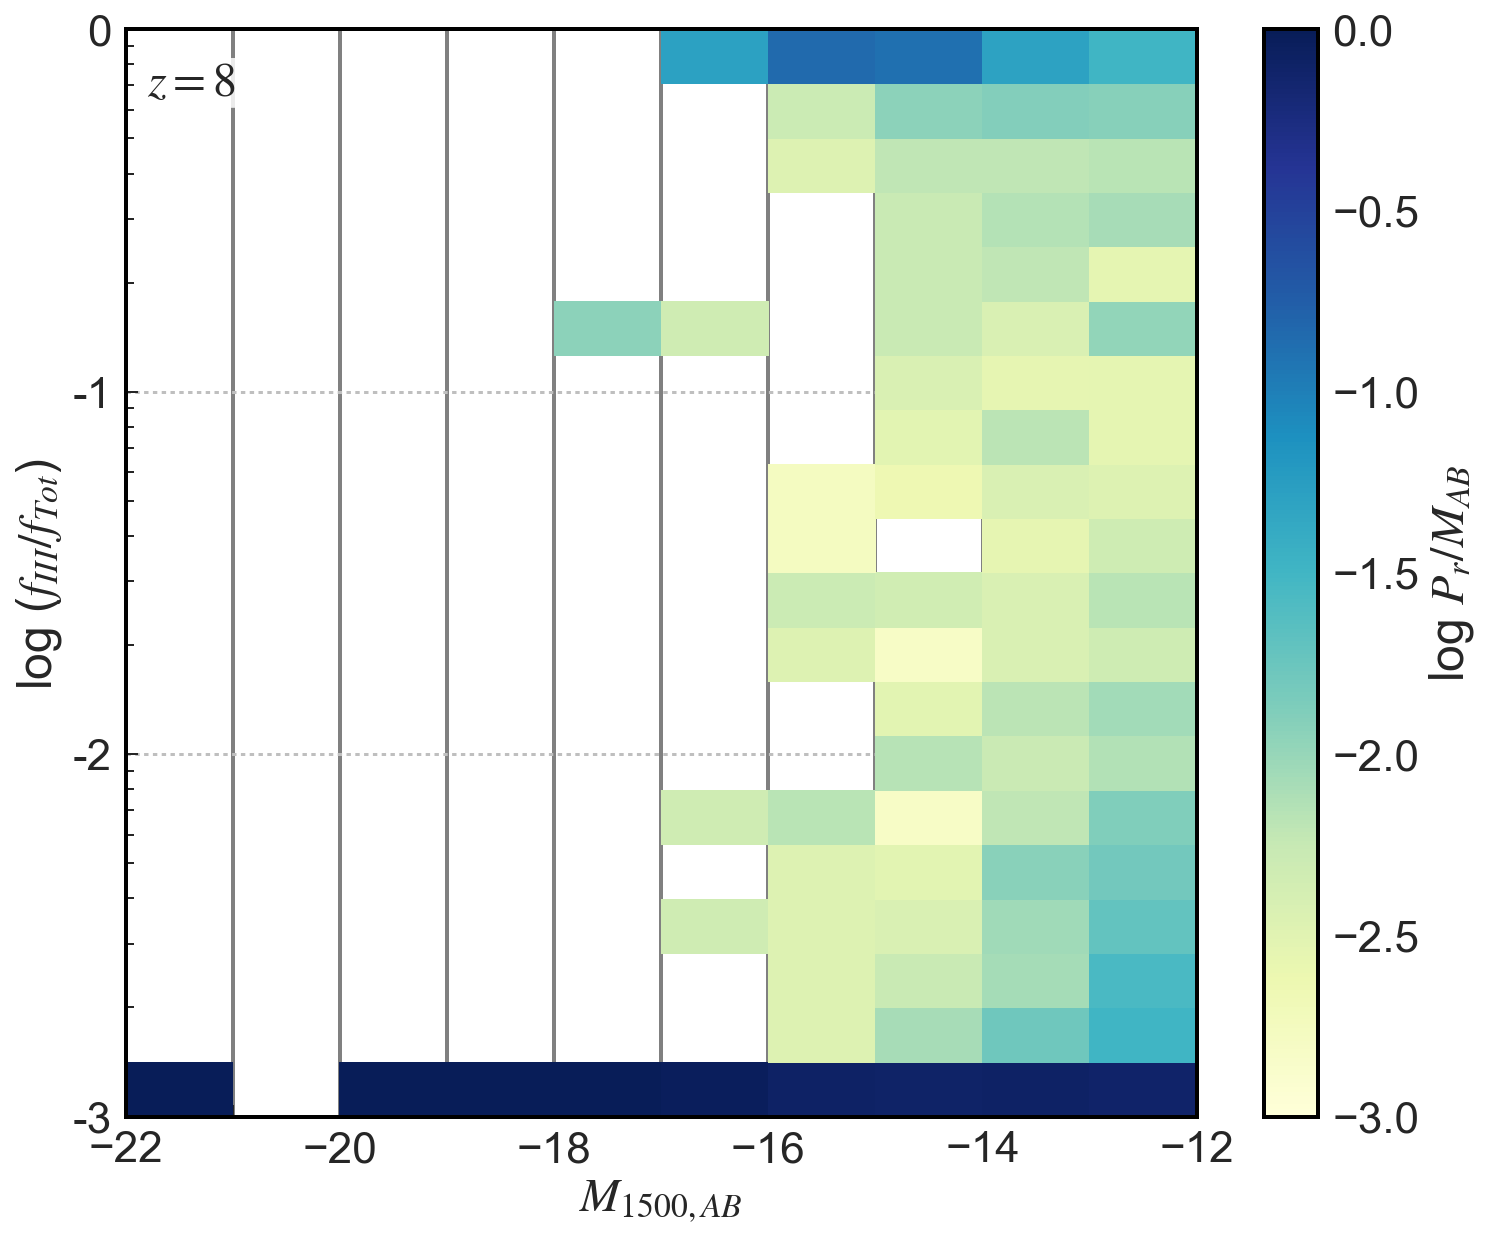

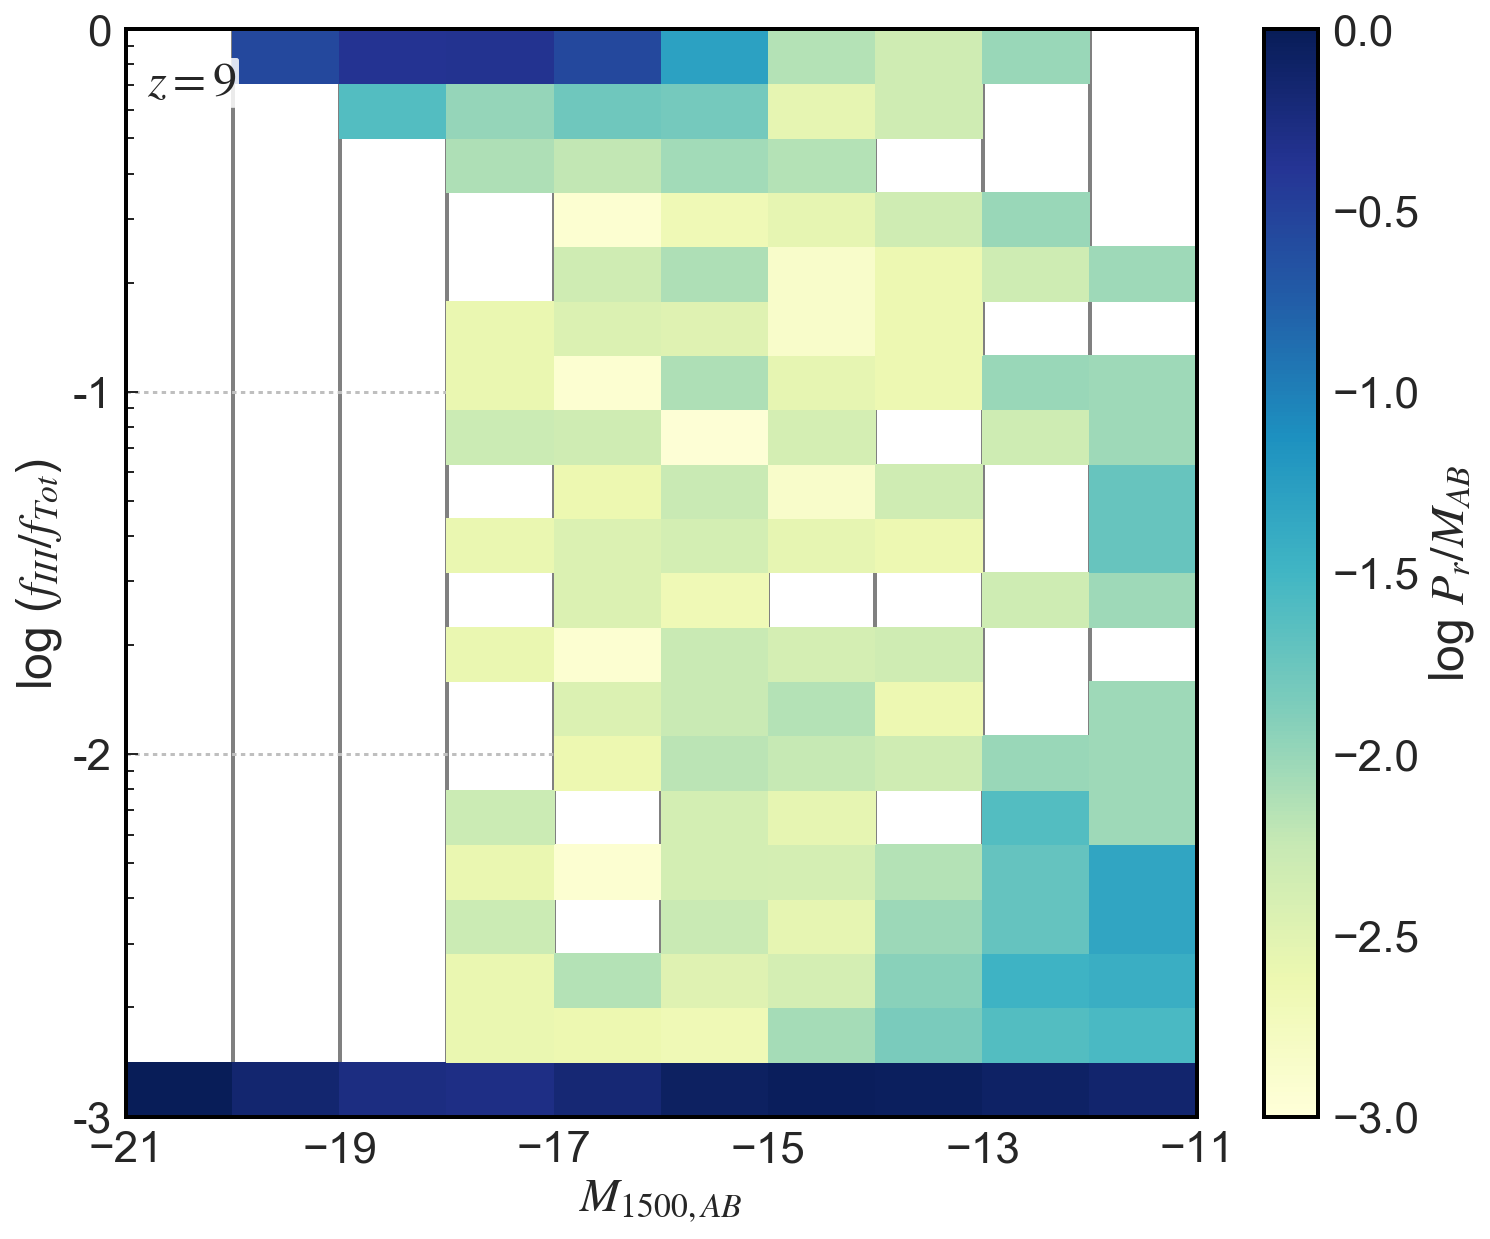

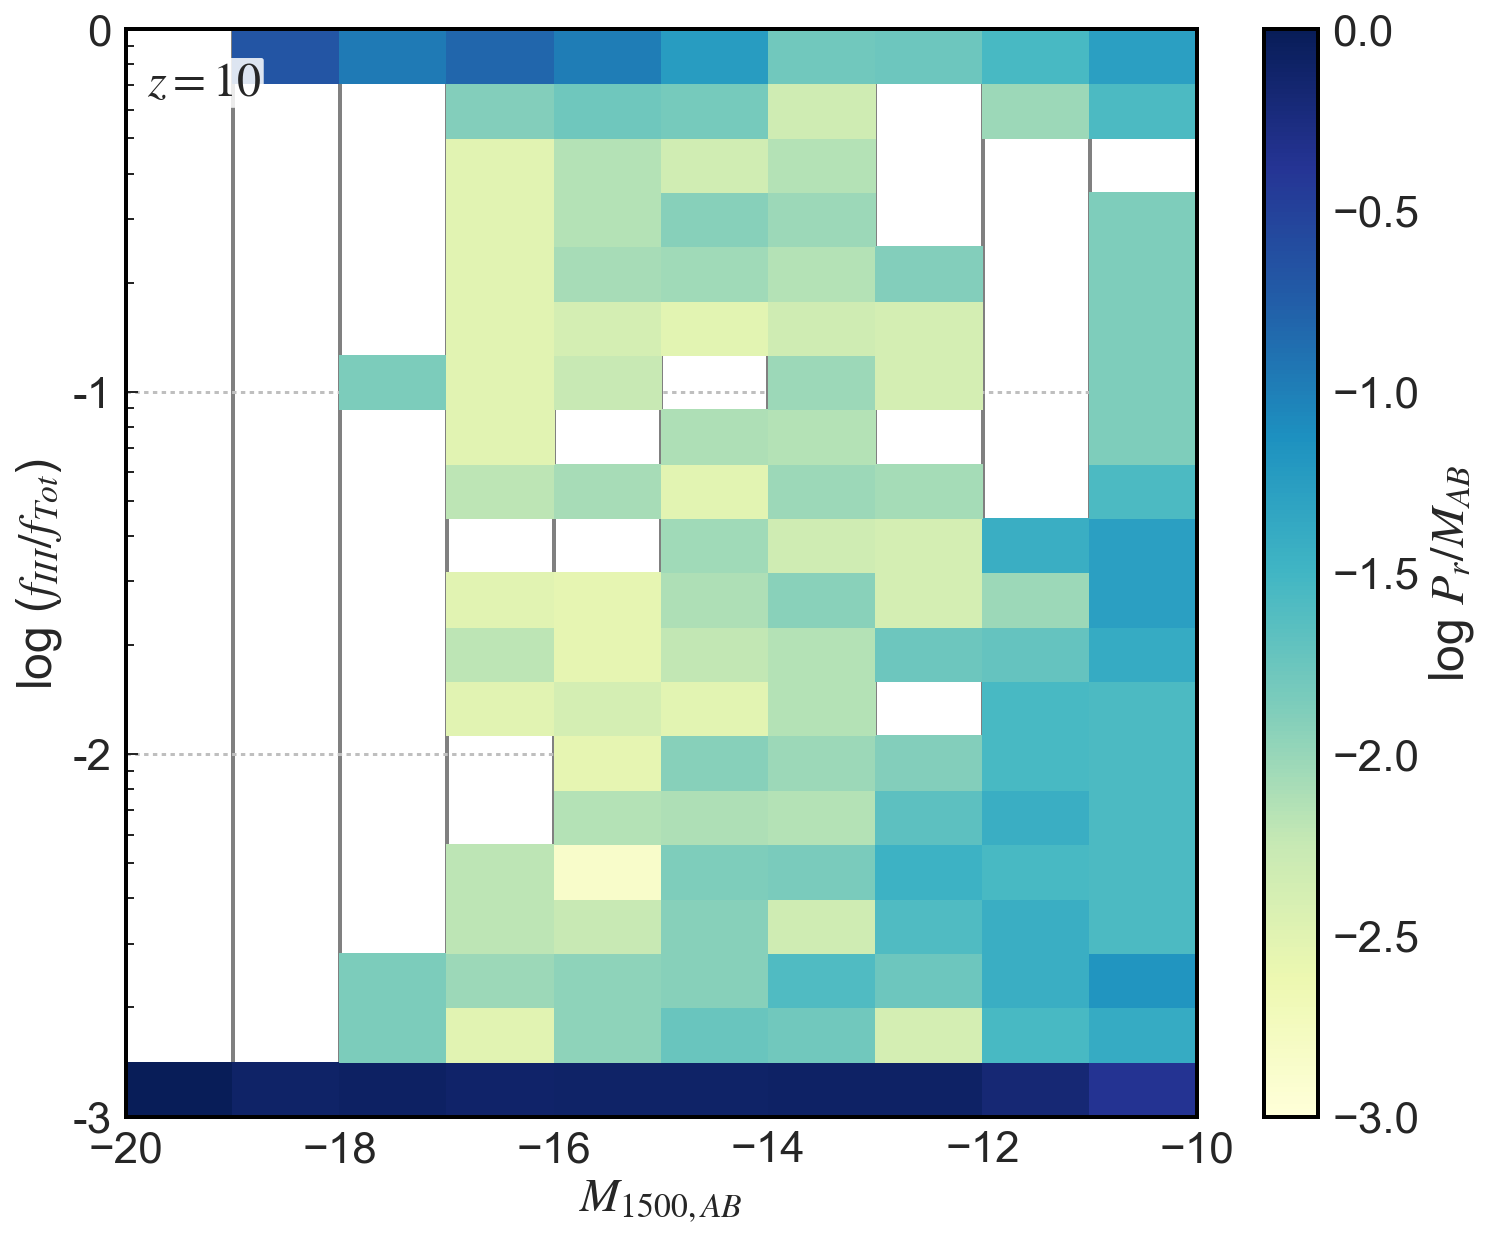

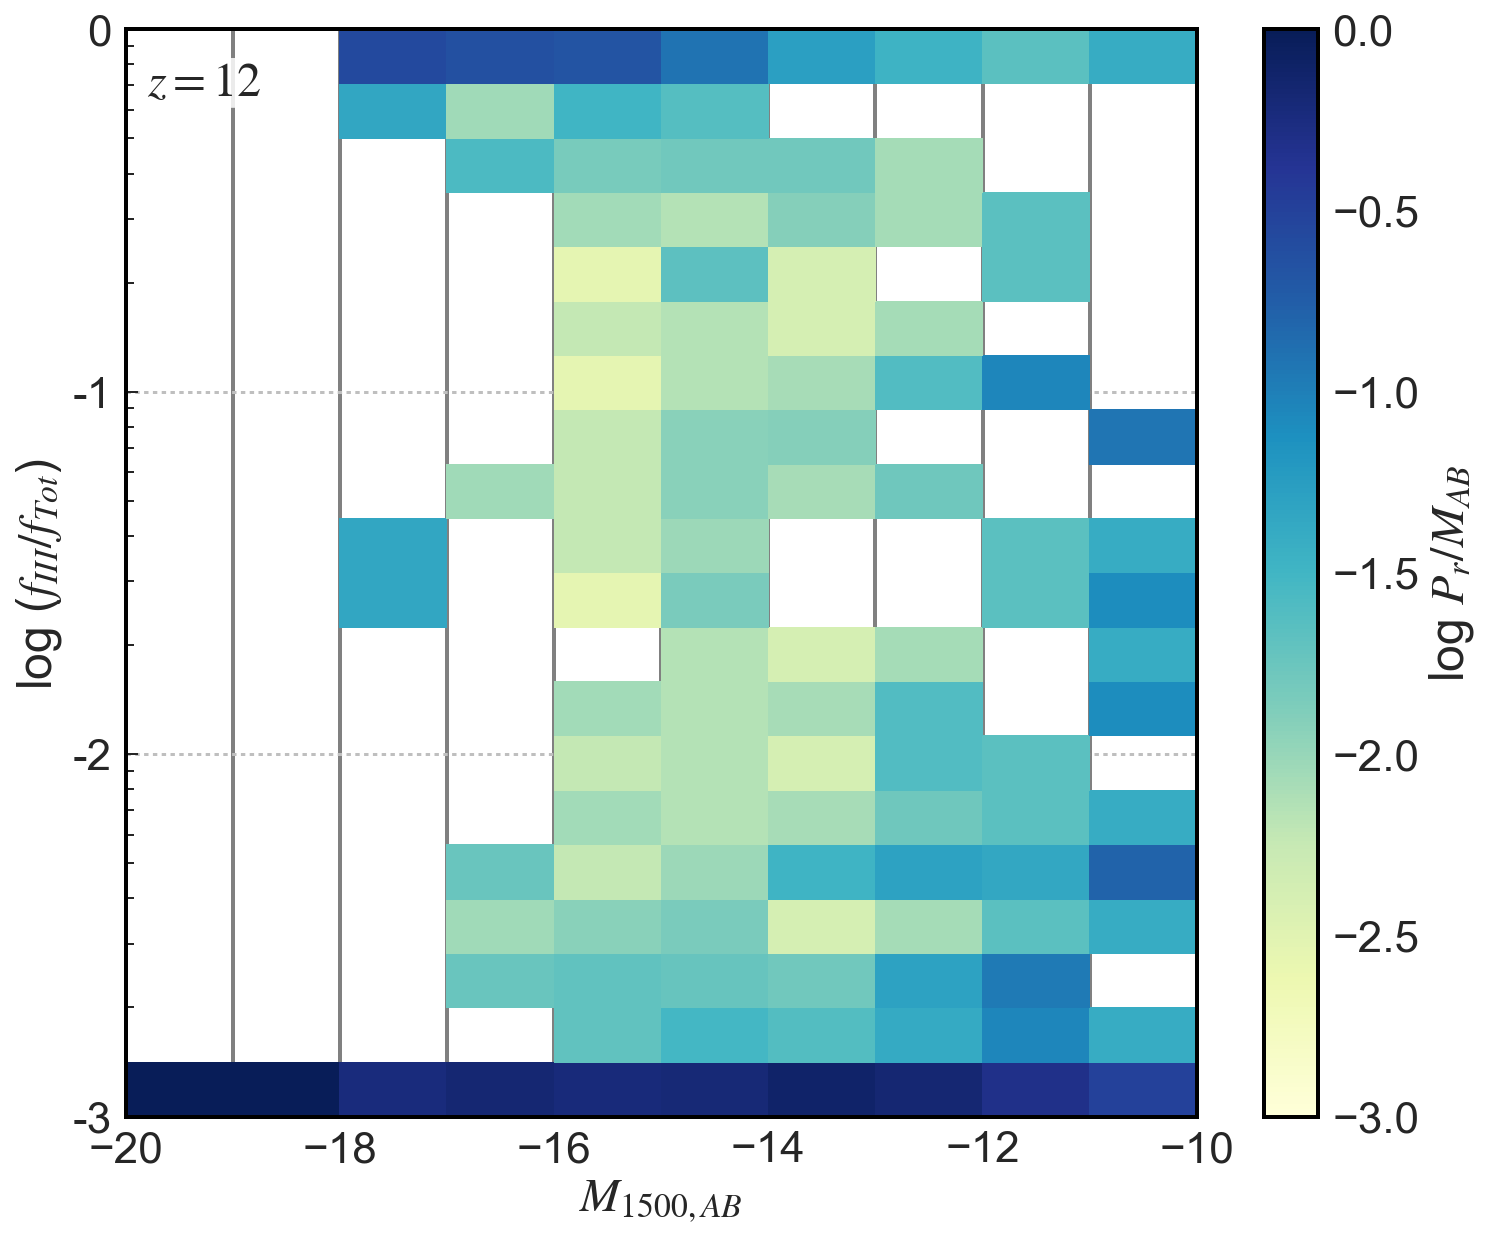

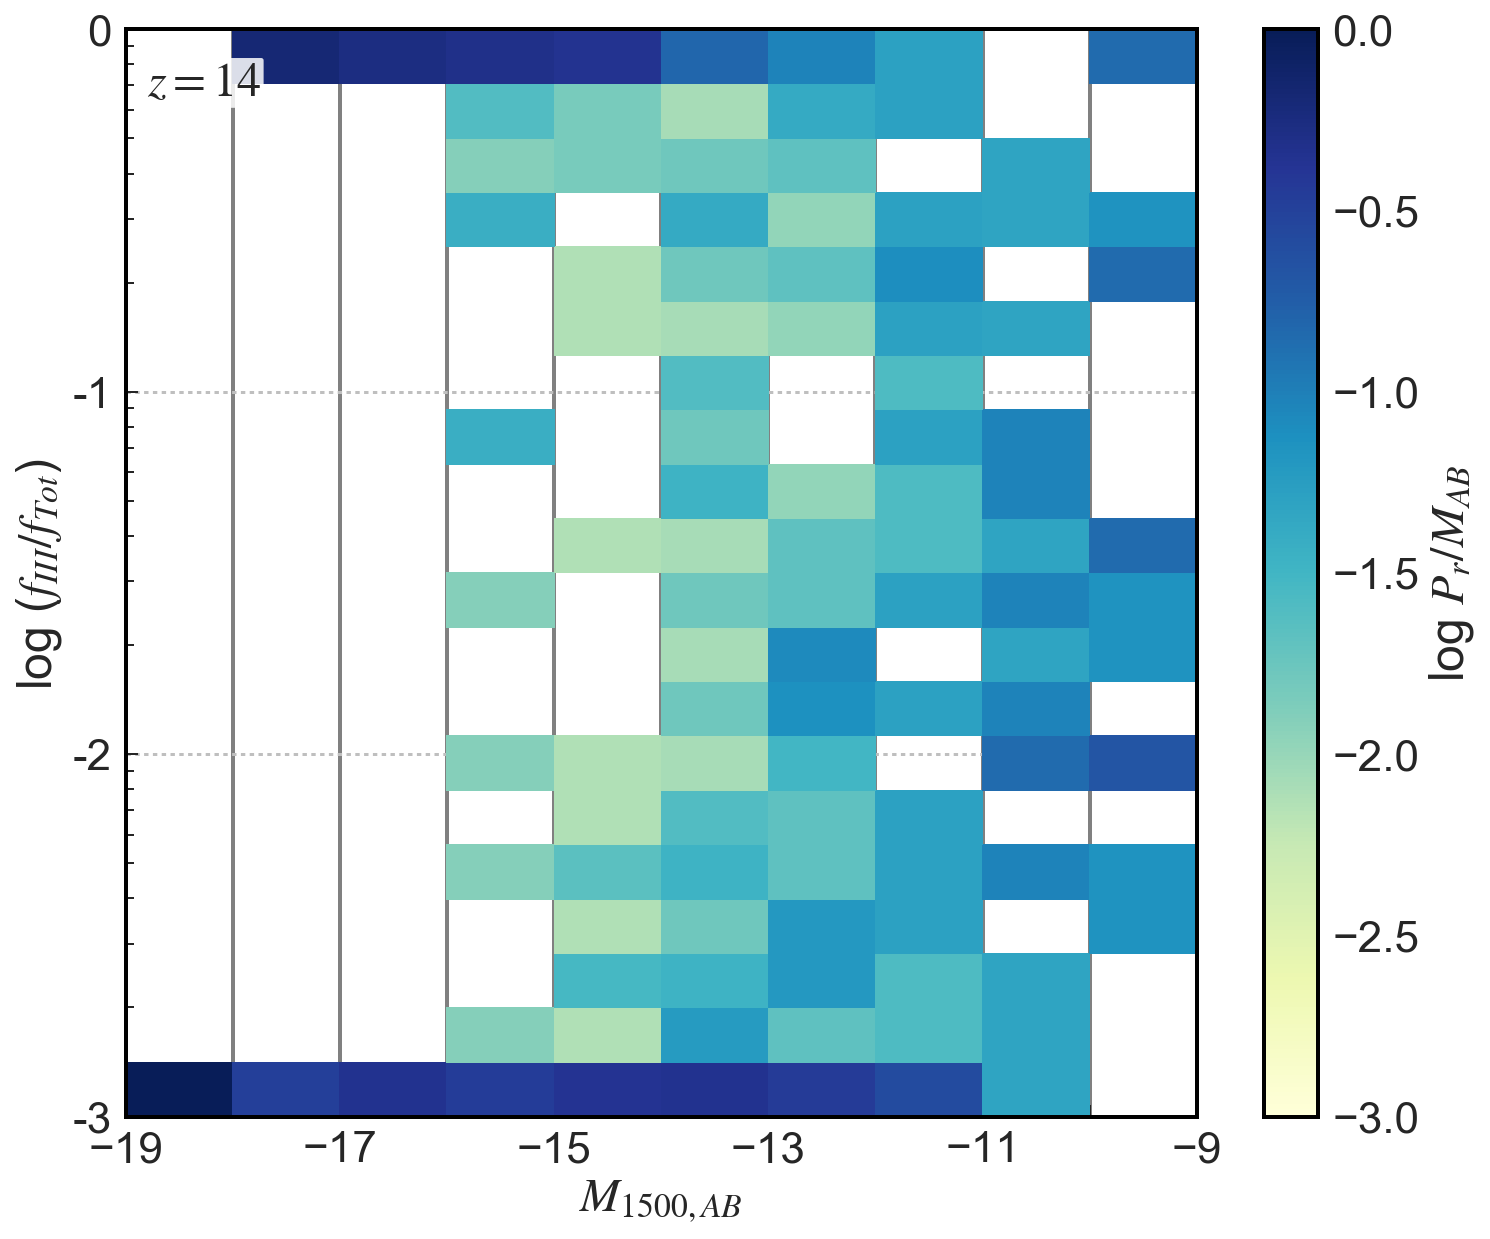

In [66]:
# Normalize the probability in each row such that it totals to 1.0

sns.set(style="whitegrid", font_scale=2, color_codes=True)
sns.set_style({'axes.edgecolor': '0.0','axes.linewidth': 2.0})

# Plot the fraction of Pop III magnitude vs M_AB NORMALIZED...

rgForSFunc = np.arange(brightM,limitM, 0.1)

for z in np.sort([8,9,10,11,12,13,14,15,16]):
#for z in np.sort([12,13,14,15,16]):
    fig      = plt.figure(figsize=(12, 10))
    ax       = plt.axes()

    # Convert observed magnitude to Absolute ...
    absMag, pop3Mag, nmAbsMag   = compMags(z)
    # Map 0 Pop 3 flux to 1e-3... 
    pop3Fraction                      = fluxes[z]['1500A_P3']/fluxes[z]['1500A']
    print("Pop III flux fraction is {:.5f} at z={}".format(fluxes[z]['1500A_P3'].sum()/fluxes[z]['1500A'].sum(),z))
    pop3Fraction[pop3Fraction < 1e-3] = 1e-3  # Map Pop 3 flux < 1e-3 to 1e-3
    
    brightM = np.floor(absMag.min())
    print(brightM)
    limitM  = brightM+10
    magBins = np.linspace(brightM,limitM,(-brightM+limitM)*1 + 1) 
    fracBins = np.logspace(-3,0,(-brightM+limitM)*2 + 1)
    print("Limiting absolute magnitude: {}".format(limitM))

    
    Ng = len(absMag) # Number of galaxies at this z
    print("Number of galaxies {}".format(Ng))
    # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
    # both the improved Pop III luminosity and the classical

    # Note that we are reversing x,y here since pcolormesh interprets them backwards!
    nTempA, binsx, binsy = np.histogram2d(pop3Fraction,absMag,bins=[fracBins,magBins],normed=False)
    # could use weights=[1/simVol for i in absMag] to normalize by vol here... 
    # normed : bool, optional
    #        If False, returns the number of samples in each bin. If True, returns the bin density 
    #        bin_count / sample_count / bin_area.

    X, Y = np.meshgrid(magBins, fracBins)  # Create a grid over the range of bins for the plot

    # Mask out 0 values before taking log10... 
    H = np.ma.masked_where(nTempA==0.0, nTempA)
    dx = np.diff(magBins)
    dy = np.diff(fracBins) 
    area = dx[:,None] * dy # compute the area of each bin using broadcasting
    #H = masked_array
#     H = H/area.T  # Divide out bin area ### DO NOT DIV BIN AREA WHEN DEALING WITH PROB/Mag bin
    for i in range(len(H[0,:])):     # Column index i, over len of row 0
        colTot = np.sum(H[:,i])
        for j in range(len(H[:,0])): # Row index j, over len of column 0
            H[:,i][j] = H[:,i][j]/colTot
    H = np.log10(H)        # Take log of counts, we've already normalized by volume and area
    print("Largest bin value: {:.3f}, smallest {}".format(H.max(),H.min()))
    # Create the plot
    cax = (ax.pcolormesh(X, Y, H, cmap=mpl.cm.YlGnBu, vmin=-3, vmax=0) )
#     cax = (ax.pcolormesh(X, Y, H, cmap=mpl.cm.YlGnBu) )
    
    # Create the colorbar
    cbar = fig.colorbar(cax)
    cbar.ax.tick_params(labelsize=22) 
    #cbar.ax.set_yticklabels(['1', '2', '4', '6', '10', maxCV], size=24)
    cbar.set_label("log $P_r/M_{AB}$",fontsize=24)

    ax.set_xscale('linear')
    ax.set_yscale('log')
    ax.yaxis.set_tick_params(which='major',width=1,length=6)
    ax.yaxis.set_tick_params(which='minor',width=1,length=4)
    ax.xaxis.set_tick_params(which='both',width=1,length=6)
    ax.xaxis.set_ticks(np.arange(brightM,limitM+1, 2))
    minorLocator = ticker.MultipleLocator(1)
    ax.xaxis.set_minor_locator(minorLocator)
    ax.get_yaxis().set_tick_params(which='both', direction='in',labelsize=22)
    ax.get_xaxis().set_tick_params(which='both', direction='in',labelsize=22)
    ax.yaxis.set_major_formatter(logfmt)
    ax.set_xlim([brightM,limitM])
    ax.set_xlabel('$M_{1500,AB}$',fontsize=24)
    ax.set_ylabel(r'log ($f_{III}/f_{Tot}$)',fontsize=24)
    ax.grid(which='major', axis='y', color='0.75', linestyle=':', linewidth=1.5)
    ax.grid(which='both', axis='x', color='0.5', linestyle='-', linewidth=2.0)

    #     ax.xaxis.set_ticklabels([str (i) for i in np.arange(brightM,limitM, 1)])

    # plt.gca().invert_xaxis()
    gc.collect()
    
    ax.annotate('$z={}$'.format(z), xy = (0.5, 0.5), xytext = (0.02, 0.93), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.85},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=24)
    
  
    plt.savefig("PopIII_fraction_{}-Histograms-PerMNormed-2.pdf".format(z),dpi=fig.dpi,bbox_inches='tight')

gc.collect()

Pop III flux fraction is 0.05545 at z=8
25.0
Limiting absolute magnitude: 35.0
Number of galaxies 9199
Largest bin value: 0.000, smallest -3.0549958615291417


/Users/earnric/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:54: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


Pop III flux fraction is 0.30985 at z=9
26.0
Limiting absolute magnitude: 36.0
Number of galaxies 3831
Largest bin value: 0.000, smallest -2.9740509027928774
Pop III flux fraction is 0.11879 at z=10
27.0
Limiting absolute magnitude: 37.0
Number of galaxies 2667
Largest bin value: 0.000, smallest -2.7611758131557314
Pop III flux fraction is 0.17830 at z=11
28.0
Limiting absolute magnitude: 38.0
Number of galaxies 1943
Largest bin value: 0.000, smallest -2.578639209968072
Pop III flux fraction is 0.21308 at z=12
28.0
Limiting absolute magnitude: 38.0
Number of galaxies 1365
Largest bin value: 0.000, smallest -2.6020599913279625
Pop III flux fraction is 0.33895 at z=13
30.0
Limiting absolute magnitude: 40.0
Number of galaxies 889
Largest bin value: -0.237, smallest -2.3483048630481607
Pop III flux fraction is 0.44895 at z=14
29.0
Limiting absolute magnitude: 39.0
Number of galaxies 531
Largest bin value: 0.000, smallest -2.1335389083702174
Pop III flux fraction is 0.51713 at z=15
30.0
Lim

0

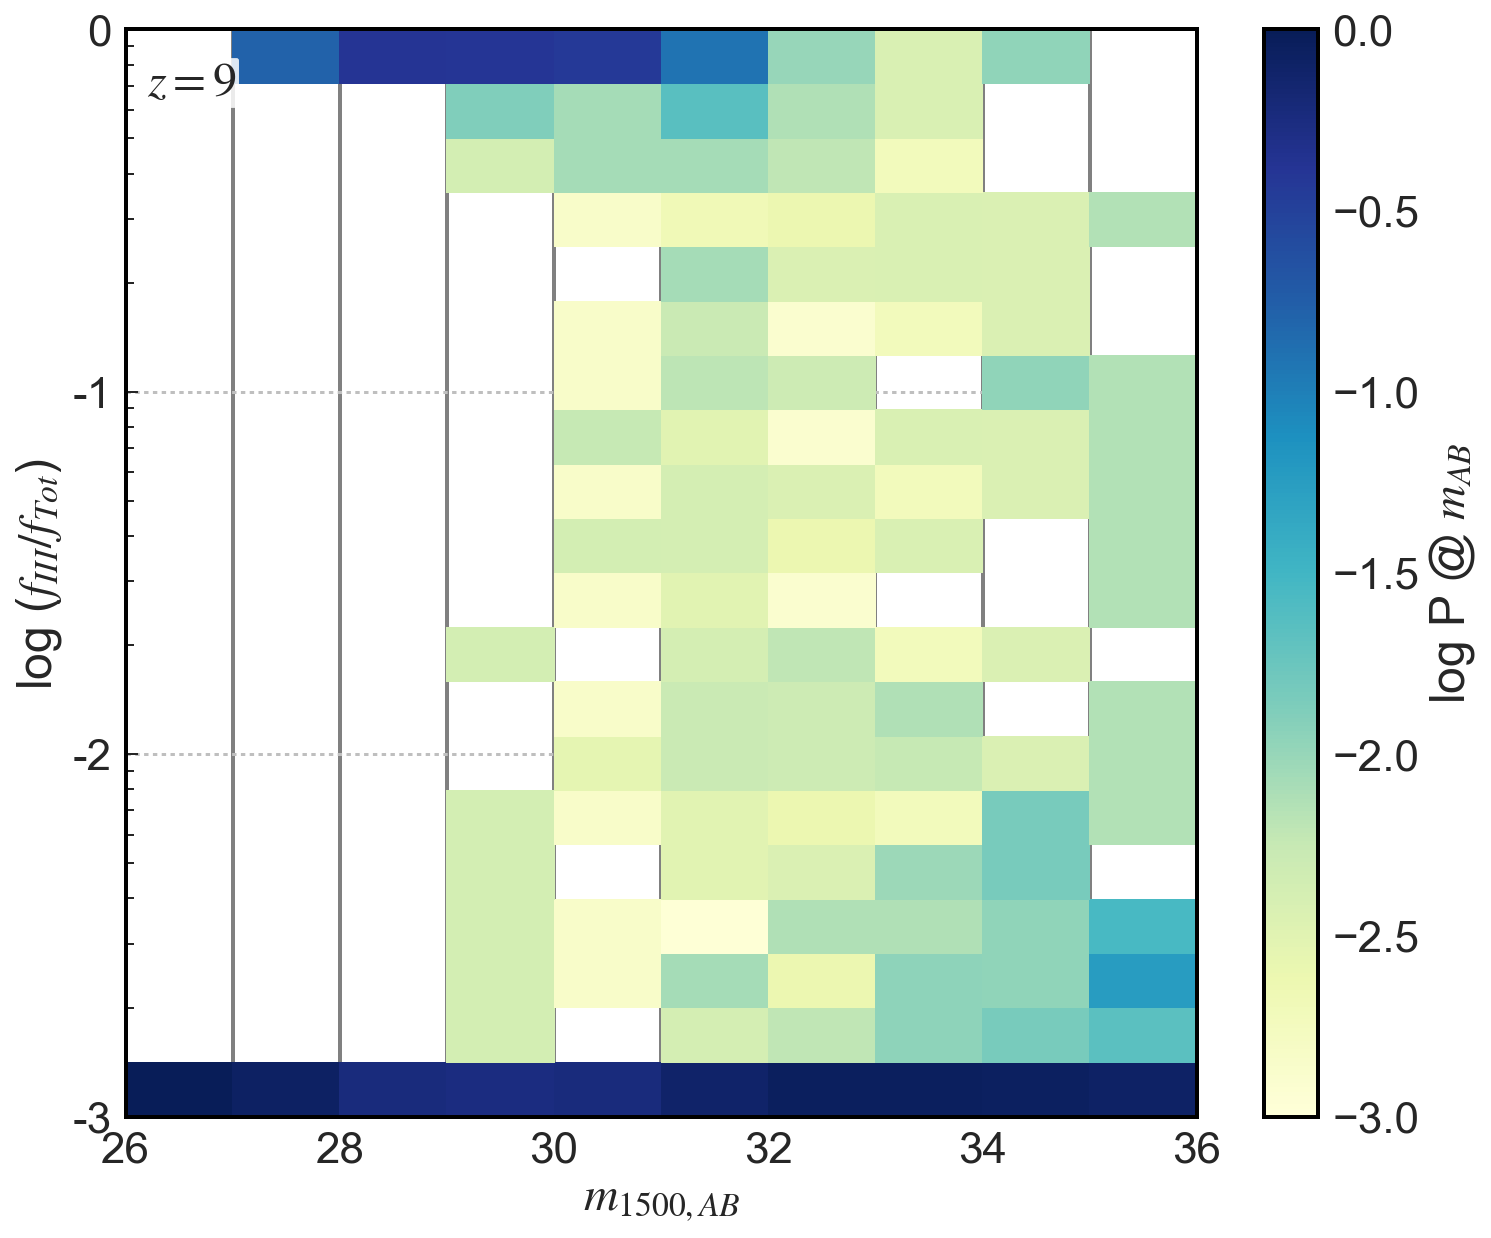

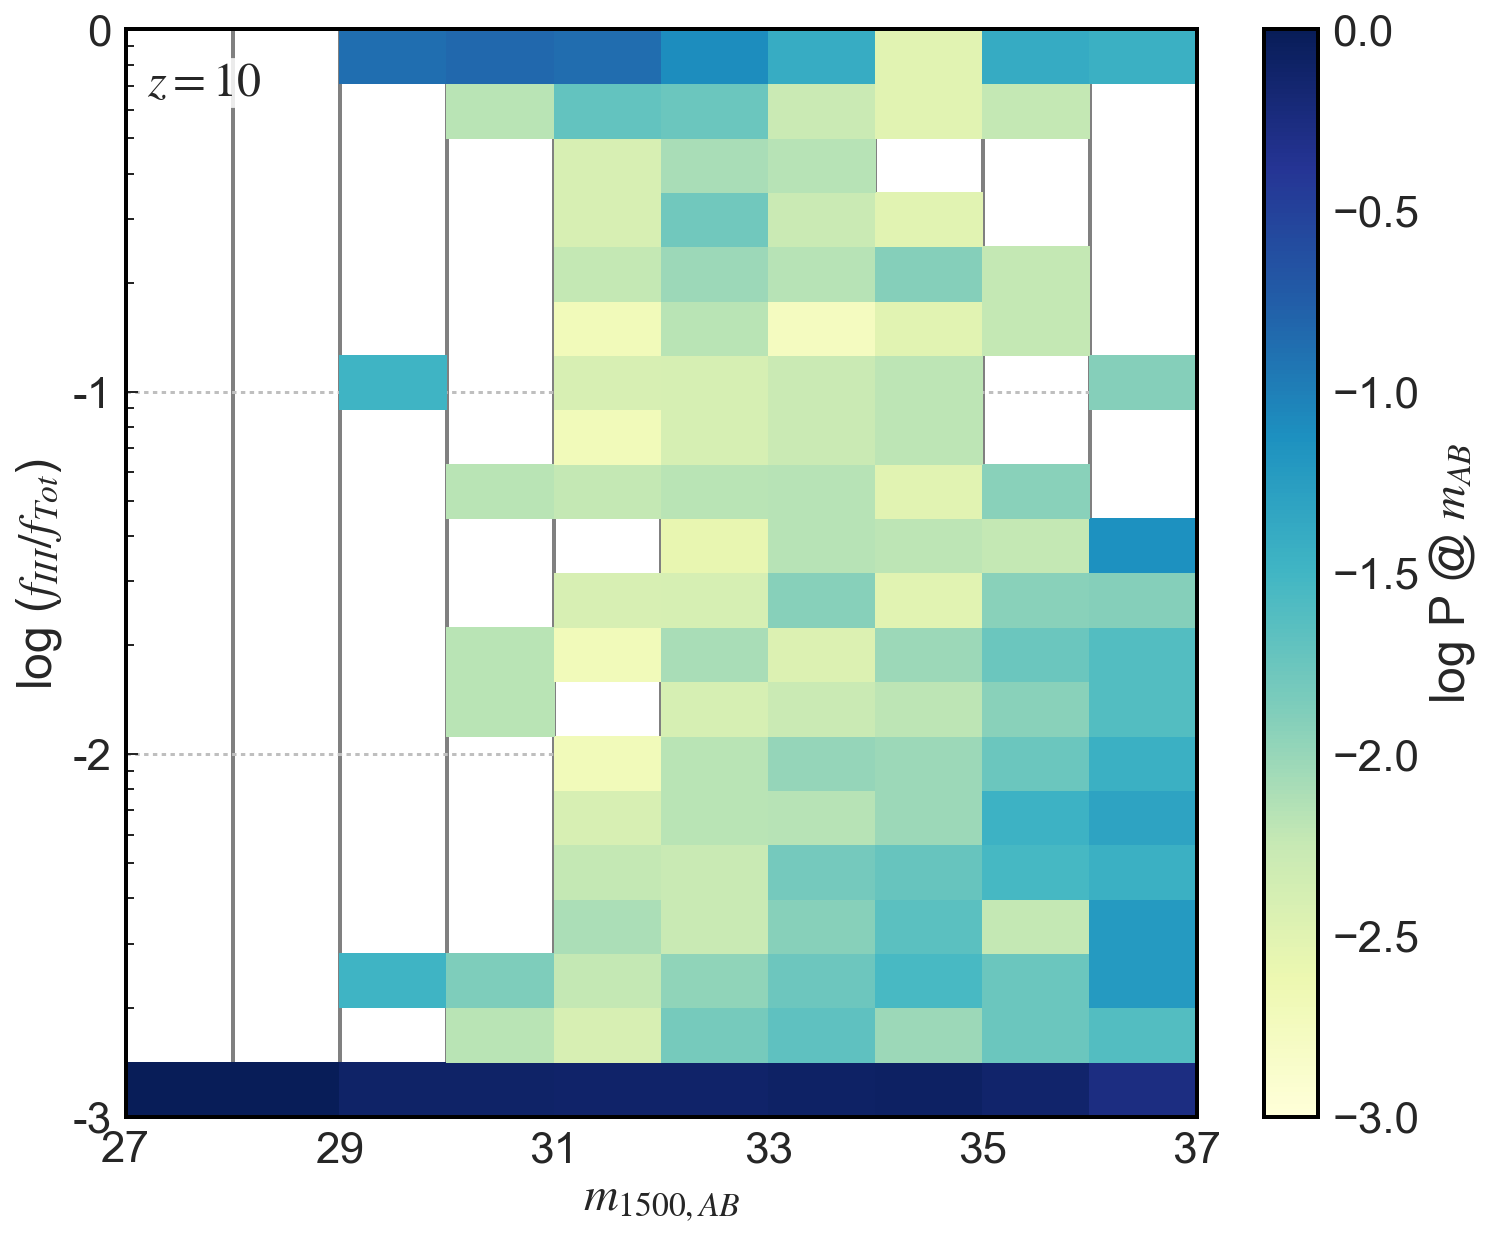

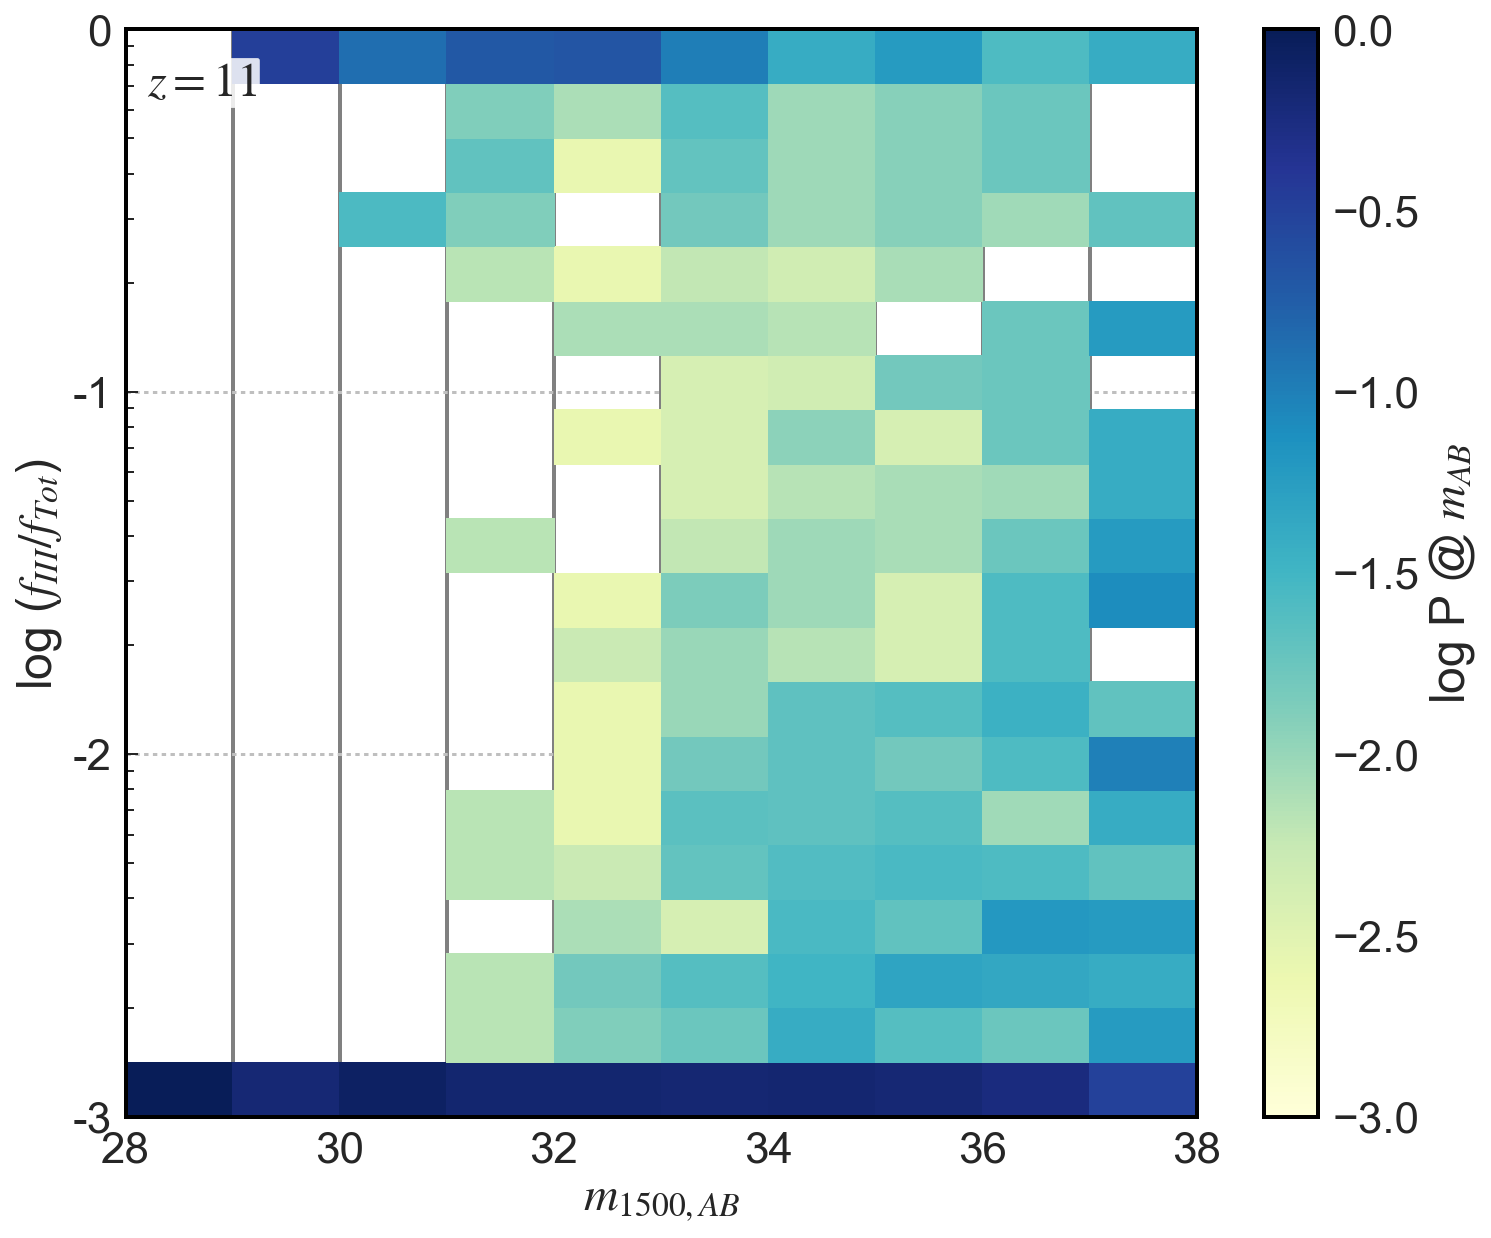

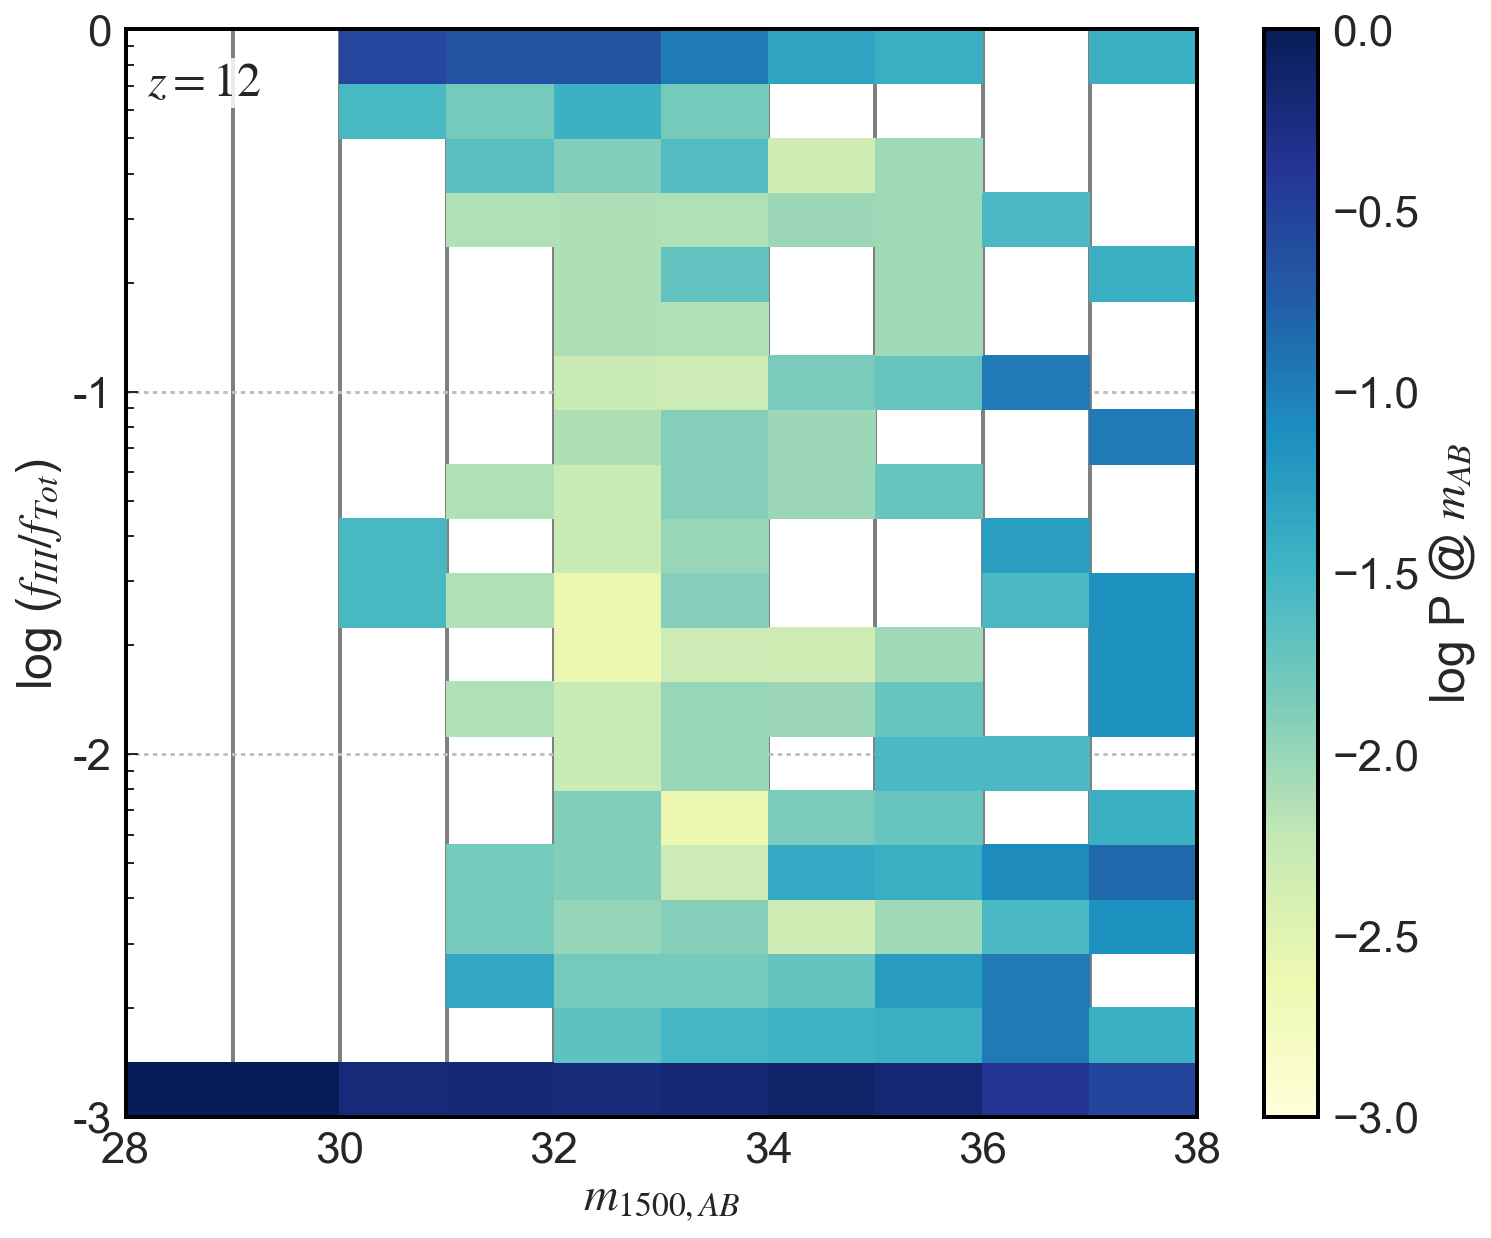

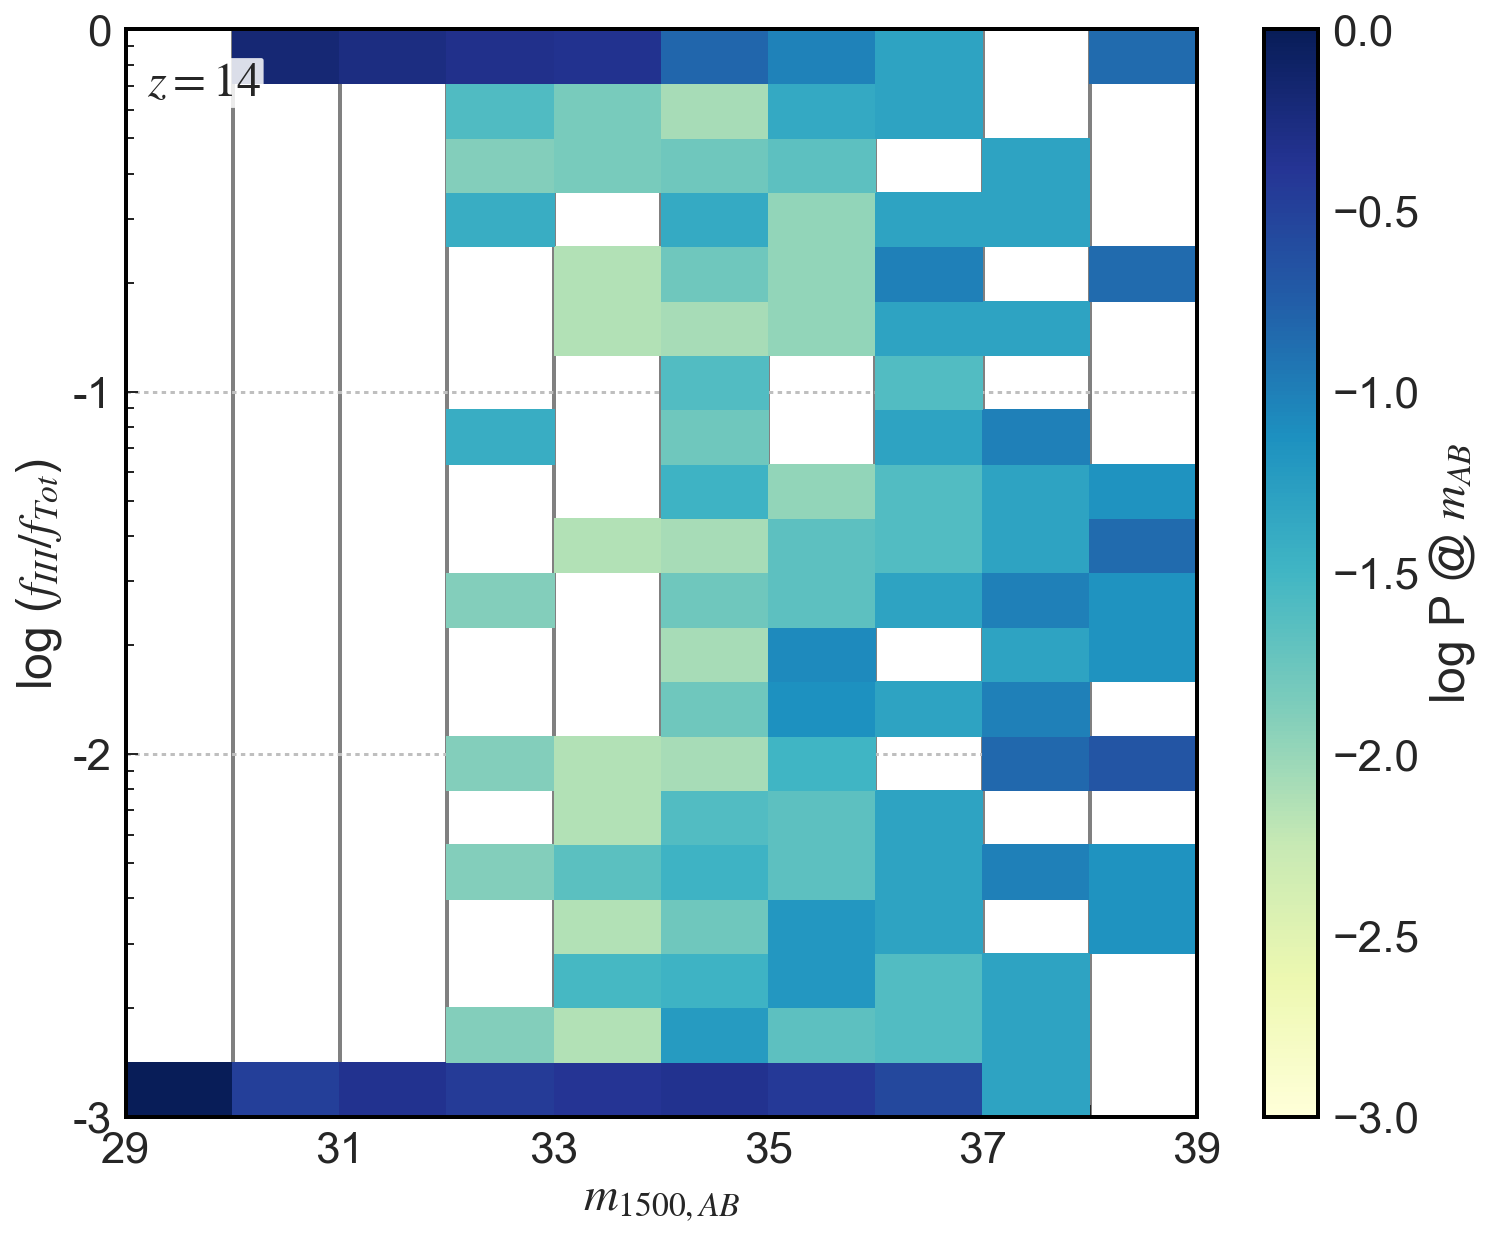

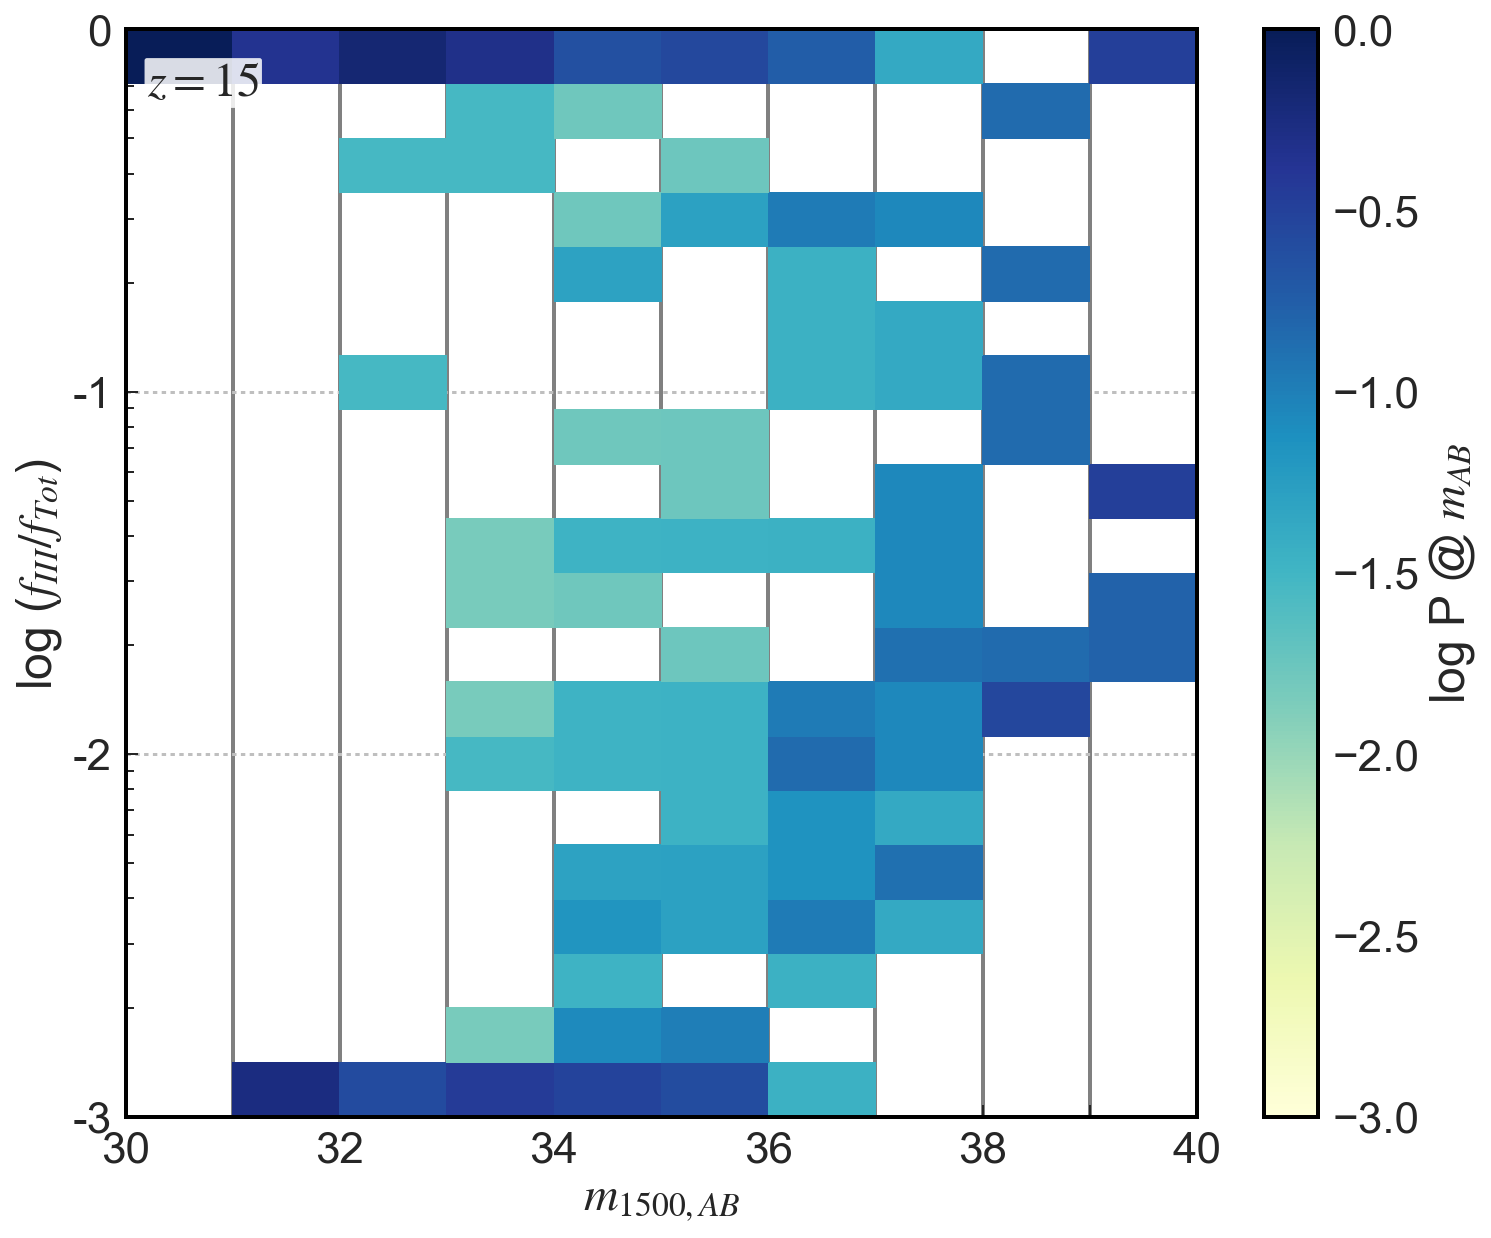

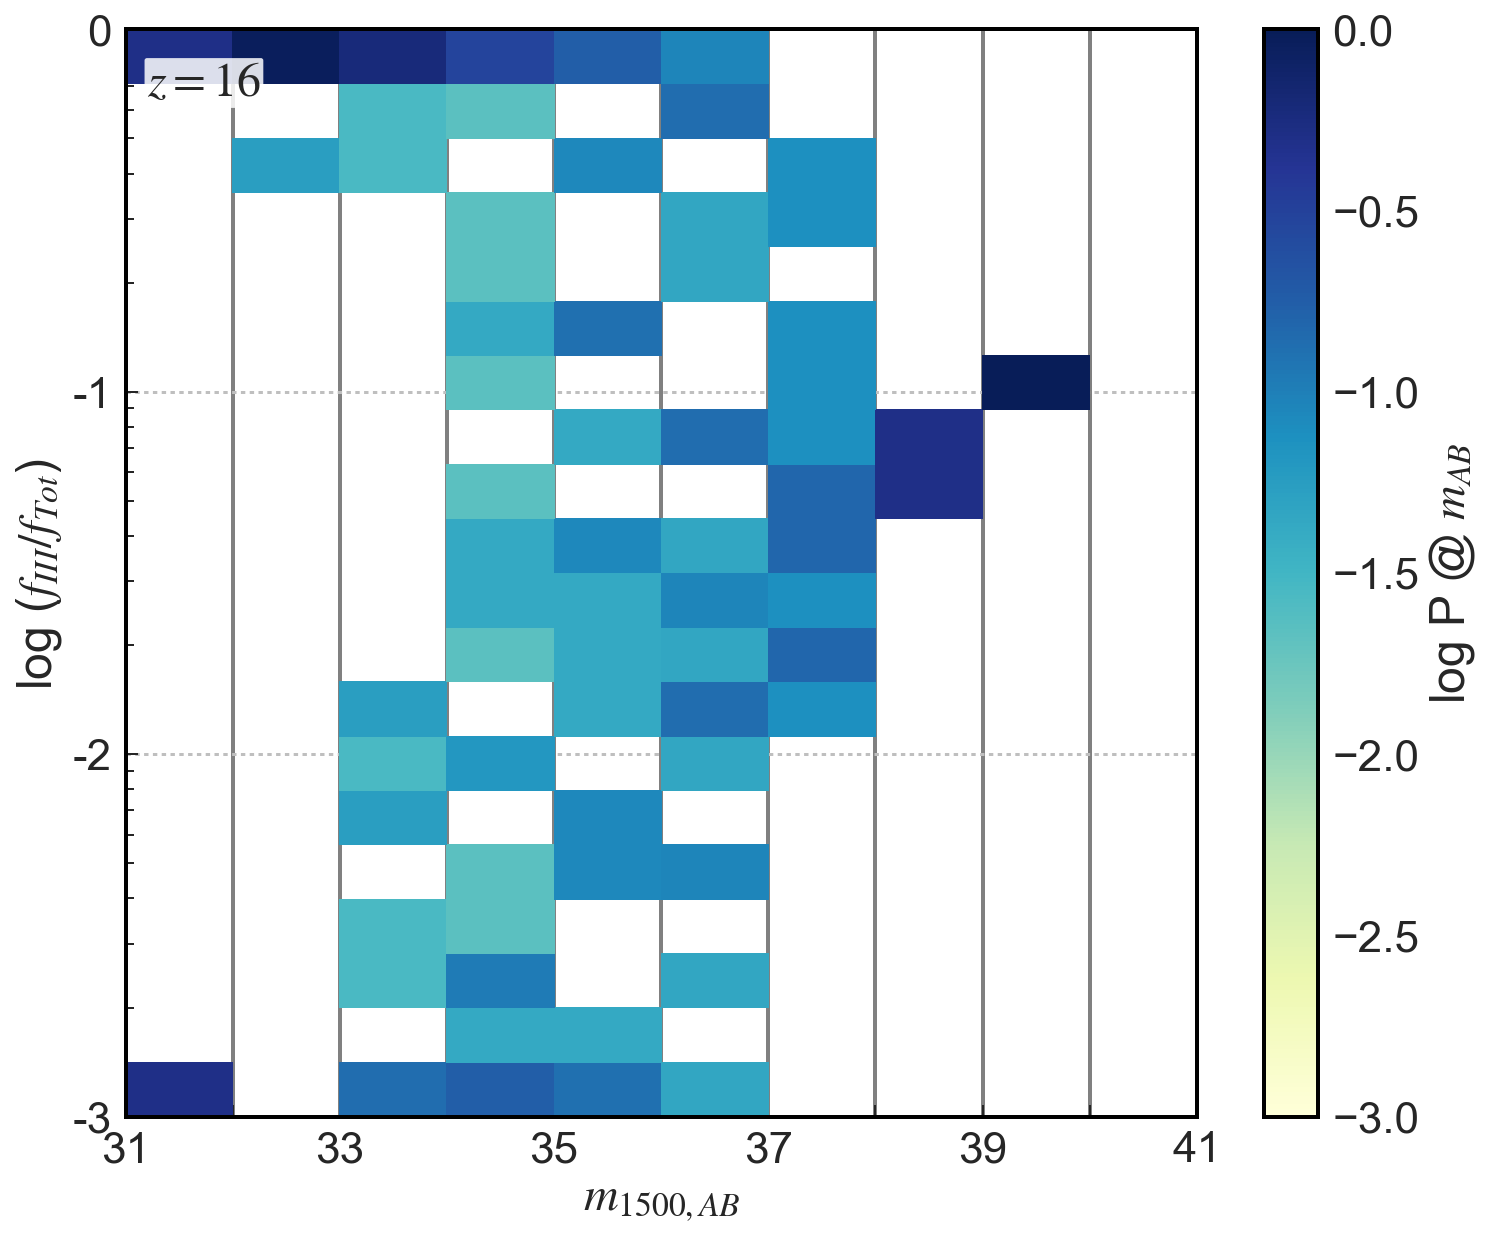

In [70]:
# Normalize the probability in each row such that it totals to 1.0

sns.set(style="whitegrid", font_scale=2, color_codes=True)
sns.set_style({'axes.edgecolor': '0.0','axes.linewidth': 2.0})

# Plot the fraction of Pop III magnitude vs M_AB NORMALIZED...

rgForSFunc = np.arange(brightM,limitM, 0.1)

for z in np.sort([8,9,10,11,12,13,14,15,16]):
#for z in np.sort([12,13,14,15,16]):
    fig      = plt.figure(figsize=(12, 10))
    ax       = plt.axes()

    # Convert observed magnitude to Absolute ...
    obsMag   = mag(fluxes[z]['1500A'])
    # Map 0 Pop 3 flux to 1e-3... 
    pop3Fraction                      = fluxes[z]['1500A_P3']/fluxes[z]['1500A']
    print("Pop III flux fraction is {:.5f} at z={}".format(fluxes[z]['1500A_P3'].sum()/fluxes[z]['1500A'].sum(),z))
    pop3Fraction[pop3Fraction < 1e-3] = 1e-3  # Map Pop 3 flux < 1e-3 to 1e-3
    
    brightM = np.floor(obsMag.min())
    print(brightM)
    limitM  = brightM+10
    magBins = np.linspace(brightM,limitM,(-brightM+limitM)*1 + 1) 
    fracBins = np.logspace(-3,0,(-brightM+limitM)*2 + 1)
    print("Limiting absolute magnitude: {}".format(limitM))

    
    Ng = len(obsMag) # Number of galaxies at this z
    print("Number of galaxies {}".format(Ng))
    # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
    # both the improved Pop III luminosity and the classical

    # Note that we are reversing x,y here since pcolormesh interprets them backwards!
    nTempA, binsx, binsy = np.histogram2d(pop3Fraction,obsMag,bins=[fracBins,magBins],normed=False)
    # could use weights=[1/simVol for i in obsMag] to normalize by vol here... 
    # normed : bool, optional
    #        If False, returns the number of samples in each bin. If True, returns the bin density 
    #        bin_count / sample_count / bin_area.

    X, Y = np.meshgrid(magBins, fracBins)  # Create a grid over the range of bins for the plot

    # Mask out 0 values before taking log10... 
    H = np.ma.masked_where(nTempA==0.0, nTempA)
    dx = np.diff(magBins)
    dy = np.diff(fracBins) 
    area = dx[:,None] * dy # compute the area of each bin using broadcasting
    #H = masked_array
#     H = H/area.T  # Divide out bin area ### DO NOT DIV BIN AREA WHEN DEALING WITH PROB/Mag bin
    for i in range(len(H[0,:])):     # Column index i, over len of row 0
        colTot = np.sum(H[:,i])
        for j in range(len(H[:,0])): # Row index j, over len of column 0
            H[:,i][j] = H[:,i][j]/colTot
    H = np.log10(H)        # Take log of counts, we've already normalized by volume and area
    print("Largest bin value: {:.3f}, smallest {}".format(H.max(),H.min()))
    # Create the plot
    cax = (ax.pcolormesh(X, Y, H, cmap=mpl.cm.YlGnBu, vmin=-3, vmax=0) )
#     cax = (ax.pcolormesh(X, Y, H, cmap=mpl.cm.YlGnBu) )
    
    # Create the colorbar
    cbar = fig.colorbar(cax)
    cbar.ax.tick_params(labelsize=22) 
    #cbar.ax.set_yticklabels(['1', '2', '4', '6', '10', maxCV], size=24)
    cbar.set_label("log P @ $m_{AB}$",fontsize=24)

    ax.set_xscale('linear')
    ax.set_yscale('log')
    ax.yaxis.set_tick_params(which='major',width=1,length=6)
    ax.yaxis.set_tick_params(which='minor',width=1,length=4)
    ax.xaxis.set_tick_params(which='both',width=1,length=6)
    ax.xaxis.set_ticks(np.arange(brightM,limitM+1, 2))
    minorLocator = ticker.MultipleLocator(1)
    ax.xaxis.set_minor_locator(minorLocator)
    ax.get_yaxis().set_tick_params(which='both', direction='in',labelsize=22)
    ax.get_xaxis().set_tick_params(which='both', direction='in',labelsize=22)
    ax.yaxis.set_major_formatter(logfmt)
    ax.set_xlim([brightM,limitM])
    ax.set_xlabel('$m_{1500,AB}$',fontsize=24)
    ax.set_ylabel(r'log ($f_{III}/f_{Tot}$)',fontsize=24)
    ax.grid(which='major', axis='y', color='0.75', linestyle=':', linewidth=1.5)
    ax.grid(which='both', axis='x', color='0.5', linestyle='-', linewidth=2.0)

    #     ax.xaxis.set_ticklabels([str (i) for i in np.arange(brightM,limitM, 1)])

    # plt.gca().invert_xaxis()
    gc.collect()
    
    ax.annotate('$z={}$'.format(z), xy = (0.5, 0.5), xytext = (0.02, 0.93), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.85},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=24)
    
  
#     plt.savefig("PopIII_fraction_{}-Histograms-PerMNormed-2.pdf".format(z),dpi=fig.dpi,bbox_inches='tight')

gc.collect()

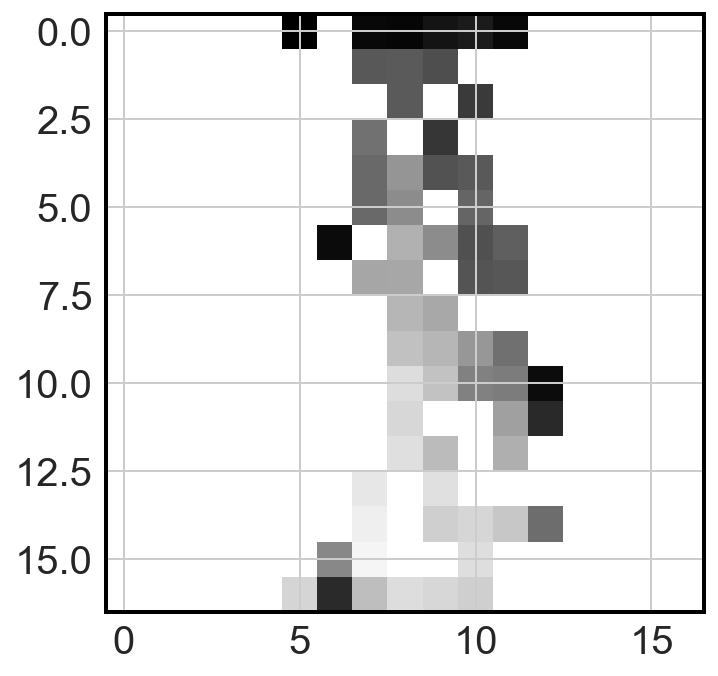

In [37]:
plt.imshow(H)

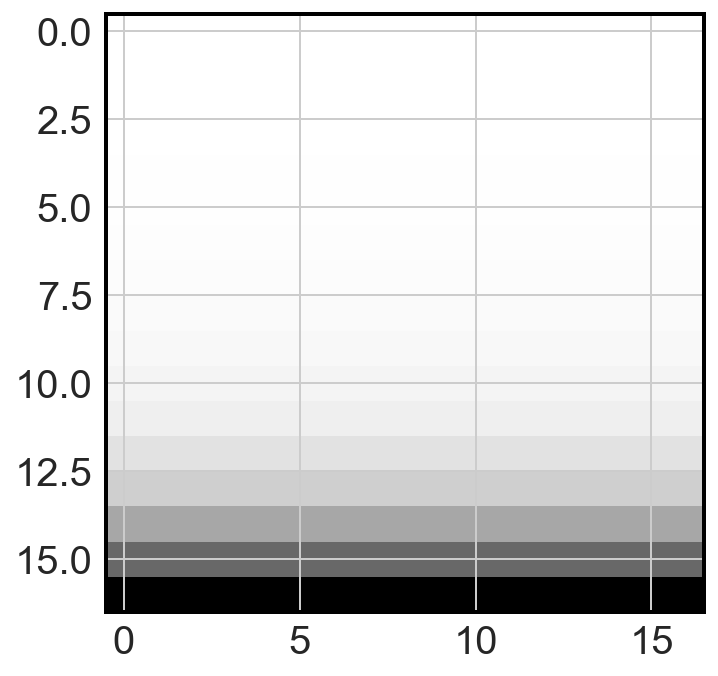

In [38]:
plt.imshow(area.T)

In [155]:
H.shape,len(H[:,0]),len(H[0,:])

((4, 9), 4, 9)

In [68]:
np.logspace(-3,0.0,16),np.linspace(1e-3,1,18)

(array([ 0.001     ,  0.00158489,  0.00251189,  0.00398107,  0.00630957,
         0.01      ,  0.01584893,  0.02511886,  0.03981072,  0.06309573,
         0.1       ,  0.15848932,  0.25118864,  0.39810717,  0.63095734,  1.        ]),
 array([ 0.001     ,  0.05976471,  0.11852941,  0.17729412,  0.23605882,
         0.29482353,  0.35358824,  0.41235294,  0.47111765,  0.52988235,
         0.58864706,  0.64741176,  0.70617647,  0.76494118,  0.82370588,
         0.88247059,  0.94123529,  1.        ]))

Limiting absolute magnitude: -13
Convert to Abs Mag. DM = 47.20 @ z=8.0
Pop III flux fraction is 0.06457 at z=8
Number of galaxies 9417
Largest bin value: 0.000, smallest -5.00841899469


/Users/earnric/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/Users/earnric/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:58: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/Users/earnric/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:59: RuntimeWarning: divide by zero encountered in log10


Convert to Abs Mag. DM = 47.38 @ z=9.0
Pop III flux fraction is 0.31201 at z=9
Number of galaxies 3872
Largest bin value: 0.000, smallest -5.1431106781
Convert to Abs Mag. DM = 47.54 @ z=10.0
Pop III flux fraction is 0.12048 at z=10
Number of galaxies 2651
Largest bin value: 0.000, smallest -4.88808070226
Convert to Abs Mag. DM = 47.68 @ z=11.0
Pop III flux fraction is 0.19452 at z=11
Number of galaxies 2030
Largest bin value: 0.000, smallest -4.48422772857
Convert to Abs Mag. DM = 47.80 @ z=12.0
Pop III flux fraction is 0.21308 at z=12
Number of galaxies 1365
Largest bin value: 0.000, smallest -4.54627923603
Convert to Abs Mag. DM = 48.03 @ z=14.0
Pop III flux fraction is 0.44895 at z=14
Number of galaxies 531
Largest bin value: 0.000, smallest -4.1384508689
Convert to Abs Mag. DM = 48.12 @ z=15.0
Pop III flux fraction is 0.51713 at z=15
Number of galaxies 294
Largest bin value: -0.001, smallest -4.07828498997
Convert to Abs Mag. DM = 48.21 @ z=16.0
Pop III flux fraction is 0.64508 at

356

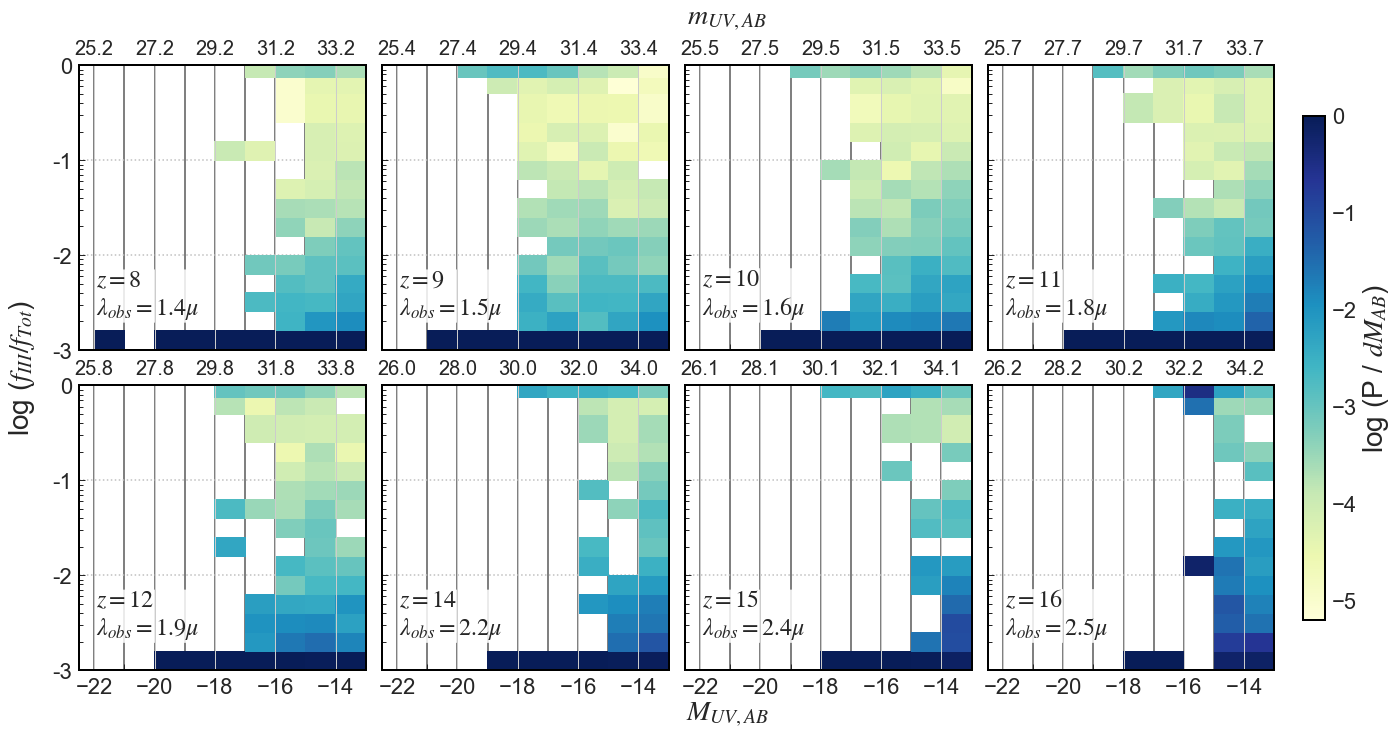

In [19]:
# Normalize the probability in each row such that it totals to 1.0

sns.set(style="whitegrid", font_scale=2, color_codes=True)
sns.set_style({'axes.edgecolor': '0.0','axes.linewidth': 2.0})

# Plot the fraction of Pop III magnitude vs M_AB NORMALIZED...

brightM = -22
limitM  = brightM+9
rgForSFunc = np.arange(brightM,limitM, 0.1)

magBins = np.linspace(brightM,limitM,(-brightM+limitM)*1 + 1) 
fracBins = np.logspace(-3,0,23)
# Contrived bin spacing such that the top bin represents .75-1.0 Pop III fraction
# and the next bin down represents .5-0.75 ...
fracBins = [0.001,  0.00158489,  0.00251189,  0.00398107,  0.00630957,
             0.01,  0.01584893,  0.02511886,  0.03981072,  0.06309573,
             0.1,  0.15848932,  0.25118864,
             0.5,   0.75,   1.0]
# fracBins = np.linspace(1e-3,9e-3,9).tolist() +np.linspace(1e-2,9e-2,9).tolist() +np.linspace(1e-1,1e-0,9).tolist()
print("Limiting absolute magnitude: {}".format(limitM))

fig, axs = plt.subplots(nrows=2, ncols=4, sharex='col',sharey='row',figsize=(20,10))
for z,ax in zip(np.sort([8,9,10,11,12,14,15,16]), axs.flat):

    # Convert observed magnitude to Absolute ...
    absMag, pop3Mag, nmAbsMag   = compMags(z)
    # Map 0 Pop 3 flux to 1e-3... 
    pop3Fraction                      = fluxes[z]['1500A_P3']/fluxes[z]['1500A']
    print("Pop III flux fraction is {:.5f} at z={}".format(fluxes[z]['1500A_P3'].sum()/fluxes[z]['1500A'].sum(),z))
    pop3Fraction[pop3Fraction < 1e-3] = 1e-3  # Map Pop 3 flux < 1e-3 to 1e-3
    

    
    Ng = len(absMag) # Number of galaxies at this z
    print("Number of galaxies {}".format(Ng))
    # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
    # both the improved Pop III luminosity and the classical

    # Note that we are reversing x,y here since pcolormesh interprets them backwards!
    nTempA, binsx, binsy = np.histogram2d(pop3Fraction,absMag,bins=[fracBins,magBins],normed=False)
    # could use weights=[1/simVol for i in absMag] to normalize by vol here... 
    # normed : bool, optional
    #        If False, returns the number of samples in each bin. If True, returns the bin density 
    #        bin_count / sample_count / bin_area.

    X, Y = np.meshgrid(magBins, fracBins)  # Create a grid over the range of bins for the plot

    # Mask out 0 values before taking log10... 
    H = np.ma.masked_where(nTempA==0.0, nTempA)
    dx = np.diff(magBins)
    dy = np.diff(fracBins) 
    area = dx[:,None] * dy # compute the area of each bin using broadcasting
    H = H / area.T
    for i in range(len(H[0,:])):     # Column index i, over len of row 0
        colTot = np.sum(H[:,i])
        for j in range(len(H[:,0])): # Row index j, over len of column 0
            H[:,i][j] = H[:,i][j]/colTot
    H = np.log10(H)        # Take log of counts, we've already normalized by volume and area
    print("Largest bin value: {:.3f}, smallest {}".format(H.max(),H.min()))
    # Create the plot
    im = (ax.pcolormesh(X, Y, H, cmap=mpl.cm.YlGnBu, vmin=-5.2, vmax=0) )
#    im = (ax.pcolormesh(X, Y, H, cmap=mpl.cm.YlGnBu, vmin=-3, vmax=0) )
    
    ax.set_xscale('linear')
    ax.set_yscale('log')
    ax.yaxis.set_tick_params(which='major',width=1,length=6)
    ax.yaxis.set_tick_params(which='minor',width=1,length=4)
    ax.xaxis.set_tick_params(which='both',width=1,length=6)
    ax.xaxis.set_ticks(np.arange(brightM,limitM+1, 2))
    minorLocator = ticker.MultipleLocator(1)
    ax.xaxis.set_minor_locator(minorLocator)
    ax.get_yaxis().set_tick_params(which='both', direction='in',labelsize=22)
    ax.get_xaxis().set_tick_params(which='both', direction='in',labelsize=22)
    ax.yaxis.set_major_formatter(logfmt)
    ax.set_xlim([brightM-0.5,limitM])
    ax.set_ylim([1e-3,1.0])
    ax.grid(which='major', axis='y', color='0.75', linestyle=':', linewidth=1.5)
    ax.grid(which='both', axis='x', color='0.5', linestyle='-', linewidth=2.0)

    # Top x-axis labels ... m_ab
    ax2 = ax.twiny()
    ax2.set_xlim([brightM-0.5,limitM]) # required...
    axXtics = ax.get_xticks()
    ax2.set_xticks(axXtics)   # Set the location of the tics same as for ax
    ax2Xs = getMag(axXtics,z) # Convert M_ab -> m_ab
    ax2.set_xticklabels(["{:.1f}".format(i) for i in ax2Xs])
    ax2.get_xaxis().set_tick_params(labelsize=20)

    # plt.gca().invert_xaxis()
    gc.collect()
    
    ax.annotate('$z={}$\n$\lambda_{{obs}}={:.1f} \mu$'.format(z,1500*(1+z)/1e4), xy = (0.5, 0.5), 
                xytext = (0.06, 0.1), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.85},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=24)
    
    ## Include a line at 31st magnitude -- likely the limit for 

plt.subplots_adjust(left=0.05, bottom=0.08, right=.88, top=0.92, wspace=.057, hspace=.125)

fig.text(0.5, 0.977,'$m_{UV,AB}$', ha='center',size=28 )
fig.text(0.5, 0.01,'$M_{UV,AB}$', ha='center',size=28 )
fig.text(0.00, 0.5, r'log ($f_{III}/f_{Tot}$)',size=28,va='center', rotation='vertical')

# Create the colorbar
cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)

cbar.ax.tick_params(labelsize=22) 
#cbar.ax.set_yticklabels(['1', '2', '4', '6', '10', maxCV], size=24)
cbar.set_label("log (P / $dM_{AB}$)",fontsize=28)
plt.savefig("PopIII_fraction-Histograms-all6.pdf",dpi=fig.dpi,bbox_inches='tight')

gc.collect()

Limiting absolute magnitude: -13
Convert to Abs Mag. DM = 47.20 @ z=8.0
Pop III flux fraction is 0.06457 at z=8
Working on z=8
Number of galaxies 9417
Largest bin value: 0.000, smallest -2.833784374656479


/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:71: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:72: RuntimeWarning: divide by zero encountered in log10


Convert to Abs Mag. DM = 47.38 @ z=9.0
Pop III flux fraction is 0.31201 at z=9
Working on z=9
Number of galaxies 3872
Largest bin value: 0.000, smallest -2.9237619608287004
Convert to Abs Mag. DM = 47.54 @ z=10.0
Pop III flux fraction is 0.12048 at z=10
Working on z=10
Number of galaxies 2651
Largest bin value: 0.000, smallest -2.8512583487190755
Convert to Abs Mag. DM = 47.68 @ z=11.0
Pop III flux fraction is 0.19452 at z=11
Working on z=11
Number of galaxies 2030
Largest bin value: 0.000, smallest -2.6972293427597176
Convert to Abs Mag. DM = 47.80 @ z=12.0
Pop III flux fraction is 0.21308 at z=12
Working on z=12
Number of galaxies 1365
Largest bin value: 0.000, smallest -2.534026106056135
Convert to Abs Mag. DM = 47.92 @ z=13.0
Pop III flux fraction is 0.33895 at z=13
Working on z=13
Number of galaxies 889
Largest bin value: -0.125, smallest -2.298853076409707
Convert to Abs Mag. DM = 48.03 @ z=14.0
Pop III flux fraction is 0.44895 at z=14
Working on z=14
Number of galaxies 531
Large

31105

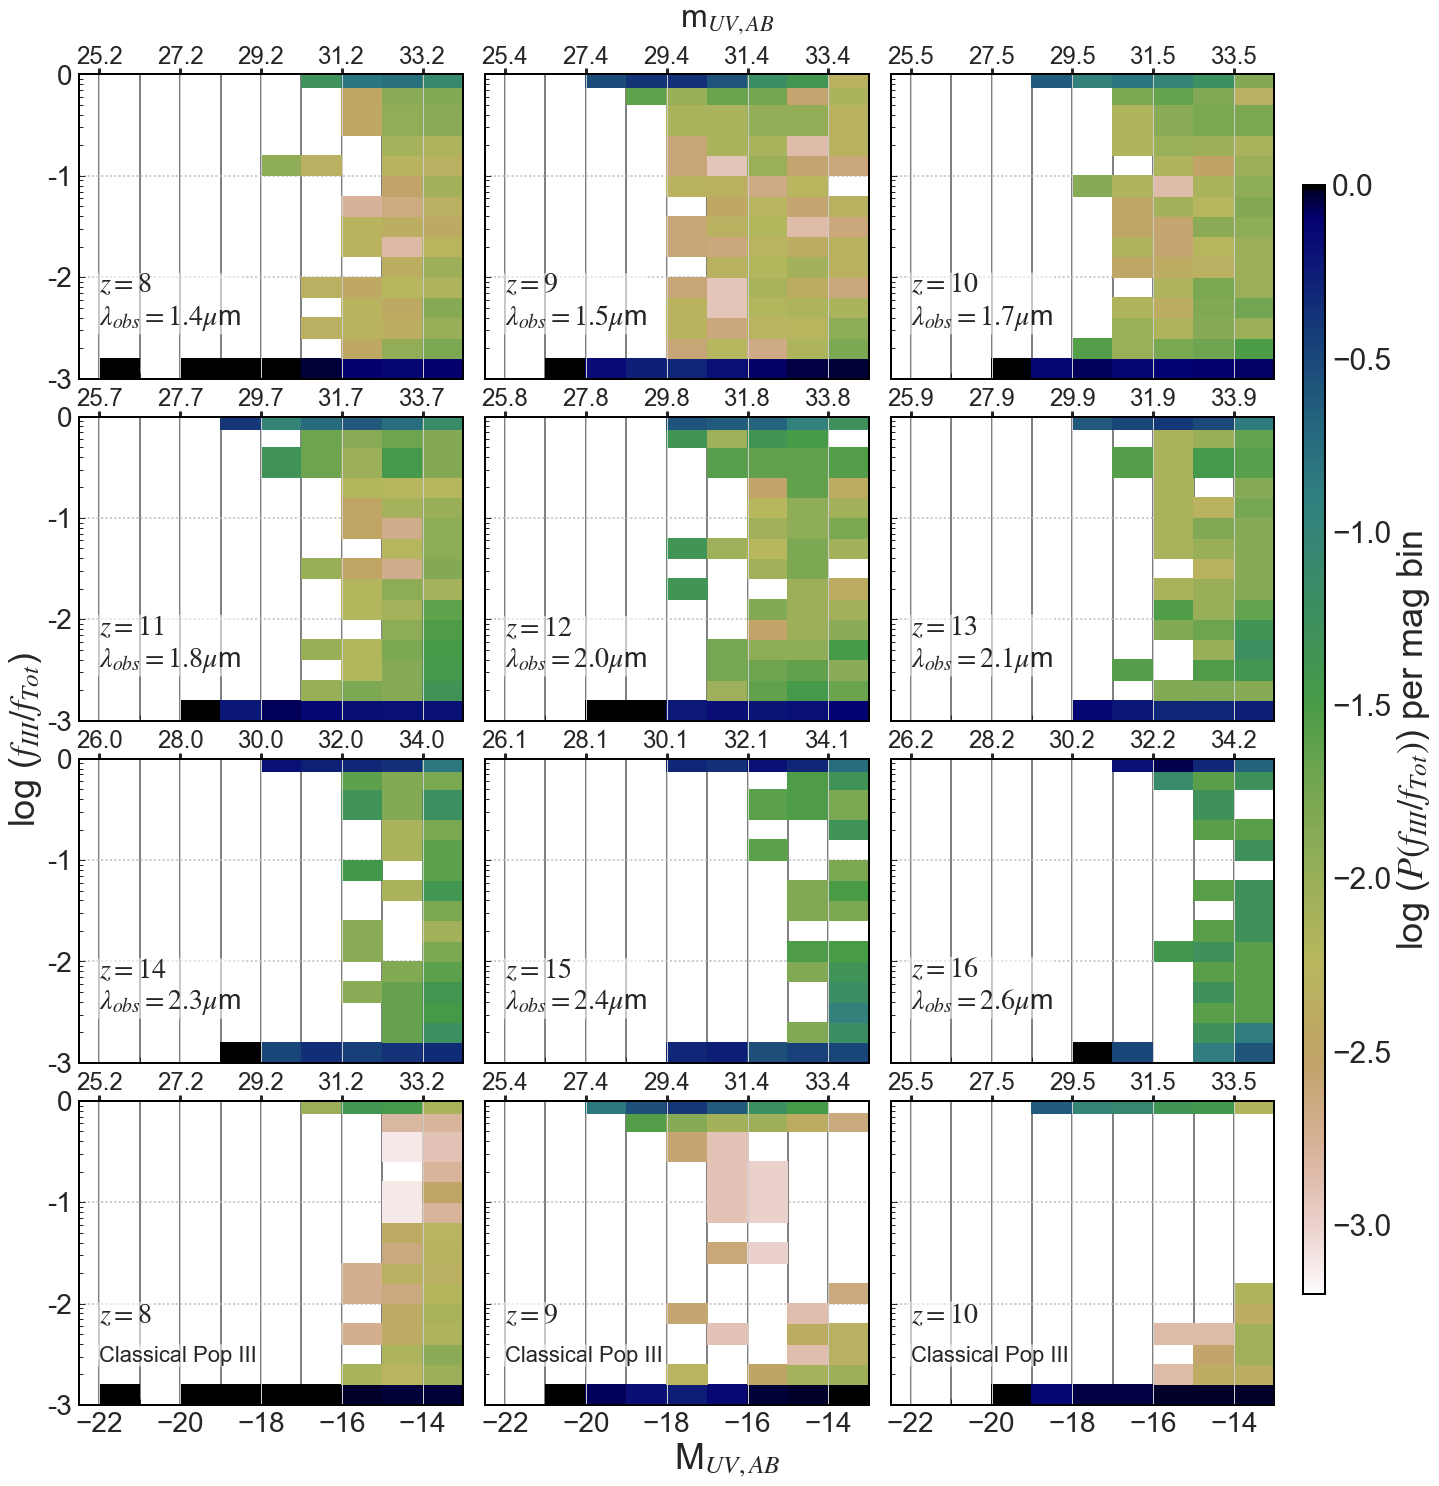

In [30]:
# Normalize the probability in each row such that it totals to 1.0

sns.set(style="whitegrid", font_scale=2, color_codes=True)
sns.set_style({'axes.edgecolor': '0.0','axes.linewidth': 2.0})

# Plot the fraction of Pop III magnitude vs M_AB NORMALIZED...

brightM = -22
limitM  = brightM+9
rgForSFunc = np.arange(brightM,limitM, 0.1)

magBins = np.linspace(brightM,limitM,(-brightM+limitM)*1 + 1) 
fracBins = np.logspace(-3,0,23)
# Contrived bin spacing such that the top bin represents .75-1.0 Pop III fraction
# and the next bin down represents .5-0.75 ...
fracBins = [0.001,  0.00158489,  0.00251189,  0.00398107,  0.00630957,
             0.01,  0.01584893,  0.02511886,  0.03981072,  0.06309573,
             0.1,  0.15848932,  0.25118864,
             0.5,   0.75,   1.0]
# fracBins = np.linspace(1e-3,9e-3,9).tolist() +np.linspace(1e-2,9e-2,9).tolist() +np.linspace(1e-1,1e-0,9).tolist()
print("Limiting absolute magnitude: {}".format(limitM))

p3ff ={}
p3ffMix = {}
doNMnow = False
fig, axs = plt.subplots(nrows=4, ncols=3, sharex='col',sharey='row',figsize=(20,22))
for z,ax in zip([8,9,10,11,12,13,14,15,16,8,9,10], axs.flat):

    # Convert observed magnitude to Absolute ...
    absMag, pop3Mag, nmAbsMag   = compMags(z)
    # Map 0 Pop 3 flux to 1e-3... 
    pop3Fraction = fluxes[z]['1500A_P3']/fluxes[z]['1500A']
    p3ff[z] = fluxes[z]['1500A_P3'].sum()/fluxes[z]['1500A'].sum()
    print("Pop III flux fraction is {:.5f} at z={}".format(p3ff[z],z))
    pop3Fraction[pop3Fraction < 1e-3] = 1e-3  # Map Pop 3 flux < 1e-3 to 1e-3
    p3ffMix[z] = p3ff[z] # Make a copy so we can print both mixing and no-mix

    print("Working on z={}".format(z))
    # If we are back to z = 8,9,10 then generate plots for NO Mixing
    if doNMnow:
        print("************************************************************")
        print("Working on the NON MIXING flux fractions for or galaxies ...")
        print("************************************************************")
        pop3Fraction = fluxes[z]['1500A_P3NM']/fluxes[z]['1500A_NM']
        p3ff[z] = fluxes[z]['1500A_P3NM'].sum()/fluxes[z]['1500A_NM'].sum()
#         print("Pop III flux fraction is {:.5f} at z={}".format(p3ffNM[z],z))
        pop3Fraction[pop3Fraction < 1e-3] = 1e-3  # Map Pop 3 flux < 1e-3 to 1e-3
        absMag = nmAbsMag ## Do plots for NO MIXING version of data... 
        print("z={} overall mixing p3ff={:.3f}, no mixing p3ff={:.3f}".format(z,p3ffMix[z],p3ff[z]))
        print("z={} PopIII mixing/no mixing={:.3f}".format(z,fluxes[z]['1500A_P3'].sum()/fluxes[z]['1500A_P3NM'].sum()))
        
    Ng = len(absMag) # Number of galaxies at this z
    print("Number of galaxies {}".format(Ng))
    # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
    # both the improved Pop III luminosity and the classical

    # Note that we are reversing x,y here since pcolormesh interprets them backwards!
    nTempA, binsx, binsy = np.histogram2d(pop3Fraction,absMag,bins=[fracBins,magBins],normed=False)
    # could use weights=[1/simVol for i in absMag] to normalize by vol here... 
    # normed : bool, optional
    #        If False, returns the number of samples in each bin. If True, returns the bin density 
    #        bin_count / sample_count / bin_area.

    X, Y = np.meshgrid(magBins, fracBins)  # Create a grid over the range of bins for the plot

    # Mask out 0 values before taking log10... 
    H = np.ma.masked_where(nTempA==0.0, nTempA)
    for i in range(len(H[0,:])):     # Column index i, over len of row 0
        colTot = np.sum(H[:,i])
        for j in range(len(H[:,0])): # Row index j, over len of column 0
            H[:,i][j] = H[:,i][j]/colTot
    H = np.log10(H)        # Take log of counts, we've already normalized by volume and area
    print("Largest bin value: {:.3f}, smallest {}".format(H.max(),H.min()))
    # Create the plot
    im = (ax.pcolormesh(X, Y, H, cmap=mpl.cm.gist_earth_r, vmin=-3.2, vmax=0) )
    
    ax.set_xscale('linear')
    ax.set_yscale('log')
    ax.yaxis.set_tick_params(which='major',width=1,length=6)
    ax.yaxis.set_tick_params(which='minor',width=1,length=4)
    ax.xaxis.set_tick_params(which='both',width=1,length=6)
    ax.xaxis.set_ticks(np.arange(brightM,limitM+1, 2))
    minorLocator = ticker.MultipleLocator(1)
    ax.xaxis.set_minor_locator(minorLocator)
    ax.get_yaxis().set_tick_params(which='both', direction='in',labelsize=28)
    ax.get_xaxis().set_tick_params(which='both', direction='in',labelsize=28)
    ax.yaxis.set_major_formatter(logfmt)
    ax.set_xlim([brightM-0.5,limitM])
    ax.set_ylim([1e-3,1.0])
    ax.grid(which='major', axis='y', color='0.75', linestyle=':', linewidth=1.5)
    ax.grid(which='both', axis='x', color='0.5', linestyle='-', linewidth=2.0)

    # Top x-axis labels ... m_ab
    ax2 = ax.twiny()
    ax2.set_xlim([brightM-0.5,limitM]) # required...
    axXtics = ax.get_xticks()
    ax2.set_xticks(axXtics)   # Set the location of the tics same as for ax
    ax2Xs = getMag(axXtics,z) # Convert M_ab -> m_ab
    ax2.set_xticklabels(["{:.1f}".format(i) for i in ax2Xs])
    ax2.xaxis.set_tick_params(which='major',width=3,length=6,direction='out',pad=0)
    ax2.get_xaxis().set_tick_params(labelsize=24)

    # plt.gca().invert_xaxis()
    gc.collect()
    
    if doNMnow:
        ax.annotate('$z={}$\n'.format(z,0.15*(1+z)+0.0001), xy = (0.5, 0.5), 
                xytext = (0.052, 0.15), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=28)
        ax.annotate('Classical Pop III'.format(z,0.15*(1+z)+0.0001), xy = (0.5, 0.5), 
                xytext = (0.052, 0.13), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=22)
    else:
        ax.annotate('$z={}$\n$\lambda_{{obs}}={:.1f} \mu$m'.format(z,0.15*(1+z)+0.0001), xy = (0.5, 0.5), 
                xytext = (0.052, 0.15), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=28)

    
    ####
    #### If we just finished z=16, do z=8,9,10 for 
    #### no mixing case
    ####
    if z == 16:
        print("FINISHED with z=8-16")
        doNMnow = True

plt.subplots_adjust(left=0.05, bottom=0.08, right=.88, top=0.92, wspace=.057, hspace=.125)

fig.text(0.5, 0.95,'m$_{UV,AB}$', ha='center',size=32 )
fig.text(0.5, 0.04,'M$_{UV,AB}$', ha='center',size=36 )
fig.text(0.00, 0.5, r'log ($f_{III}/f_{Tot}$)',size=36,va='center', rotation='vertical')

# Create the colorbar
cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)

cbar.ax.tick_params(labelsize=30) 
#cbar.ax.set_yticklabels(['1', '2', '4', '6', '10', maxCV], size=24)
cbar.set_label("log ($P(f_{III}/f_{Tot})$) per mag bin",fontsize=36)
plt.savefig("PopIII_fraction-Histograms-all9.pdf",dpi=fig.dpi,bbox_inches='tight')

gc.collect()

Limiting absolute magnitude: -13
Convert to Abs Mag. DM = 47.20 @ z=8.0
Pop III flux fraction is 0.06457 at z=8
Working on z=8
Number of galaxies 9417
Largest bin value: 0.000, smallest -2.7634279935629373


/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:58: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:59: RuntimeWarning: divide by zero encountered in log10


Convert to Abs Mag. DM = 47.38 @ z=9.0
Pop III flux fraction is 0.31201 at z=9
Working on z=9
Number of galaxies 3872
Largest bin value: 0.000, smallest -2.9237619608287004
Convert to Abs Mag. DM = 47.54 @ z=10.0
Pop III flux fraction is 0.12048 at z=10
Working on z=10
Number of galaxies 2651
Largest bin value: 0.000, smallest -2.8512583487190755
Convert to Abs Mag. DM = 47.68 @ z=11.0
Pop III flux fraction is 0.19452 at z=11
Working on z=11
Number of galaxies 2030
Largest bin value: 0.000, smallest -2.4955443375464483
Convert to Abs Mag. DM = 47.80 @ z=12.0
Pop III flux fraction is 0.21308 at z=12
Working on z=12
Number of galaxies 1365
Largest bin value: 0.000, smallest -2.534026106056135
Convert to Abs Mag. DM = 47.92 @ z=13.0
Pop III flux fraction is 0.33895 at z=13
Working on z=13
Number of galaxies 889
Largest bin value: -0.125, smallest -2.298853076409707
Convert to Abs Mag. DM = 48.03 @ z=14.0
Pop III flux fraction is 0.44895 at z=14
Working on z=14
Number of galaxies 531
Large

19569

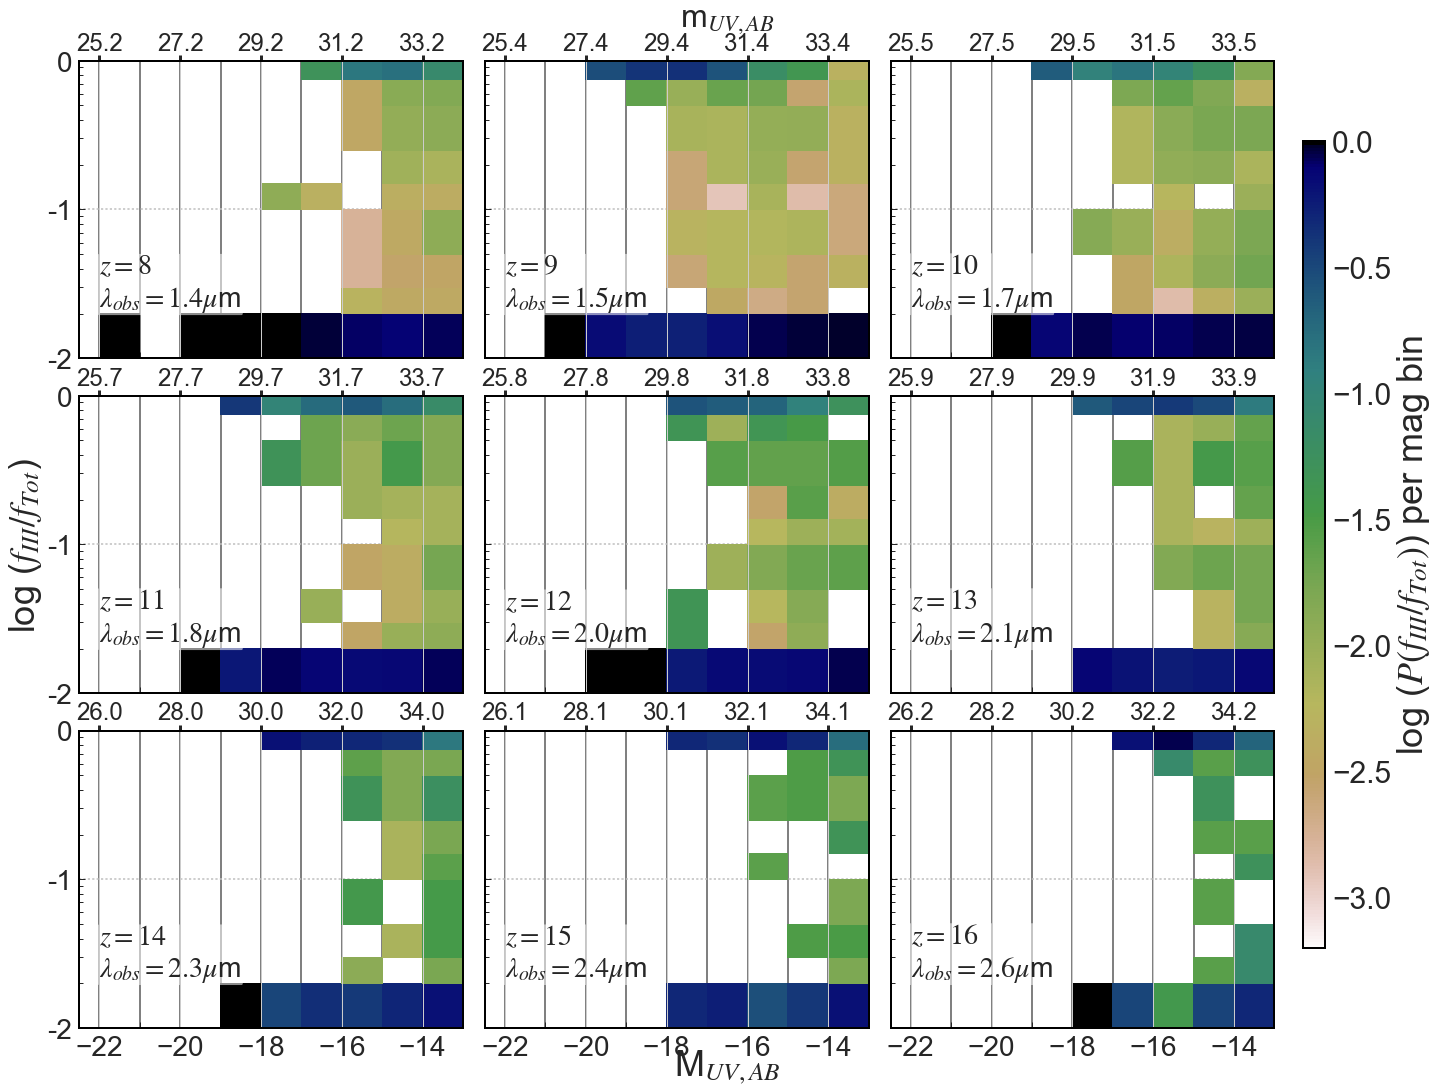

In [23]:
# Normalize the probability in each row such that it totals to 1.0

sns.set(style="whitegrid", font_scale=2, color_codes=True)
sns.set_style({'axes.edgecolor': '0.0','axes.linewidth': 2.0})

# Plot the fraction of Pop III magnitude vs M_AB NORMALIZED...

brightM = -22
limitM  = brightM+9
rgForSFunc = np.arange(brightM,limitM, 0.1)

magBins = np.linspace(brightM,limitM,(-brightM+limitM)*1 + 1) 
fracBins = np.logspace(-2,0,13)
# Contrived bin spacing such that the top bin represents .75-1.0 Pop III fraction
# and the next bin down represents .5-0.75 ...
fracBins = [ 0.01, 0.02, 0.03, 0.05, 0.1,  0.15,  0.25,
             0.5,   0.75,   1.0]
# fracBins = np.linspace(1e-3,9e-3,9).tolist() +np.linspace(1e-2,9e-2,9).tolist() +np.linspace(1e-1,1e-0,9).tolist()
print("Limiting absolute magnitude: {}".format(limitM))

p3ff ={}
p3ffMix = {}
doNMnow = False
fig, axs = plt.subplots(nrows=3, ncols=3, sharex='col',sharey='row',figsize=(20,16))
for z,ax in zip([8,9,10,11,12,13,14,15,16], axs.flat):

    # Convert observed magnitude to Absolute ...
    absMag, pop3Mag, nmAbsMag   = compMags(z)
    # Map 0 Pop 3 flux to 1e-3... 
    pop3Fraction = fluxes[z]['1500A_P3']/fluxes[z]['1500A']
    p3ff[z] = fluxes[z]['1500A_P3'].sum()/fluxes[z]['1500A'].sum()
    print("Pop III flux fraction is {:.5f} at z={}".format(p3ff[z],z))
    pop3Fraction[pop3Fraction < 0.01] = 0.01  # Map Pop 3 flux < 1e-3 to 1e-3
    p3ffMix[z] = p3ff[z] # Make a copy so we can print both mixing and no-mix

    print("Working on z={}".format(z))
    # If we are back to z = 8,9,10 then generate plots for NO Mixing

    Ng = len(absMag) # Number of galaxies at this z
    print("Number of galaxies {}".format(Ng))
    # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
    # both the improved Pop III luminosity and the classical

    # Note that we are reversing x,y here since pcolormesh interprets them backwards!
    nTempA, binsx, binsy = np.histogram2d(pop3Fraction,absMag,bins=[fracBins,magBins],normed=False)
    # could use weights=[1/simVol for i in absMag] to normalize by vol here... 
    # normed : bool, optional
    #        If False, returns the number of samples in each bin. If True, returns the bin density 
    #        bin_count / sample_count / bin_area.

    X, Y = np.meshgrid(magBins, fracBins)  # Create a grid over the range of bins for the plot

    # Mask out 0 values before taking log10... 
    H = np.ma.masked_where(nTempA==0.0, nTempA)
    for i in range(len(H[0,:])):     # Column index i, over len of row 0
        colTot = np.sum(H[:,i])
        for j in range(len(H[:,0])): # Row index j, over len of column 0
            H[:,i][j] = H[:,i][j]/colTot
    H = np.log10(H)        # Take log of counts, we've already normalized by volume and area
    print("Largest bin value: {:.3f}, smallest {}".format(H.max(),H.min()))
    # Create the plot
    im = (ax.pcolormesh(X, Y, H, cmap=mpl.cm.gist_earth_r, vmin=-3.2, vmax=0) )
    
    ax.set_xscale('linear')
    ax.set_yscale('log')
    ax.yaxis.set_tick_params(which='major',width=1,length=6)
    ax.yaxis.set_tick_params(which='minor',width=1,length=4)
    ax.xaxis.set_tick_params(which='both',width=1,length=6)
    ax.xaxis.set_ticks(np.arange(brightM,limitM+1, 2))
    minorLocator = ticker.MultipleLocator(1)
    ax.xaxis.set_minor_locator(minorLocator)
    ax.get_yaxis().set_tick_params(which='both', direction='in',labelsize=28)
    ax.get_xaxis().set_tick_params(which='both', direction='in',labelsize=28)
    ax.yaxis.set_major_formatter(logfmt)
    ax.set_xlim([brightM-0.5,limitM])
    ax.set_ylim([0.01,1.0])
    ax.grid(which='major', axis='y', color='0.75', linestyle=':', linewidth=1.5)
    ax.grid(which='both', axis='x', color='0.5', linestyle='-', linewidth=2.0)

    # Top x-axis labels ... m_ab
    ax2 = ax.twiny()
    ax2.set_xlim([brightM-0.5,limitM]) # required...
    axXtics = ax.get_xticks()
    ax2.set_xticks(axXtics)   # Set the location of the tics same as for ax
    ax2Xs = getMag(axXtics,z) # Convert M_ab -> m_ab
    ax2.set_xticklabels(["{:.1f}".format(i) for i in ax2Xs])
    ax2.xaxis.set_tick_params(which='major',width=3,length=6,direction='out',pad=0)
    ax2.get_xaxis().set_tick_params(labelsize=24)
    
    ax.annotate('$z={}$\n$\lambda_{{obs}}={:.1f} \mu$m'.format(z,0.15*(1+z)+0.0001), xy = (0.5, 0.5), 
                xytext = (0.052, 0.15), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=28)


    # plt.gca().invert_xaxis()
    gc.collect()
    
plt.subplots_adjust(left=0.05, bottom=0.08, right=.88, top=0.92, wspace=.057, hspace=.125)

fig.text(0.5, 0.95,'m$_{UV,AB}$', ha='center',size=32 )
fig.text(0.5, 0.04,'M$_{UV,AB}$', ha='center',size=36 )
fig.text(0.00, 0.5, r'log ($f_{III}/f_{Tot}$)',size=36,va='center', rotation='vertical')

# Create the colorbar
cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)

cbar.ax.tick_params(labelsize=30) 
#cbar.ax.set_yticklabels(['1', '2', '4', '6', '10', maxCV], size=24)
cbar.set_label("log ($P(f_{III}/f_{Tot})$) per mag bin",fontsize=36)
plt.savefig("PopIII_fraction-Histograms-all9-noClassic-largeOnly.pdf",dpi=fig.dpi,bbox_inches='tight')

gc.collect()

Limiting absolute magnitude: -13
Convert to Abs Mag. DM = 47.38 @ z=9.0
Pop III flux fraction is 0.31201 at z=9
Working on z=9
Number of galaxies 3872
Largest bin value: 0.000, smallest -2.9237619608287004


/Users/earnric/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/Users/earnric/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:71: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/Users/earnric/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:72: RuntimeWarning: divide by zero encountered in log10


Convert to Abs Mag. DM = 47.54 @ z=10.0
Pop III flux fraction is 0.12048 at z=10
Working on z=10
Number of galaxies 2651
Largest bin value: 0.000, smallest -2.8512583487190755
Convert to Abs Mag. DM = 47.68 @ z=11.0
Pop III flux fraction is 0.19452 at z=11
Working on z=11
Number of galaxies 2030
Largest bin value: 0.000, smallest -2.6972293427597176
FINISHED with z=8-12
Convert to Abs Mag. DM = 47.38 @ z=9.0
Pop III flux fraction is 0.31201 at z=9
Working on z=9
************************************************************
Working on the NON MIXING flux fractions for or galaxies ...
************************************************************
z=9 overall mixing p3ff=0.312, no mixing p3ff=0.251
z=9 PopIII mixing/no mixing=1.310
Number of galaxies 3872
Largest bin value: 0.000, smallest -2.9894498176666917
Convert to Abs Mag. DM = 47.54 @ z=10.0
Pop III flux fraction is 0.12048 at z=10
Working on z=10
************************************************************
Working on the NON MIXING f

27081

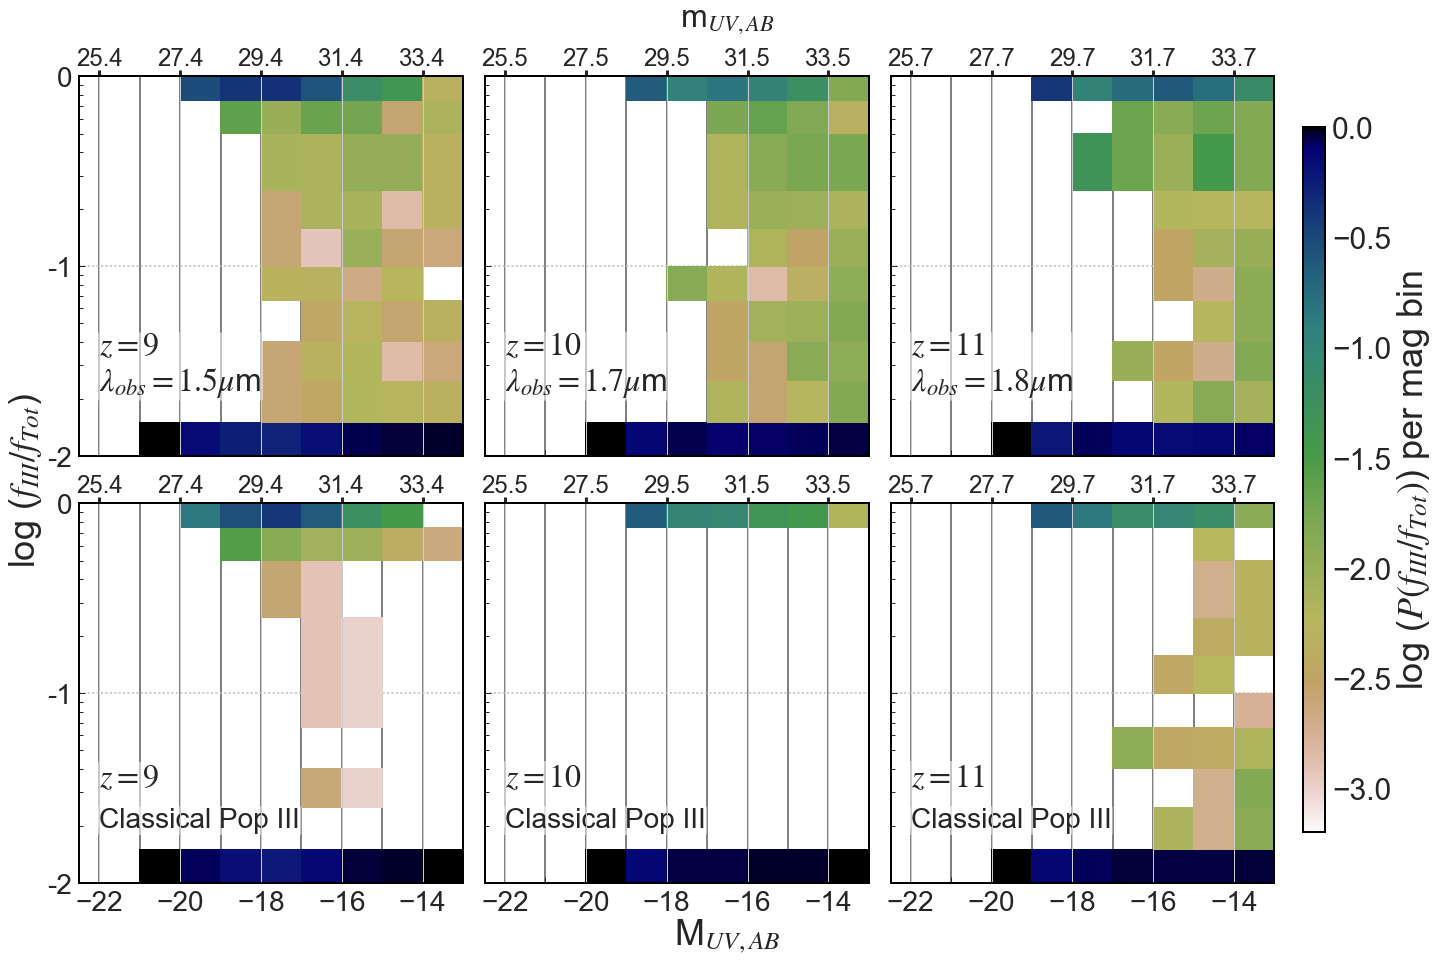

In [33]:
# Normalize the probability in each row such that it totals to 1.0

sns.set(style="whitegrid", font_scale=2, color_codes=True)
sns.set_style({'axes.edgecolor': '0.0','axes.linewidth': 2.0})

# Plot the fraction of Pop III magnitude vs M_AB NORMALIZED...

brightM = -22
limitM  = brightM+9
rgForSFunc = np.arange(brightM,limitM, 0.1)

magBins = np.linspace(brightM,limitM,(-brightM+limitM)*1 + 1) 
fracBins = np.logspace(-3,0,23)
# Contrived bin spacing such that the top bin represents .75-1.0 Pop III fraction
# and the next bin down represents .5-0.75 ...
fracBins = [ 0.01,  0.015,  0.025,  0.040,  0.066,
             0.1,  0.15848932,  0.25118864,
             0.5,   0.75,   1.0]
# fracBins = np.linspace(1e-3,9e-3,9).tolist() +np.linspace(1e-2,9e-2,9).tolist() +np.linspace(1e-1,1e-0,9).tolist()
print("Limiting absolute magnitude: {}".format(limitM))

p3ff ={}
p3ffMix = {}
doNMnow = False
fig, axs = plt.subplots(nrows=2, ncols=3, sharex='col',sharey='row',figsize=(20,14))
z_range = np.array([9,10,11,9,10,11])
for z,ax in zip(z_range, axs.flat):

    # Convert observed magnitude to Absolute ...
    absMag, pop3Mag, nmAbsMag   = compMags(z)
    # Map 0 Pop 3 flux to 1e-3... 
    pop3Fraction = fluxes[z]['1500A_P3']/fluxes[z]['1500A']
    p3ff[z] = fluxes[z]['1500A_P3'].sum()/fluxes[z]['1500A'].sum()
    print("Pop III flux fraction is {:.5f} at z={}".format(p3ff[z],z))
    pop3Fraction[pop3Fraction < 1e-2] = 1e-2  # Map Pop 3 flux < 1e-3 to 1e-3
    p3ffMix[z] = p3ff[z] # Make a copy so we can print both mixing and no-mix

    print("Working on z={}".format(z))
    # If we are back to z = 8,9,10 then generate plots for NO Mixing
    if doNMnow:
        print("************************************************************")
        print("Working on the NON MIXING flux fractions for or galaxies ...")
        print("************************************************************")
        pop3Fraction = fluxes[z]['1500A_P3NM']/fluxes[z]['1500A_NM']
        p3ff[z] = fluxes[z]['1500A_P3NM'].sum()/fluxes[z]['1500A_NM'].sum()
#         print("Pop III flux fraction is {:.5f} at z={}".format(p3ffNM[z],z))
        pop3Fraction[pop3Fraction < 1e-2] = 1e-2  # Map Pop 3 flux < 1e-3 to 1e-3
        absMag = nmAbsMag ## Do plots for NO MIXING version of data... 
        print("z={} overall mixing p3ff={:.3f}, no mixing p3ff={:.3f}".format(z,p3ffMix[z],p3ff[z]))
        print("z={} PopIII mixing/no mixing={:.3f}".format(z,fluxes[z]['1500A_P3'].sum()/fluxes[z]['1500A_P3NM'].sum()))
        
    Ng = len(absMag) # Number of galaxies at this z
    print("Number of galaxies {}".format(Ng))
    # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
    # both the improved Pop III luminosity and the classical

    # Note that we are reversing x,y here since pcolormesh interprets them backwards!
    nTempA, binsx, binsy = np.histogram2d(pop3Fraction,absMag,bins=[fracBins,magBins],normed=False)
    # could use weights=[1/simVol for i in absMag] to normalize by vol here... 
    # normed : bool, optional
    #        If False, returns the number of samples in each bin. If True, returns the bin density 
    #        bin_count / sample_count / bin_area.

    X, Y = np.meshgrid(magBins, fracBins)  # Create a grid over the range of bins for the plot

    # Mask out 0 values before taking log10... 
    H = np.ma.masked_where(nTempA==0.0, nTempA)
    for i in range(len(H[0,:])):     # Column index i, over len of row 0
        colTot = np.sum(H[:,i])
        for j in range(len(H[:,0])): # Row index j, over len of column 0
            H[:,i][j] = H[:,i][j]/colTot
    H = np.log10(H)        # Take log of counts, we've already normalized by volume and area
    print("Largest bin value: {:.3f}, smallest {}".format(H.max(),H.min()))
    # Create the plot
    im = (ax.pcolormesh(X, Y, H, cmap=mpl.cm.gist_earth_r, vmin=-3.2, vmax=0) )
    
    ax.set_xscale('linear')
    ax.set_yscale('log')
    ax.yaxis.set_tick_params(which='major',width=1,length=6)
    ax.yaxis.set_tick_params(which='minor',width=1,length=4)
    ax.xaxis.set_tick_params(which='both',width=1,length=6)
    ax.xaxis.set_ticks(np.arange(brightM,limitM+1, 2))
    minorLocator = ticker.MultipleLocator(1)
    ax.xaxis.set_minor_locator(minorLocator)
    ax.get_yaxis().set_tick_params(which='both', direction='in',labelsize=28)
    ax.get_xaxis().set_tick_params(which='both', direction='in',labelsize=28)
    ax.yaxis.set_major_formatter(logfmt)
    ax.set_xlim([brightM-0.5,limitM])
    ax.set_ylim([1e-2,1.0])
    ax.grid(which='major', axis='y', color='0.75', linestyle=':', linewidth=1.5)
    ax.grid(which='both', axis='x', color='0.5', linestyle='-', linewidth=2.0)

    # Top x-axis labels ... m_ab
    ax2 = ax.twiny()
    ax2.set_xlim([brightM-0.5,limitM]) # required...
    axXtics = ax.get_xticks()
    ax2.set_xticks(axXtics)   # Set the location of the tics same as for ax
    ax2Xs = getMag(axXtics,z) # Convert M_ab -> m_ab
    ax2.set_xticklabels(["{:.1f}".format(i) for i in ax2Xs])
    ax2.xaxis.set_tick_params(which='major',width=3,length=6,direction='out',pad=0)
    ax2.get_xaxis().set_tick_params(labelsize=24)

    # plt.gca().invert_xaxis()
    gc.collect()
    
    if doNMnow:
        ax.annotate('$z={}$\n'.format(z,0.15*(1+z)+0.0001), xy = (0.5, 0.5), 
                xytext = (0.052, 0.15), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=32)
        ax.annotate('Classical Pop III'.format(z,0.15*(1+z)+0.0001), xy = (0.5, 0.5), 
                xytext = (0.052, 0.13), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=28)
    else:
        ax.annotate('$z={}$\n$\lambda_{{obs}}={:.1f} \mu$m'.format(z,0.15*(1+z)+0.0001), xy = (0.5, 0.5), 
                xytext = (0.052, 0.15), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=32)

    
    ####
    #### If we just finished z=16, do z=8,9,10 for 
    #### no mixing case
    ####
    if z == z_range.max():
        print("FINISHED with z=8-12")
        doNMnow = True

plt.subplots_adjust(left=0.05, bottom=0.1, right=.88, top=0.90, wspace=.057, hspace=.125)

fig.text(0.5, 0.95,'m$_{UV,AB}$', ha='center',size=32 )
fig.text(0.5, 0.04,'M$_{UV,AB}$', ha='center',size=36 )
fig.text(0.00, 0.5, r'log ($f_{III}/f_{Tot}$)',size=36,va='center', rotation='vertical')

# Create the colorbar
cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)

cbar.ax.tick_params(labelsize=30) 
#cbar.ax.set_yticklabels(['1', '2', '4', '6', '10', maxCV], size=24)
cbar.set_label("log ($P(f_{III}/f_{Tot})$) per mag bin",fontsize=36)
plt.savefig("PopIII_fraction-Histograms-3.pdf",dpi=fig.dpi,bbox_inches='tight')

gc.collect()

Limiting absolute magnitude: -13
Convert to Abs Mag. DM = 47.20 @ z=8.0
Pop III flux fraction is 0.06457 at z=8
Working on z=8
Number of galaxies 9417
Largest bin value: 0.000, smallest -2.833784374656479


/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:60: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log10


Convert to Abs Mag. DM = 47.54 @ z=10.0
Pop III flux fraction is 0.12048 at z=10
Working on z=10
Number of galaxies 2651
Largest bin value: 0.000, smallest -2.8512583487190755
Convert to Abs Mag. DM = 47.80 @ z=12.0
Pop III flux fraction is 0.21308 at z=12
Working on z=12
Number of galaxies 1365
Largest bin value: 0.000, smallest -2.534026106056135
Convert to Abs Mag. DM = 48.03 @ z=14.0
Pop III flux fraction is 0.44895 at z=14
Working on z=14
Number of galaxies 531
Largest bin value: 0.000, smallest -2.130333768495006
Convert to Abs Mag. DM = 48.12 @ z=15.0
Pop III flux fraction is 0.51713 at z=15
Working on z=15
Number of galaxies 294
Largest bin value: -0.176, smallest -1.8195439355418686
Convert to Abs Mag. DM = 48.21 @ z=16.0
Pop III flux fraction is 0.64508 at z=16
Working on z=16
Number of galaxies 164
Largest bin value: 0.000, smallest -1.5797835966168101


15690

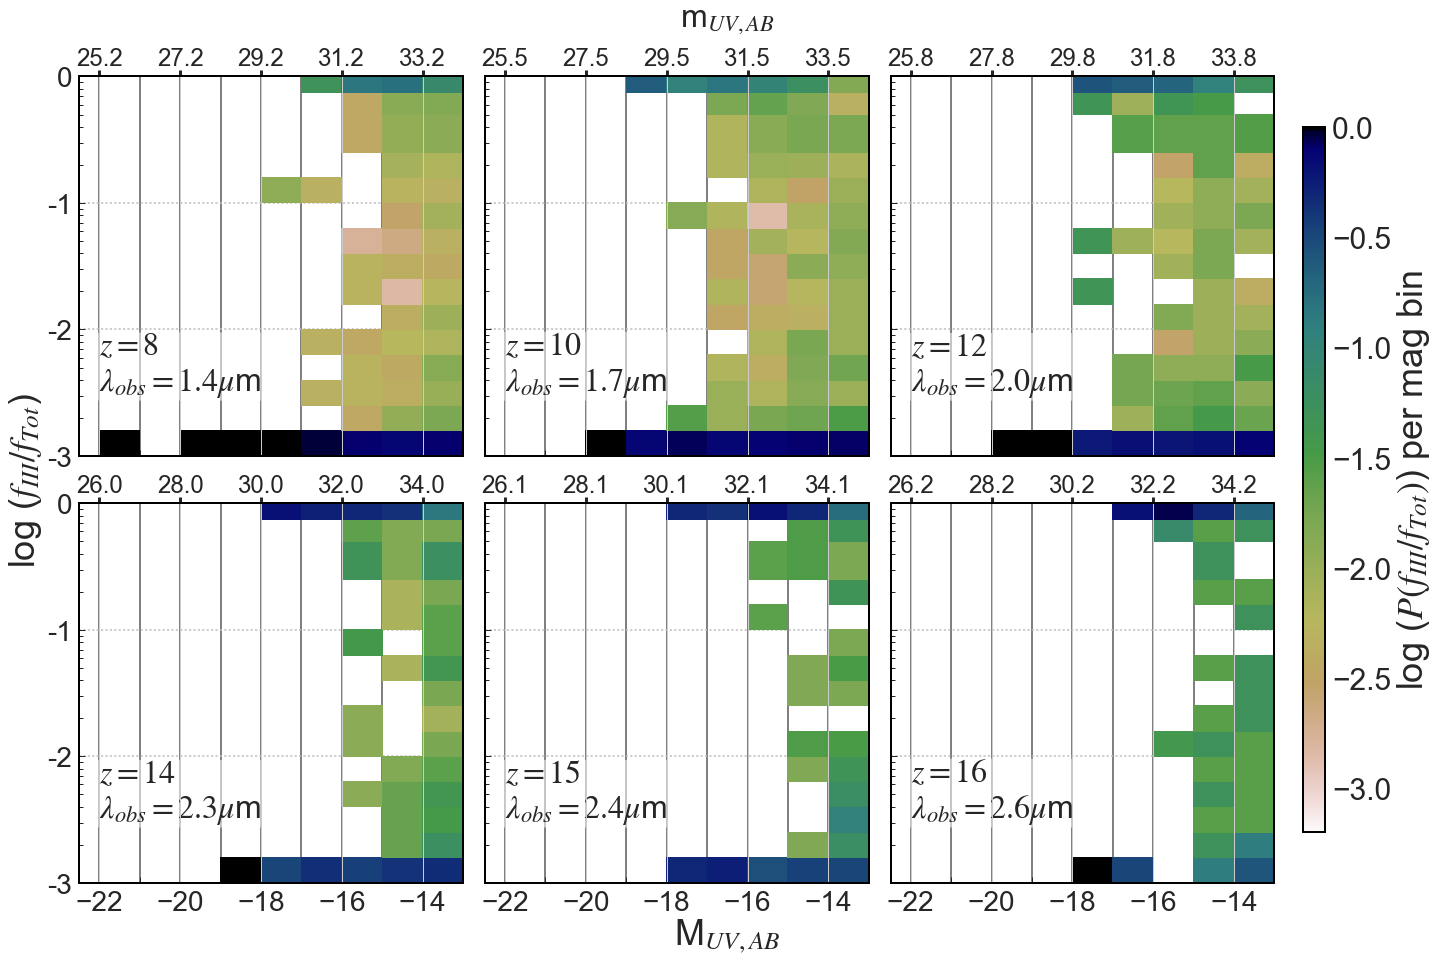

In [15]:
# Normalize the probability in each row such that it totals to 1.0

sns.set(style="whitegrid", font_scale=2, color_codes=True)
sns.set_style({'axes.edgecolor': '0.0','axes.linewidth': 2.0})

# Plot the fraction of Pop III magnitude vs M_AB NORMALIZED...

brightM = -22
limitM  = brightM+9
rgForSFunc = np.arange(brightM,limitM, 0.1)

magBins = np.linspace(brightM,limitM,(-brightM+limitM)*1 + 1) 
fracBins = np.logspace(-3,0,23)
# Contrived bin spacing such that the top bin represents .75-1.0 Pop III fraction
# and the next bin down represents .5-0.75 ...
fracBins = [0.001,  0.00158489,  0.00251189,  0.00398107,  0.00630957,
             0.01,  0.01584893,  0.02511886,  0.03981072,  0.06309573,
             0.1,  0.15848932,  0.25118864,
             0.5,   0.75,   1.0]
# fracBins = np.linspace(1e-3,9e-3,9).tolist() +np.linspace(1e-2,9e-2,9).tolist() +np.linspace(1e-1,1e-0,9).tolist()
print("Limiting absolute magnitude: {}".format(limitM))

p3ff ={}
p3ffMix = {}
doNMnow = False
fig, axs = plt.subplots(nrows=2, ncols=3, sharex='col',sharey='row',figsize=(20,14))
for z,ax in zip([8,10,12,14,15,16], axs.flat):

    # Convert observed magnitude to Absolute ...
    absMag, pop3Mag, nmAbsMag   = compMags(z)
    # Map 0 Pop 3 flux to 1e-3... 
    pop3Fraction = fluxes[z]['1500A_P3']/fluxes[z]['1500A']
    p3ff[z] = fluxes[z]['1500A_P3'].sum()/fluxes[z]['1500A'].sum()
    print("Pop III flux fraction is {:.5f} at z={}".format(p3ff[z],z))
    pop3Fraction[pop3Fraction < 1e-3] = 1e-3  # Map Pop 3 flux < 1e-3 to 1e-3
    p3ffMix[z] = p3ff[z] # Make a copy so we can print both mixing and no-mix

    print("Working on z={}".format(z))
    # If we are back to z = 8,9,10 then generate plots for NO Mixing

    Ng = len(absMag) # Number of galaxies at this z
    print("Number of galaxies {}".format(Ng))
    # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
    # both the improved Pop III luminosity and the classical

    # Note that we are reversing x,y here since pcolormesh interprets them backwards!
    nTempA, binsx, binsy = np.histogram2d(pop3Fraction,absMag,bins=[fracBins,magBins],normed=False)
    # could use weights=[1/simVol for i in absMag] to normalize by vol here... 
    # normed : bool, optional
    #        If False, returns the number of samples in each bin. If True, returns the bin density 
    #        bin_count / sample_count / bin_area.

    X, Y = np.meshgrid(magBins, fracBins)  # Create a grid over the range of bins for the plot

    # Mask out 0 values before taking log10... 
    H = np.ma.masked_where(nTempA==0.0, nTempA)
    for i in range(len(H[0,:])):     # Column index i, over len of row 0
        colTot = np.sum(H[:,i])
        for j in range(len(H[:,0])): # Row index j, over len of column 0
            H[:,i][j] = H[:,i][j]/colTot
    H = np.log10(H)        # Take log of counts, we've already normalized by volume and area
    print("Largest bin value: {:.3f}, smallest {}".format(H.max(),H.min()))
    # Create the plot
    im = (ax.pcolormesh(X, Y, H, cmap=mpl.cm.gist_earth_r, vmin=-3.2, vmax=0) )
    
    ax.set_xscale('linear')
    ax.set_yscale('log')
    ax.yaxis.set_tick_params(which='major',width=1,length=6)
    ax.yaxis.set_tick_params(which='minor',width=1,length=4)
    ax.xaxis.set_tick_params(which='both',width=1,length=6)
    ax.xaxis.set_ticks(np.arange(brightM,limitM+1, 2))
    minorLocator = ticker.MultipleLocator(1)
    ax.xaxis.set_minor_locator(minorLocator)
    ax.get_yaxis().set_tick_params(which='both', direction='in',labelsize=28)
    ax.get_xaxis().set_tick_params(which='both', direction='in',labelsize=28)
    ax.yaxis.set_major_formatter(logfmt)
    ax.set_xlim([brightM-0.5,limitM])
    ax.set_ylim([1e-3,1.0])
    ax.grid(which='major', axis='y', color='0.75', linestyle=':', linewidth=1.5)
    ax.grid(which='both', axis='x', color='0.5', linestyle='-', linewidth=2.0)

    # Top x-axis labels ... m_ab
    ax2 = ax.twiny()
    ax2.set_xlim([brightM-0.5,limitM]) # required...
    axXtics = ax.get_xticks()
    ax2.set_xticks(axXtics)   # Set the location of the tics same as for ax
    ax2Xs = getMag(axXtics,z) # Convert M_ab -> m_ab
    ax2.set_xticklabels(["{:.1f}".format(i) for i in ax2Xs])
    ax2.xaxis.set_tick_params(which='major',width=3,length=6,direction='out',pad=0)
    ax2.get_xaxis().set_tick_params(labelsize=24)
    
    ax.annotate('$z={}$\n$\lambda_{{obs}}={:.1f} \mu$m'.format(z,0.15*(1+z)+0.0001), xy = (0.5, 0.5), 
                xytext = (0.052, 0.15), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=32)


    # plt.gca().invert_xaxis()
    gc.collect()
    
plt.subplots_adjust(left=0.05, bottom=0.1, right=.88, top=0.90, wspace=.057, hspace=.125)

fig.text(0.5, 0.95,'m$_{UV,AB}$', ha='center',size=32 )
fig.text(0.5, 0.04,'M$_{UV,AB}$', ha='center',size=36 )
fig.text(0.00, 0.5, r'log ($f_{III}/f_{Tot}$)',size=36,va='center', rotation='vertical')

# Create the colorbar
cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)

cbar.ax.tick_params(labelsize=30) 
#cbar.ax.set_yticklabels(['1', '2', '4', '6', '10', maxCV], size=24)
cbar.set_label("log ($P(f_{III}/f_{Tot})$) per mag bin",fontsize=36)
plt.savefig("PopIII_fraction-Histograms-all6-noClassic.pdf",dpi=fig.dpi,bbox_inches='tight')

gc.collect()

In [20]:
# Normalize the probability in each row such that it totals to 1.0

sns.set(style="whitegrid", font_scale=2, color_codes=True)
sns.set_style({'axes.edgecolor': '0.0','axes.linewidth': 2.0})

# Plot the fraction of Pop III magnitude vs M_AB NORMALIZED...

brightM = -22
limitM  = brightM+9
rgForSFunc = np.arange(brightM,limitM, 0.1)

magBins = np.linspace(brightM,limitM,(-brightM+limitM)*1 + 1) 
fracBins = np.logspace(-3,0,23)
# Contrived bin spacing such that the top bin represents .75-1.0 Pop III fraction
# and the next bin down represents .5-0.75 ...
fracBins = [0.001,  0.00158489,  0.00251189,  0.00398107,  0.00630957,
             0.01,  0.01584893,  0.02511886,  0.03981072,  0.06309573,
             0.1,  0.15848932,  0.25118864,
             0.5,   0.75,   1.0]
# fracBins = np.linspace(1e-3,9e-3,9).tolist() +np.linspace(1e-2,9e-2,9).tolist() +np.linspace(1e-1,1e-0,9).tolist()
print("Limiting absolute magnitude: {}".format(limitM))

p3ff ={}
p3ffMix = {}
doNMnow = True
fig, axs = plt.subplots(nrows=1, ncols=3, sharex='col',sharey='row',figsize=(20,7))
for z,ax in zip([8,9,10], axs.flat):

    # Convert observed magnitude to Absolute ...
    absMag, pop3Mag, nmAbsMag   = compMags(z)
    # Map 0 Pop 3 flux to 1e-3... 
    pop3Fraction = fluxes[z]['1500A_P3']/fluxes[z]['1500A']
    p3ff[z] = fluxes[z]['1500A_P3'].sum()/fluxes[z]['1500A'].sum()
    print("Pop III flux fraction is {:.5f} at z={}".format(p3ff[z],z))
    pop3Fraction[pop3Fraction < 1e-3] = 1e-3  # Map Pop 3 flux < 1e-3 to 1e-3
    p3ffMix[z] = p3ff[z] # Make a copy so we can print both mixing and no-mix

    print("Working on z={}".format(z))
    # If we are back to z = 8,9,10 then generate plots for NO Mixing
    if doNMnow:
        print("************************************************************")
        print("Working on the NON MIXING flux fractions for or galaxies ...")
        print("************************************************************")
        pop3Fraction = fluxes[z]['1500A_P3NM']/fluxes[z]['1500A_NM']
        p3ff[z] = fluxes[z]['1500A_P3NM'].sum()/fluxes[z]['1500A_NM'].sum()
#         print("Pop III flux fraction is {:.5f} at z={}".format(p3ffNM[z],z))
        pop3Fraction[pop3Fraction < 1e-3] = 1e-3  # Map Pop 3 flux < 1e-3 to 1e-3
        absMag = nmAbsMag ## Do plots for NO MIXING version of data... 
        print("z={} overall mixing p3ff={:.3f}, no mixing p3ff={:.3f}".format(z,p3ffMix[z],p3ff[z]))
        print("z={} PopIII mixing/no mixing={:.3f}".format(z,fluxes[z]['1500A_P3'].sum()/fluxes[z]['1500A_P3NM'].sum()))
        
    Ng = len(absMag) # Number of galaxies at this z
    print("Number of galaxies {}".format(Ng))
    # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
    # both the improved Pop III luminosity and the classical

    # Note that we are reversing x,y here since pcolormesh interprets them backwards!
    nTempA, binsx, binsy = np.histogram2d(pop3Fraction,absMag,bins=[fracBins,magBins],normed=False)
    # could use weights=[1/simVol for i in absMag] to normalize by vol here... 
    # normed : bool, optional
    #        If False, returns the number of samples in each bin. If True, returns the bin density 
    #        bin_count / sample_count / bin_area.

    X, Y = np.meshgrid(magBins, fracBins)  # Create a grid over the range of bins for the plot

    # Mask out 0 values before taking log10... 
    H = np.ma.masked_where(nTempA==0.0, nTempA)
    for i in range(len(H[0,:])):     # Column index i, over len of row 0
        colTot = np.sum(H[:,i])
        for j in range(len(H[:,0])): # Row index j, over len of column 0
            H[:,i][j] = H[:,i][j]/colTot
    H = np.log10(H)        # Take log of counts, we've already normalized by volume and area
    print("Largest bin value: {:.3f}, smallest {}".format(H.max(),H.min()))
    # Create the plot
    im = (ax.pcolormesh(X, Y, H, cmap=mpl.cm.gist_earth_r, vmin=-3.2, vmax=0) )
    
    ax.set_xscale('linear')
    ax.set_yscale('log')
    ax.yaxis.set_tick_params(which='major',width=1,length=6)
    ax.yaxis.set_tick_params(which='minor',width=1,length=4)
    ax.xaxis.set_tick_params(which='both',width=1,length=6)
    ax.xaxis.set_ticks(np.arange(brightM,limitM+1, 2))
    minorLocator = ticker.MultipleLocator(1)
    ax.xaxis.set_minor_locator(minorLocator)
    ax.get_yaxis().set_tick_params(which='both', direction='in',labelsize=28)
    ax.get_xaxis().set_tick_params(which='both', direction='in',labelsize=28)
    ax.yaxis.set_major_formatter(logfmt)
    ax.set_xlim([brightM-0.5,limitM])
    ax.set_ylim([1e-3,1.0])
    ax.grid(which='major', axis='y', color='0.75', linestyle=':', linewidth=1.5)
    ax.grid(which='both', axis='x', color='0.5', linestyle='-', linewidth=2.0)

    # Top x-axis labels ... m_ab
    ax2 = ax.twiny()
    ax2.set_xlim([brightM-0.5,limitM]) # required...
    axXtics = ax.get_xticks()
    ax2.set_xticks(axXtics)   # Set the location of the tics same as for ax
    ax2Xs = getMag(axXtics,z) # Convert M_ab -> m_ab
    ax2.set_xticklabels(["{:.1f}".format(i) for i in ax2Xs])
    ax2.xaxis.set_tick_params(which='major',width=3,length=6,direction='out',pad=0)
    ax2.get_xaxis().set_tick_params(labelsize=24)

    # plt.gca().invert_xaxis()
    gc.collect()
    
    if doNMnow:
        ax.annotate('$z={}$\n'.format(z,0.15*(1+z)+0.0001), xy = (0.5, 0.5), 
                xytext = (0.052, 0.15), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=28)
        ax.annotate('Classical Pop III'.format(z,0.15*(1+z)+0.0001), xy = (0.5, 0.5), 
                xytext = (0.052, 0.13), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=22)
    else:
        ax.annotate('$z={}$\n$\lambda_{{obs}}={:.1f} \mu$m'.format(z,0.15*(1+z)+0.0001), xy = (0.5, 0.5), 
                xytext = (0.052, 0.15), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=28)


plt.subplots_adjust(left=0.05, bottom=0.15, right=.88, top=0.88, wspace=.057, hspace=.125)

fig.text(0.5, 0.98,'m$_{UV,AB}$', ha='center',size=32 )
fig.text(0.5, 0.02,'M$_{UV,AB}$', ha='center',size=36 )
fig.text(0.00, 0.5, r'log ($f_{III}/f_{Tot}$)',size=36,va='center', rotation='vertical')

# Create the colorbar
cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)

cbar.ax.tick_params(labelsize=30) 
#cbar.ax.set_yticklabels(['1', '2', '4', '6', '10', maxCV], size=24)
cbar.set_label("log ($P(f_{III}/f_{Tot})$) per mag bin",fontsize=36)
plt.savefig("PopIII_fraction-Histograms-Classic.pdf",dpi=fig.dpi,bbox_inches='tight')

gc.collect()

Limiting absolute magnitude: -13
Convert to Abs Mag. DM = 47.20 @ z=8.0
Pop III flux fraction is 0.06457 at z=8
Working on z=8
************************************************************
Working on the NON MIXING flux fractions for or galaxies ...
************************************************************
z=8 overall mixing p3ff=0.065, no mixing p3ff=0.014
z=8 PopIII mixing/no mixing=4.689
Number of galaxies 9417
Largest bin value: 0.000, smallest -3.11293997608408


/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:71: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:72: RuntimeWarning: divide by zero encountered in log10


Convert to Abs Mag. DM = 47.38 @ z=9.0
Pop III flux fraction is 0.31201 at z=9
Working on z=9
************************************************************
Working on the NON MIXING flux fractions for or galaxies ...
************************************************************
z=9 overall mixing p3ff=0.312, no mixing p3ff=0.251
z=9 PopIII mixing/no mixing=1.310
Number of galaxies 3872
Largest bin value: 0.000, smallest -2.9894498176666917
Convert to Abs Mag. DM = 47.54 @ z=10.0
Pop III flux fraction is 0.12048 at z=10
Working on z=10
************************************************************
Working on the NON MIXING flux fractions for or galaxies ...
************************************************************
z=10 overall mixing p3ff=0.120, no mixing p3ff=0.071
z=10 PopIII mixing/no mixing=1.732
Number of galaxies 2651
Largest bin value: 0.000, smallest -2.8488047010518036


12261

Limiting absolute magnitude: -13
Convert to Abs Mag. DM = 47.38 @ z=9.0
Pop III flux fraction is 0.31201 at z=9
Working on z=9
Number of galaxies 3872
Largest bin value: 0.000, smallest -2.9237619608287004


/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:72: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:73: RuntimeWarning: divide by zero encountered in log10


Convert to Abs Mag. DM = 47.54 @ z=10.0
Pop III flux fraction is 0.12048 at z=10
Working on z=10
Number of galaxies 2651
Largest bin value: 0.000, smallest -2.8512583487190755
Convert to Abs Mag. DM = 47.68 @ z=11.0
Pop III flux fraction is 0.19452 at z=11
Working on z=11
Number of galaxies 2030
Largest bin value: 0.000, smallest -2.6972293427597176
FINISHED with z=8-12
Convert to Abs Mag. DM = 47.38 @ z=9.0
Pop III flux fraction is 0.31201 at z=9
Working on z=9
************************************************************
Working on the NON MIXING flux fractions for or galaxies ...
************************************************************
z=9 overall mixing p3ff=0.312, no mixing p3ff=0.251
z=9 PopIII mixing/no mixing=1.310
Number of galaxies 3872
Largest bin value: 0.000, smallest -2.9894498176666917
Convert to Abs Mag. DM = 47.54 @ z=10.0
Pop III flux fraction is 0.12048 at z=10
Working on z=10
************************************************************
Working on the NON MIXING f

4510

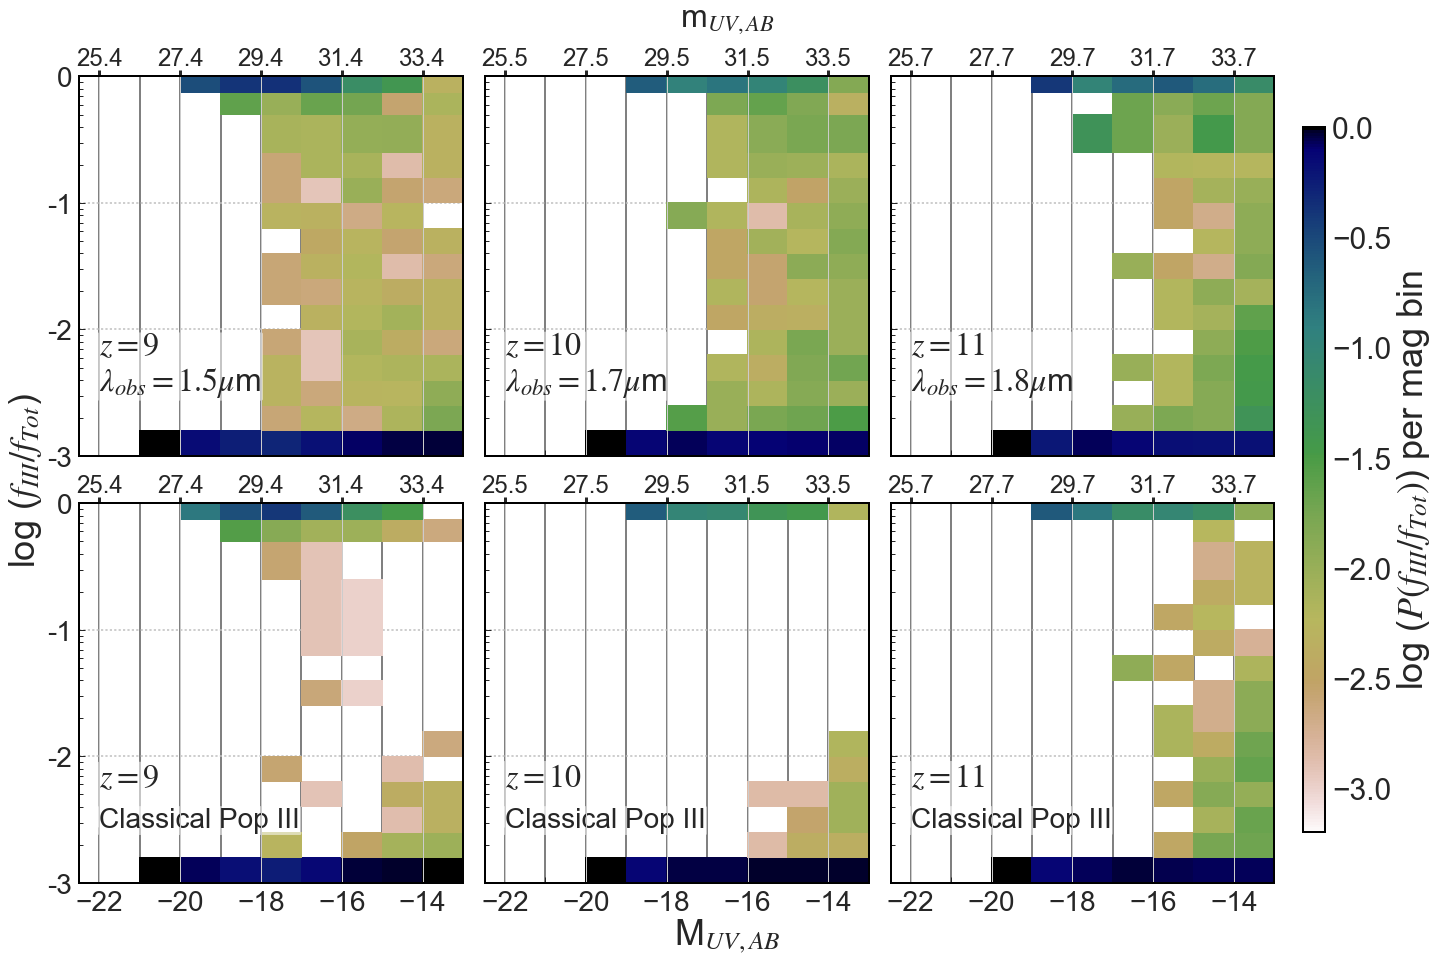

In [20]:
# Normalize the probability in each row such that it totals to 1.0

sns.set(style="whitegrid", font_scale=2, color_codes=True)
sns.set_style({'axes.edgecolor': '0.0','axes.linewidth': 2.0})

# Plot the fraction of Pop III magnitude vs M_AB NORMALIZED...

brightM = -22
limitM  = brightM+9
rgForSFunc = np.arange(brightM,limitM, 0.1)

magBins = np.linspace(brightM,limitM,(-brightM+limitM)*1 + 1) 
fracBins = np.logspace(-3,0,23)
# Contrived bin spacing such that the top bin represents .75-1.0 Pop III fraction
# and the next bin down represents .5-0.75 ...
fracBins = [0.001,  0.00158489,  0.00251189,  0.00398107,  0.00630957,
             0.01,  0.01584893,  0.02511886,  0.03981072,  0.06309573,
             0.1,  0.15848932,  0.25118864,
             0.5,   0.75,   1.0]
# fracBins = np.linspace(1e-3,9e-3,9).tolist() +np.linspace(1e-2,9e-2,9).tolist() +np.linspace(1e-1,1e-0,9).tolist()
print("Limiting absolute magnitude: {}".format(limitM))

p3ff ={}
p3ffMix = {}
doNMnow = False
fig, axs = plt.subplots(nrows=2, ncols=3, sharex='col',sharey='row',figsize=(20,14))
z_range = np.array([9,10,11,9,10,11])
for z,ax in zip(z_range, axs.flat):

    # Convert observed magnitude to Absolute ...
    absMag, pop3Mag, nmAbsMag   = compMags(z)
    # Map 0 Pop 3 flux to 1e-3... 
    pop3Fraction = fluxes[z]['1500A_P3']/fluxes[z]['1500A']
    p3ff[z] = fluxes[z]['1500A_P3'].sum()/fluxes[z]['1500A'].sum()
    print("Pop III flux fraction is {:.5f} at z={}".format(p3ff[z],z))
    pop3Fraction[pop3Fraction < 1e-3] = 1e-3  # Map Pop 3 flux < 1e-3 to 1e-3
    p3ffMix[z] = p3ff[z] # Make a copy so we can print both mixing and no-mix

    print("Working on z={}".format(z))
    # If we are back to z = 8,9,10 then generate plots for NO Mixing
    if doNMnow:
        print("************************************************************")
        print("Working on the NON MIXING flux fractions for or galaxies ...")
        print("************************************************************")
        pop3Fraction = fluxes[z]['1500A_P3NM']/fluxes[z]['1500A_NM']
        p3ff[z] = fluxes[z]['1500A_P3NM'].sum()/fluxes[z]['1500A_NM'].sum()
#         print("Pop III flux fraction is {:.5f} at z={}".format(p3ffNM[z],z))
        pop3Fraction[pop3Fraction < 1e-3] = 1e-3  # Map Pop 3 flux < 1e-3 to 1e-3
        absMag = nmAbsMag ## Do plots for NO MIXING version of data... 
        print("z={} overall mixing p3ff={:.3f}, no mixing p3ff={:.3f}".format(z,p3ffMix[z],p3ff[z]))
        print("z={} PopIII mixing/no mixing={:.3f}".format(z,fluxes[z]['1500A_P3'].sum()/fluxes[z]['1500A_P3NM'].sum()))
        
    Ng = len(absMag) # Number of galaxies at this z
    print("Number of galaxies {}".format(Ng))
    # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
    # both the improved Pop III luminosity and the classical

    # Note that we are reversing x,y here since pcolormesh interprets them backwards!
    nTempA, binsx, binsy = np.histogram2d(pop3Fraction,absMag,bins=[fracBins,magBins],normed=False)
    # could use weights=[1/simVol for i in absMag] to normalize by vol here... 
    # normed : bool, optional
    #        If False, returns the number of samples in each bin. If True, returns the bin density 
    #        bin_count / sample_count / bin_area.

    X, Y = np.meshgrid(magBins, fracBins)  # Create a grid over the range of bins for the plot

    # Mask out 0 values before taking log10... 
    H = np.ma.masked_where(nTempA==0.0, nTempA)
    for i in range(len(H[0,:])):     # Column index i, over len of row 0
        colTot = np.sum(H[:,i])
        for j in range(len(H[:,0])): # Row index j, over len of column 0
            H[:,i][j] = H[:,i][j]/colTot
    H = np.log10(H)        # Take log of counts, we've already normalized by volume and area
    print("Largest bin value: {:.3f}, smallest {}".format(H.max(),H.min()))
    # Create the plot
    im = (ax.pcolormesh(X, Y, H, cmap=mpl.cm.gist_earth_r, vmin=-3.2, vmax=0) )
    
    ax.set_xscale('linear')
    ax.set_yscale('log')
    ax.yaxis.set_tick_params(which='major',width=1,length=6)
    ax.yaxis.set_tick_params(which='minor',width=1,length=4)
    ax.xaxis.set_tick_params(which='both',width=1,length=6)
    ax.xaxis.set_ticks(np.arange(brightM,limitM+1, 2))
    minorLocator = ticker.MultipleLocator(1)
    ax.xaxis.set_minor_locator(minorLocator)
    ax.get_yaxis().set_tick_params(which='both', direction='in',labelsize=28)
    ax.get_xaxis().set_tick_params(which='both', direction='in',labelsize=28)
    ax.yaxis.set_major_formatter(logfmt)
    ax.set_xlim([brightM-0.5,limitM])
    ax.set_ylim([1e-3,1.0])
    ax.grid(which='major', axis='y', color='0.75', linestyle=':', linewidth=1.5)
    ax.grid(which='both', axis='x', color='0.5', linestyle='-', linewidth=2.0)

    # Top x-axis labels ... m_ab
    ax2 = ax.twiny()
    ax2.set_xlim([brightM-0.5,limitM]) # required...
    axXtics = ax.get_xticks()
    ax2.set_xticks(axXtics)   # Set the location of the tics same as for ax
    ax2Xs = getMag(axXtics,z) # Convert M_ab -> m_ab
    ax2.set_xticklabels(["{:.1f}".format(i) for i in ax2Xs])
    ax2.xaxis.set_tick_params(which='major',width=3,length=6,direction='out',pad=0)
    ax2.get_xaxis().set_tick_params(labelsize=24)

    # plt.gca().invert_xaxis()
    gc.collect()
    
    if doNMnow:
        ax.annotate('$z={}$\n'.format(z,0.15*(1+z)+0.0001), xy = (0.5, 0.5), 
                xytext = (0.052, 0.15), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=32)
        ax.annotate('Classical Pop III'.format(z,0.15*(1+z)+0.0001), xy = (0.5, 0.5), 
                xytext = (0.052, 0.13), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=28)
    else:
        ax.annotate('$z={}$\n$\lambda_{{obs}}={:.1f} \mu$m'.format(z,0.15*(1+z)+0.0001), xy = (0.5, 0.5), 
                xytext = (0.052, 0.15), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=32)

    
    ####
    #### If we just finished z=16, do z=8,9,10 for 
    #### no mixing case
    ####
    if z == z_range.max():
        print("FINISHED with z=8-12")
        doNMnow = True

plt.subplots_adjust(left=0.05, bottom=0.1, right=.88, top=0.90, wspace=.057, hspace=.125)

fig.text(0.5, 0.95,'m$_{UV,AB}$', ha='center',size=32 )
fig.text(0.5, 0.04,'M$_{UV,AB}$', ha='center',size=36 )
fig.text(0.00, 0.5, r'log ($f_{III}/f_{Tot}$)',size=36,va='center', rotation='vertical')

# Create the colorbar
cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)

cbar.ax.tick_params(labelsize=30) 
#cbar.ax.set_yticklabels(['1', '2', '4', '6', '10', maxCV], size=24)
cbar.set_label("log ($P(f_{III}/f_{Tot})$) per mag bin",fontsize=36)
plt.savefig("PopIII_fraction-Histograms-compare.pdf",dpi=fig.dpi,bbox_inches='tight')

gc.collect()

Limiting absolute magnitude: -13
Convert to Abs Mag. DM = 47.20 @ z=8.0
Pop III flux fraction is 0.06457 at z=8
Working on z=8
Number of galaxies 9417
Largest bin value: 0.000, smallest -2.833784374656479


/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:60: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log10


Convert to Abs Mag. DM = 47.38 @ z=9.0
Pop III flux fraction is 0.31201 at z=9
Working on z=9
Number of galaxies 3872
Largest bin value: 0.000, smallest -2.9237619608287004
Convert to Abs Mag. DM = 47.54 @ z=10.0
Pop III flux fraction is 0.12048 at z=10
Working on z=10
Number of galaxies 2651
Largest bin value: 0.000, smallest -2.8512583487190755
Convert to Abs Mag. DM = 47.68 @ z=11.0
Pop III flux fraction is 0.19452 at z=11
Working on z=11
Number of galaxies 2030
Largest bin value: 0.000, smallest -2.6972293427597176
Convert to Abs Mag. DM = 47.80 @ z=12.0
Pop III flux fraction is 0.21308 at z=12
Working on z=12
Number of galaxies 1365
Largest bin value: 0.000, smallest -2.534026106056135
Convert to Abs Mag. DM = 47.92 @ z=13.0
Pop III flux fraction is 0.33895 at z=13
Working on z=13
Number of galaxies 889
Largest bin value: -0.125, smallest -2.298853076409707
Convert to Abs Mag. DM = 48.03 @ z=14.0
Pop III flux fraction is 0.44895 at z=14
Working on z=14
Number of galaxies 531
Large

33552

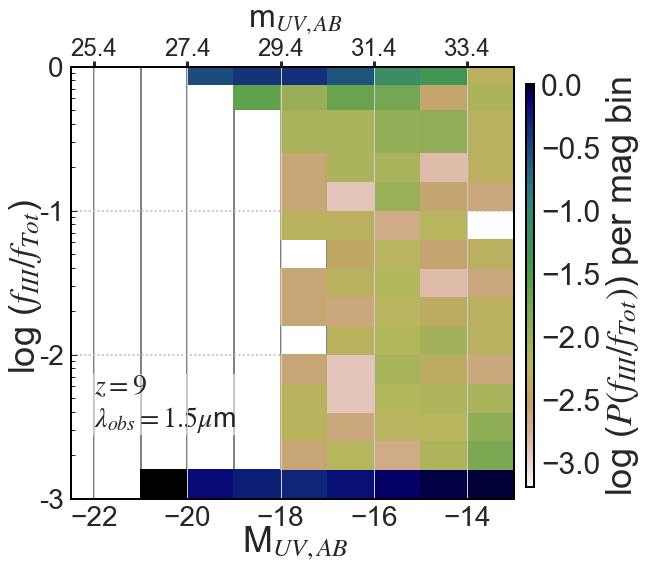

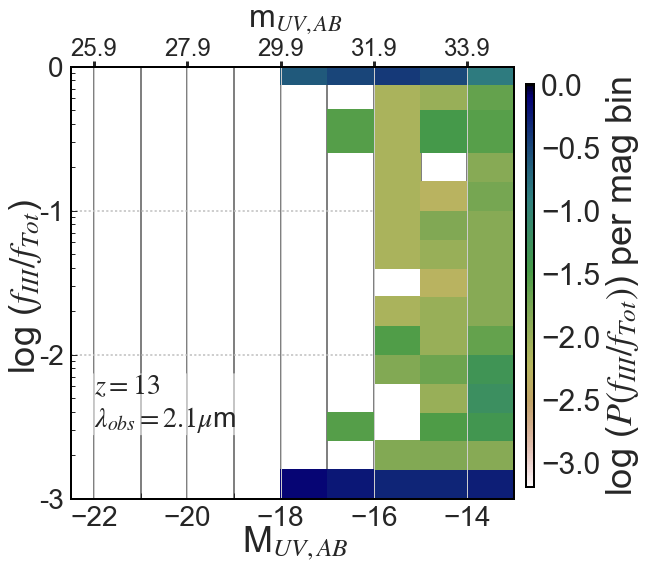

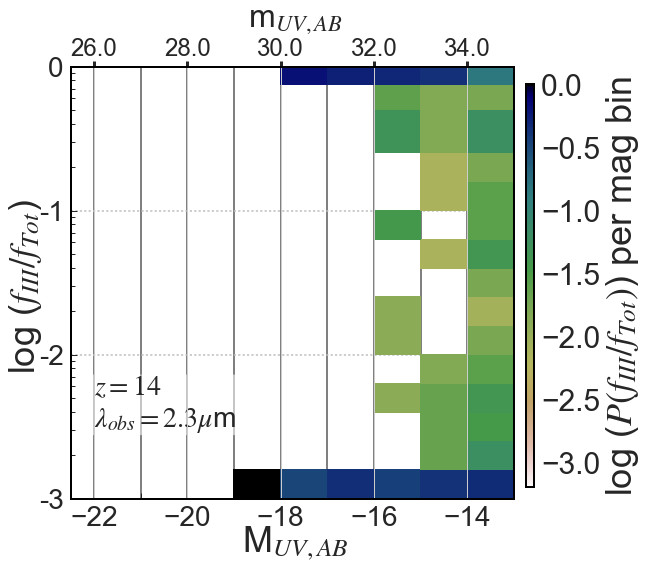

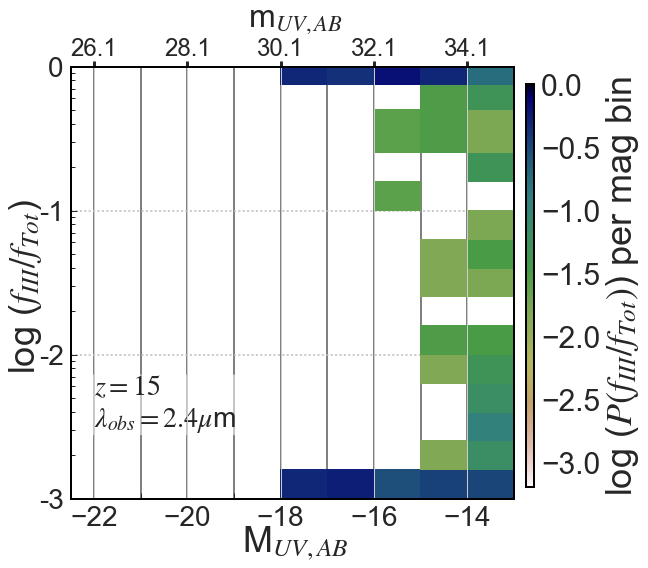

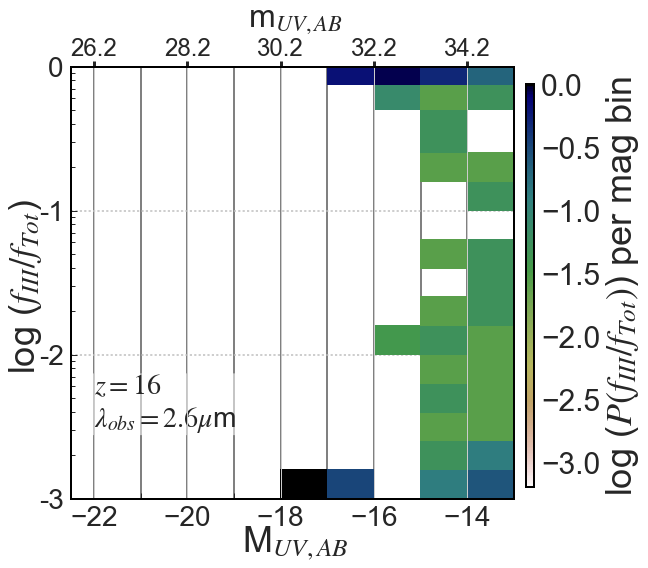

In [25]:
# Normalize the probability in each row such that it totals to 1.0

sns.set(style="whitegrid", font_scale=2, color_codes=True)
sns.set_style({'axes.edgecolor': '0.0','axes.linewidth': 2.0})

# Plot the fraction of Pop III magnitude vs M_AB NORMALIZED...

brightM = -22
limitM  = brightM+9
rgForSFunc = np.arange(brightM,limitM, 0.1)

magBins = np.linspace(brightM,limitM,(-brightM+limitM)*1 + 1) 
fracBins = np.logspace(-3,0,23)
# Contrived bin spacing such that the top bin represents .75-1.0 Pop III fraction
# and the next bin down represents .5-0.75 ...
fracBins = [0.001,  0.00158489,  0.00251189,  0.00398107,  0.00630957,
             0.01,  0.01584893,  0.02511886,  0.03981072,  0.06309573,
             0.1,  0.15848932,  0.25118864,
             0.5,   0.75,   1.0]
# fracBins = np.linspace(1e-3,9e-3,9).tolist() +np.linspace(1e-2,9e-2,9).tolist() +np.linspace(1e-1,1e-0,9).tolist()
print("Limiting absolute magnitude: {}".format(limitM))

p3ff ={}
p3ffMix = {}
doNMnow = False
for z in [8,9,10,11,12,13,14,15,16]:

    fig, ax = plt.subplots(nrows=1, ncols=1, sharex='col',sharey='row',figsize=(8,8))
    # Convert observed magnitude to Absolute ...
    absMag, pop3Mag, nmAbsMag   = compMags(z)
    # Map 0 Pop 3 flux to 1e-3... 
    pop3Fraction = fluxes[z]['1500A_P3']/fluxes[z]['1500A']
    p3ff[z] = fluxes[z]['1500A_P3'].sum()/fluxes[z]['1500A'].sum()
    print("Pop III flux fraction is {:.5f} at z={}".format(p3ff[z],z))
    pop3Fraction[pop3Fraction < 1e-3] = 1e-3  # Map Pop 3 flux < 1e-3 to 1e-3
    p3ffMix[z] = p3ff[z] # Make a copy so we can print both mixing and no-mix

    print("Working on z={}".format(z))
    # If we are back to z = 8,9,10 then generate plots for NO Mixing

    Ng = len(absMag) # Number of galaxies at this z
    print("Number of galaxies {}".format(Ng))
    # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
    # both the improved Pop III luminosity and the classical

    # Note that we are reversing x,y here since pcolormesh interprets them backwards!
    nTempA, binsx, binsy = np.histogram2d(pop3Fraction,absMag,bins=[fracBins,magBins],normed=False)
    # could use weights=[1/simVol for i in absMag] to normalize by vol here... 
    # normed : bool, optional
    #        If False, returns the number of samples in each bin. If True, returns the bin density 
    #        bin_count / sample_count / bin_area.

    X, Y = np.meshgrid(magBins, fracBins)  # Create a grid over the range of bins for the plot

    # Mask out 0 values before taking log10... 
    H = np.ma.masked_where(nTempA==0.0, nTempA)
    for i in range(len(H[0,:])):     # Column index i, over len of row 0
        colTot = np.sum(H[:,i])
        for j in range(len(H[:,0])): # Row index j, over len of column 0
            H[:,i][j] = H[:,i][j]/colTot
    H = np.log10(H)        # Take log of counts, we've already normalized by volume and area
    print("Largest bin value: {:.3f}, smallest {}".format(H.max(),H.min()))
    # Create the plot
    im = (ax.pcolormesh(X, Y, H, cmap=mpl.cm.gist_earth_r, vmin=-3.2, vmax=0) )
    
    ax.set_xscale('linear')
    ax.set_yscale('log')
    ax.yaxis.set_tick_params(which='major',width=1,length=6)
    ax.yaxis.set_tick_params(which='minor',width=1,length=4)
    ax.xaxis.set_tick_params(which='both',width=1,length=6)
    ax.xaxis.set_ticks(np.arange(brightM,limitM+1, 2))
    minorLocator = ticker.MultipleLocator(1)
    ax.xaxis.set_minor_locator(minorLocator)
    ax.get_yaxis().set_tick_params(which='both', direction='in',labelsize=28)
    ax.get_xaxis().set_tick_params(which='both', direction='in',labelsize=28)
    ax.yaxis.set_major_formatter(logfmt)
    ax.set_xlim([brightM-0.5,limitM])
    ax.set_ylim([1e-3,1.0])
    ax.grid(which='major', axis='y', color='0.75', linestyle=':', linewidth=1.5)
    ax.grid(which='both', axis='x', color='0.5', linestyle='-', linewidth=2.0)

    # Top x-axis labels ... m_ab
    ax2 = ax.twiny()
    ax2.set_xlim([brightM-0.5,limitM]) # required...
    axXtics = ax.get_xticks()
    ax2.set_xticks(axXtics)   # Set the location of the tics same as for ax
    ax2Xs = getMag(axXtics,z) # Convert M_ab -> m_ab
    ax2.set_xticklabels(["{:.1f}".format(i) for i in ax2Xs])
    ax2.xaxis.set_tick_params(which='major',width=3,length=6,direction='out',pad=0)
    ax2.get_xaxis().set_tick_params(labelsize=24)
    
    ax.annotate('$z={}$\n$\lambda_{{obs}}={:.1f} \mu$m'.format(z,0.15*(1+z)+0.0001), xy = (0.5, 0.5), 
                xytext = (0.052, 0.15), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=28)


    # plt.gca().invert_xaxis()
    gc.collect()
    
    plt.subplots_adjust(left=0.11, bottom=0.13, right=.88, top=0.88, wspace=.057, hspace=.125)

    fig.text(0.5, 0.95,'m$_{UV,AB}$', ha='center',size=32 )
    fig.text(0.5, 0.04,'M$_{UV,AB}$', ha='center',size=36 )
    fig.text(0.00, 0.5, r'log ($f_{III}/f_{Tot}$)',size=36,va='center', rotation='vertical')

    # Create the colorbar
    cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)

    cbar.ax.tick_params(labelsize=30) 
    #cbar.ax.set_yticklabels(['1', '2', '4', '6', '10', maxCV], size=24)
    cbar.set_label("log ($P(f_{III}/f_{Tot})$) per mag bin",fontsize=36)
    plt.savefig("PopIII_fraction-Histograms-{:.1f}.pdf".format(z),dpi=fig.dpi,bbox_inches='tight')
    del fig, ax

gc.collect()

In [43]:
pd.set_option('precision', 3)
pd.set_option('display.latex.escape',False)
p3fracTab

z  $P(\nicefrac{f_{III}}{f_{Tot})_{Mix}}$  \
0    8.0                                   0.056   
1    9.0                                   0.311   
2   10.0                                   0.120   
3   11.0                                   0.178   
4   12.0                                   0.213   
5   13.0                                   0.339   
6   14.0                                   0.449   
7   15.0                                   0.517   
8   16.0                                   0.645   
9    8.0                                   0.056   
10   9.0                                   0.311   
11  10.0                                   0.120   

    $P(\nicefrac{f_{III}}{f_{Tot}})_{No-Mix}$  
0                                       0.010  
1                                       0.250  
2                                       0.071  
3                                       0.074  
4                                       0.134  
5                                       0.132  
6                                       0.149  
7                                       0.171  
8                                       0.270  
9                                       0.010  
10                                      0.250  
11                                      0.071

In [44]:
print(p3fracTab.to_latex(index=False))

\begin{tabular}{rrr}
\toprule
    z &  $P(\nicefrac{f_{III}}{f_{Tot})_{Mix}}$ &  $P(\nicefrac{f_{III}}{f_{Tot}})_{No-Mix}$ \\
\midrule
  8.0 &                                   0.056 &                                      0.010 \\
  9.0 &                                   0.311 &                                      0.250 \\
 10.0 &                                   0.120 &                                      0.071 \\
 11.0 &                                   0.178 &                                      0.074 \\
 12.0 &                                   0.213 &                                      0.134 \\
 13.0 &                                   0.339 &                                      0.132 \\
 14.0 &                                   0.449 &                                      0.149 \\
 15.0 &                                   0.517 &                                      0.171 \\
 16.0 &                                   0.645 &                                      0.270 \\
 

In [64]:
np.set_printoptions(precision=3)
print(10**H)

[[-- -- -- -- 1.0 0.3333333333333333 -- 0.13157894736842105
  0.2631578947368421]
 [-- -- -- -- -- -- -- 0.052631578947368404 0.13157894736842105]
 [-- -- -- -- -- -- -- 0.026315789473684213 0.026315789473684213]
 [-- -- -- -- -- -- -- 0.052631578947368404 0.026315789473684213]
 [-- -- -- -- -- -- -- 0.026315789473684213 0.026315789473684213]
 [-- -- -- -- -- -- 0.038461538461538464 0.052631578947368404
  0.026315789473684213]
 [-- -- -- -- -- -- -- 0.026315789473684213 0.052631578947368404]
 [-- -- -- -- -- -- -- -- 0.052631578947368404]
 [-- -- -- -- -- -- -- 0.026315789473684213 0.052631578947368404]
 [-- -- -- -- -- -- -- -- --]
 [-- -- -- -- -- -- -- -- 0.052631578947368404]
 [-- -- -- -- -- -- -- 0.026315789473684213 0.026315789473684213]
 [-- -- -- -- -- -- -- 0.052631578947368404 --]
 [-- -- -- -- -- -- 0.07692307692307693 0.026315789473684213
  0.052631578947368404]
 [-- -- -- -- -- 0.6666666666666666 0.8846153846153846 0.5
  0.21052631578947367]]


In [67]:
len(pop3Fraction[pop3Fraction> 0.75])/len(pop3Fraction)

0.35365853658536583

In [30]:
# Normalize the probability in each row such that it totals to 1.0
# Also normalize by bin area FIRST *******************************
# TOP BIN in 50% Pop III flux...

sns.set(style="whitegrid", font_scale=2, color_codes=True)
sns.set_style({'axes.edgecolor': '0.0','axes.linewidth': 2.0})

# Plot the fraction of Pop III magnitude vs M_AB NORMALIZED...

brightM = -22
limitM  = brightM+9
rgForSFunc = np.arange(brightM,limitM, 0.1)

magBins = np.linspace(brightM,limitM,(-brightM+limitM)*1 + 1) 
fracBins = np.logspace(-3,0,23)
# Contrived bin spacing such that the top bin represents .75-1.0 Pop III fraction
# and the next bin down represents .5-0.75 ...
fracBins = [0.001,  0.00158489,  0.00251189,  0.00398107,  0.00630957,
             0.01,  0.01584893,  0.02511886,  0.03981072,  0.06309573,
             0.1,  0.15848932,  0.25118864,
             0.5,   1.0]
binCentersA = magBins[:-1] + np.diff(magBins)/2.0
print("Limiting absolute magnitude: {}".format(limitM))
aveZ ={}
p3ff ={}
doNMnow = False
fig, axs = plt.subplots(nrows=4, ncols=3, sharex='col',sharey='row',figsize=(20,22))
for z,ax in zip([8,9,10,11,12,13,14,15,16,8,9,10], axs.flat):

    # Convert observed magnitude to Absolute ...
    absMag, pop3Mag, nmAbsMag   = compMags(z)
    # Map 0 Pop 3 flux to 1e-3... 
    pop3Fraction = fluxes[z]['1500A_P3']/fluxes[z]['1500A']
    p3ff[z] = fluxes[z]['1500A_P3'].sum()/fluxes[z]['1500A'].sum()
    print("Pop III flux fraction is {:.5f} at z={}".format(p3ff[z],z))
    pop3Fraction[pop3Fraction < 1e-3] = 1e-3  # Map Pop 3 flux < 1e-3 to 1e-3
        
    print("Working on z={}".format(z))
    # If we are back to z = 8,9,10 then generate plots for NO Mixing
    if doNMnow:
        print("************************************************************")
        print("Working on the NON MIXING flux fractions for or galaxies ...")
        print("************************************************************")
        pop3Fraction = fluxes[z]['1500A_P3NM']/fluxes[z]['1500A_NM']
        p3ff[z] = fluxes[z]['1500A_P3NM'].sum()/fluxes[z]['1500A_NM'].sum()
#         print("Pop III flux fraction is {:.5f} at z={}".format(p3ffNM[z],z))
        pop3Fraction[pop3Fraction < 1e-3] = 1e-3  # Map Pop 3 flux < 1e-3 to 1e-3
        absMag = nmAbsMag ## Do plots for NO MIXING version of data... 
    
    Ng = len(absMag) # Number of galaxies at this z
    print("Number of galaxies {}".format(Ng))
    # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
    # both the improved Pop III luminosity and the classical

    # Note that we are reversing x,y here since pcolormesh interprets them backwards!
    nTempA, binsx, binsy = np.histogram2d(pop3Fraction,absMag,bins=[fracBins,magBins],normed=False)
    # could use weights=[1/simVol for i in absMag] to normalize by vol here... 
    # normed : bool, optional
    #        If False, returns the number of samples in each bin. If True, returns the bin density 
    #        bin_count / sample_count / bin_area.

    X, Y = np.meshgrid(magBins, fracBins)  # Create a grid over the range of bins for the plot

    # Mask out 0 values before taking log10... 
    H = np.ma.masked_where(nTempA==0.0, nTempA)
    dx = np.diff(magBins)
    dy = np.diff(fracBins) 
    area = dx[:,None] * dy # compute the area of each bin using broadcasting
    aveZatz = np.ma.MaskedArray([np.sum(H[:,i]*fracBins[:-1]) ## bin center
                                 for i in range(len(H[0,:]))],fill_value=0)
    aveZ[z] = aveZatz # Save average Z per mass bin in a dict.
    for i in range(len(H[0,:])):     # Column index i, over len of row 0
        colTot = np.sum(H[:,i])
        for j in range(len(H[:,0])): # Row index j, over len of column 0
            H[:,i][j] = H[:,i][j]/colTot
    H = np.log10(H)        # Take log of counts, we've already normalized by volume and area
    print("Largest bin value: {:.3f}, smallest {}".format(H.max(),H.min()))
    # Create the plot
    im = (ax.pcolormesh(X, Y, H, cmap=mpl.cm.viridis_r ))#, vmin=-3, vmax=0) )
    
    ax.plot(binCentersA,aveZ[z],markeredgewidth=2.0,
            ls='-',marker='o', c='C7', alpha=0.85, markerfacecolor="w",
            markersize=9, lw=4.0, mec='C7', label="mean")

    ax.set_xscale('linear')
    ax.set_yscale('log')
    ax.yaxis.set_tick_params(which='major',width=1,length=6)
    ax.yaxis.set_tick_params(which='minor',width=1,length=4)
    ax.xaxis.set_tick_params(which='both',width=1,length=6)
    ax.xaxis.set_ticks(np.arange(brightM,limitM+1, 2))
    minorLocator = ticker.MultipleLocator(1)
    ax.xaxis.set_minor_locator(minorLocator)
    ax.get_yaxis().set_tick_params(which='both', direction='in',labelsize=22)
    ax.get_xaxis().set_tick_params(which='both', direction='in',labelsize=22)
    ax.yaxis.set_major_formatter(logfmt)
    ax.set_xlim([brightM-0.5,limitM])
    ax.set_ylim([1e-3,1.0])
    ax.grid(which='major', axis='y', color='0.75', linestyle=':', linewidth=1.5)
    ax.grid(which='both', axis='x', color='0.5', linestyle='-', linewidth=2.0)

    # Top x-axis labels ... m_ab
    ax2 = ax.twiny()
    ax2.set_xlim([brightM-0.5,limitM]) # required...
    axXtics = ax.get_xticks()
    ax2.set_xticks(axXtics)   # Set the location of the tics same as for ax
    ax2Xs = getMag(axXtics,z) # Convert M_ab -> m_ab
    ax2.set_xticklabels(["{:.1f}".format(i) for i in ax2Xs])
    ax2.xaxis.set_tick_params(direction='out')
    ax2.xaxis.set_tick_params(which='major',width=1,length=6,direction='out')
    ax2.get_xaxis().set_tick_params(labelsize=20)

    # plt.gca().invert_xaxis()
    gc.collect()
    
    if doNMnow:
        ax.annotate('$z={}$\nClassic Pop III'.format(z,0.15*(1+z)+0.0001), xy = (0.5, 0.5), 
                xytext = (0.06, 0.1), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.85},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=24)
    else:
        ax.annotate('$z={}$\n$\lambda_{{obs}}={:.1f} \mu$'.format(z,0.15*(1+z)+0.0001), xy = (0.5, 0.5), 
                xytext = (0.06, 0.1), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.85},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=24)

    
    ####
    #### If we just finished z=16, do z=8,9,10 for 
    #### no mixing case
    ####
    if z == 16:
        print("FINISHED with z=8-16")
        doNMnow = True

plt.subplots_adjust(left=0.05, bottom=0.08, right=.88, top=0.92, wspace=.057, hspace=.125)

fig.text(0.5, 0.95,'$m_{UV,AB}$', ha='center',size=30 )
fig.text(0.5, 0.04,'$M_{UV,AB}$', ha='center',size=30 )
fig.text(0.00, 0.5, r'log ($f_{III}/f_{Tot}$)',size=30,va='center', rotation='vertical')

# Create the colorbar
cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)

cbar.ax.tick_params(labelsize=24) 
#cbar.ax.set_yticklabels(['1', '2', '4', '6', '10', maxCV], size=24)
cbar.set_label("log $P(f_{III}/f_{Tot})$ @ $M_{AB}$",fontsize=30)
plt.savefig("PopIII_fraction-Histograms-all-50TopBin.pdf",dpi=fig.dpi,bbox_inches='tight')

gc.collect()

Limiting absolute magnitude: -13
Convert to Abs Mag. DM = 47.20 @ z=8.0
Pop III flux fraction is 0.06457 at z=8
Working on z=8
Number of galaxies 9417
Largest bin value: 0.000, smallest -2.833784374656479


/Users/earnric/anaconda/envs/py3k/lib/python3.5/site-packages/numpy/ma/core.py:4144: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")
/Users/earnric/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:75: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


Convert to Abs Mag. DM = 47.38 @ z=9.0
Pop III flux fraction is 0.31201 at z=9
Working on z=9
Number of galaxies 3872
Largest bin value: 0.000, smallest -2.9237619608287004
Convert to Abs Mag. DM = 47.54 @ z=10.0
Pop III flux fraction is 0.12048 at z=10
Working on z=10
Number of galaxies 2651
Largest bin value: 0.000, smallest -2.8512583487190755
Convert to Abs Mag. DM = 47.68 @ z=11.0
Pop III flux fraction is 0.19452 at z=11
Working on z=11
Number of galaxies 2030
Largest bin value: 0.000, smallest -2.6972293427597176
Convert to Abs Mag. DM = 47.80 @ z=12.0
Pop III flux fraction is 0.21308 at z=12
Working on z=12
Number of galaxies 1365
Largest bin value: 0.000, smallest -2.534026106056135
Convert to Abs Mag. DM = 47.92 @ z=13.0
Pop III flux fraction is 0.33895 at z=13
Working on z=13
Number of galaxies 889
Largest bin value: -0.125, smallest -2.298853076409707
Convert to Abs Mag. DM = 48.03 @ z=14.0
Pop III flux fraction is 0.44895 at z=14
Working on z=14
Number of galaxies 531
Large

32245

## Print out a table of P3 fractions in the 75 and 50% bins... 

** Remember to add the contributions of bins when discussing, say, f_III fraction > 50% includes
the prob from the 75% bin... **

In [17]:
brightM = -22
limitM  = brightM+9

In [18]:
magBins = np.linspace(brightM,limitM,(-brightM+limitM)*1 + 1) 
print(magBins)

[-22. -21. -20. -19. -18. -17. -16. -15. -14. -13.]


### Build tables showing f_III/f_tot = f(z,M_AB)

In [48]:
np.set_printoptions(linewidth=105)

In [34]:
# Normalize the probability in each row such that it totals to 1.0

brightM = -20
limitM  = -14
rgForSFunc = np.arange(brightM,limitM, 0.1)

magBins = np.linspace(brightM,limitM,(-brightM+limitM)*1 + 1) 
fracBins = np.logspace(-3,0,23)
fracBins = [0.001,  0.00158489,  0.00251189,  0.00398107,  0.00630957,
             0.01,  0.01584893,  0.02511886,  0.03981072,  0.06309573,
             0.1,  0.15848932,  0.25118864,
             0.5,   0.75,   1.0] # Force bins at 50% and 75% flux
print(["{}".format(i) for i in magBins])

headers = np.concatenate(([['z'],magBins[1:]]))
df75 = pd.DataFrame( columns=headers)
df50 = pd.DataFrame( columns=headers)

mat75 = np.array([])
mat50 = np.array([])
errors75 = []
ii = 0;
for z in np.sort([8,9,10,11,12,13,14,15,16]):

    # Convert observed magnitude to Absolute ...
    absMag, pop3Mag, nmAbsMag   = compMags(z)
    # Map 0 Pop 3 flux to 1e-3... 
    pop3Fraction                      = fluxes[z]['1500A_P3']/fluxes[z]['1500A']
    pop3Fraction[pop3Fraction < 1e-3] = 1e-3  # Map Pop 3 flux < 1e-3 to 1e-3
    obsmag = mag(fluxes[z]['1500A']) # Compute the observational UV mag: m_AB
    
    Ng = len(absMag) # Number of galaxies at this z
    # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
    # both the improved Pop III luminosity and the classical

    # Note that we are reversing x,y here since pcolormesh interprets them backwards!
    n, binsx, binsy = np.histogram2d(pop3Fraction,absMag,bins=[fracBins,magBins],normed=False)
    # could use weights=[1/simVol for i in absMag] to normalize by vol here... 
    # normed : bool, optional
    #        If False, returns the number of samples in each bin. If True, returns the bin density 
    #        bin_count / sample_count / bin_area.

    # Mask out 0 values before taking log10... 
    H = np.ma.masked_where(n==0.0, n)
    for i in range(len(H[0,:])):     # Column index i, over len of row 0
        colTot = np.sum(H[:,i])
        for j in range(len(H[:,0])): # Row index j, over len of column 0
            H[:,i][j] = H[:,i][j]/colTot # H is not a fraction (probability)

    # Compute error bound
    # REMEMBER, n is upside-down! Last row is > 75%
    errors75.append(np.array([np.sqrt(n[-1,i])/np.sum(n[:,i]) for i in range(len(n[0,:]))]))
    #     print("errors: ",errors75)
    #     print([np.sum(n[:,i]) for i in range(len(n[0,:]))])
    # Create arrays where fraction is greater than 50% and 75% ... 
    # REMEMBER: have to add the 73% bin to the 50% if we want combined P(>.50)
    H = np.ma.filled(H, fill_value=0.0)

    #########################################################################
    ##### Extract the "top two" rows ... these are bins 53% and 73% #########
    ##### if you change fracBins this changes!!!! ***************************
    ##### Also, the rows are actually at the BOTTOM of the matrix.. not the top
    #########################################################################
    gt50 = H[-2,:]
    gt75 = H[-1,:]
#     print("z={}, H (> 53 and 73% respectively): \n{}\n{}".format(z,["{:.4f}".format(x) for x in gt50+gt75],
#                                                                             ["{:.4f}".format(x) for x in gt75]))
    df75.loc[ii] = np.concatenate(([z],gt75))
    df50.loc[ii] = np.concatenate(([z],gt50+gt75)) ## Sum the fraction > .73 and .53 < frac < .73
    if z == 8: # first one
        print(gt75)
        # Build a new matrix with P3 frac vs M_AB 
        mat75 = np.append(mat75,gt75)
        mat50 = np.append(mat50,gt50+gt75)
    else:
        mat75 = np.vstack((mat75,gt75)) # A matrix (for plotting) of the table
        mat50 = np.vstack((mat50,gt50+gt75)) # a matrix of the table... 
    ii += 1
gc.collect()
# df75.index = range(8,16)
# df50.index = range(8,16)
print("> 75 and 50% respectively")
print (df75.to_string(index=False))
print (df50.to_string(index=False))
errors75=np.array(np.nan_to_num(errors75))

['-20.0', '-19.0', '-18.0', '-17.0', '-16.0', '-15.0', '-14.0']
Convert to Abs Mag. DM = 47.20 @ z=8.0
[ 0.     0.     0.     0.051  0.148  0.166]
Convert to Abs Mag. DM = 47.38 @ z=9.0
Convert to Abs Mag. DM = 47.54 @ z=10.0
Convert to Abs Mag. DM = 47.68 @ z=11.0
Convert to Abs Mag. DM = 47.80 @ z=12.0
Convert to Abs Mag. DM = 47.92 @ z=13.0
Convert to Abs Mag. DM = 48.03 @ z=14.0
Convert to Abs Mag. DM = 48.12 @ z=15.0
Convert to Abs Mag. DM = 48.21 @ z=16.0


/Users/earnric/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/Users/earnric/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:48: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/Users/earnric/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:52: RuntimeWarning: invalid value encountered in double_scalars


> 75 and 50% respectively
z     -19.0     -18.0     -17.0     -16.0     -15.0     -14.0
 8.0  0.000000  0.000000  0.000000  0.051402  0.148276  0.165689
 9.0  0.294118  0.421687  0.436224  0.270560  0.065875  0.041725
10.0  0.000000  0.230769  0.111111  0.153094  0.102817  0.058193
11.0  0.000000  0.400000  0.100000  0.180000  0.249201  0.176707
12.0  0.000000  0.000000  0.272727  0.234234  0.207602  0.115294
13.0  0.000000  0.000000  0.250000  0.333333  0.386861  0.311558
14.0  0.000000  0.000000  0.666667  0.545455  0.487500  0.444444
15.0  0.000000  0.000000  0.500000  0.444444  0.666667  0.500000
16.0  0.000000  0.000000  0.000000  0.666667  0.884615  0.500000
z     -19.0     -18.0     -17.0     -16.0     -15.0     -14.0
 8.0  0.000000  0.000000  0.000000  0.051402  0.151724  0.178886
 9.0  0.294118  0.445783  0.446429  0.292014  0.084233  0.044506
10.0  0.000000  0.230769  0.111111  0.169381  0.125352  0.073507
11.0  0.000000  0.400000  0.100000  0.200000  0.261981  0.196787
12.0 

In [35]:
# Normalize the probability in each row such that it totals to 1.0

#
# NO MIXING data 
#

brightM = -20
limitM  = -14
rgForSFunc = np.arange(brightM,limitM, 0.1)

magBins = np.linspace(brightM,limitM,(-brightM+limitM)*1 + 1) 
fracBins = np.logspace(-3,0,23)
fracBins = [0.001,  0.00158489,  0.00251189,  0.00398107,  0.00630957,
             0.01,  0.01584893,  0.02511886,  0.03981072,  0.06309573,
             0.1,  0.15848932,  0.25118864,
             0.5,   0.75,   1.0] # Force bins at 50% and 75% flux
print(["{}".format(i) for i in magBins])

headers = np.concatenate(([['z'],magBins[1:]]))
df75 = pd.DataFrame( columns=headers)
df50 = pd.DataFrame( columns=headers)

mat75 = np.array([])
mat50 = np.array([])
errors75 = []
ii = 0;
for z in np.sort([8,9,10,11,12,13,14,15,16]):

    # Convert observed magnitude to Absolute ...
    absMag, pop3Mag, nmAbsMag   = compMags(z)
    # Map 0 Pop 3 flux to 1e-3... 
    pop3Fraction                      = fluxes[z]['1500A_P3NM']/fluxes[z]['1500A_NM']
    pop3Fraction[pop3Fraction < 1e-3] = 1e-3  # Map Pop 3 flux < 1e-3 to 1e-3
    obsmag = mag(fluxes[z]['1500A_NM']) # Compute the observational UV mag: m_AB
    
    Ng = len(absMag) # Number of galaxies at this z
    # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
    # both the improved Pop III luminosity and the classical

    # Note that we are reversing x,y here since pcolormesh interprets them backwards!
    n, binsx, binsy = np.histogram2d(pop3Fraction,absMag,bins=[fracBins,magBins],normed=False)
    # could use weights=[1/simVol for i in absMag] to normalize by vol here... 
    # normed : bool, optional
    #        If False, returns the number of samples in each bin. If True, returns the bin density 
    #        bin_count / sample_count / bin_area.

    # Mask out 0 values before taking log10... 
    H = np.ma.masked_where(n==0.0, n)
    for i in range(len(H[0,:])):     # Column index i, over len of row 0
        colTot = np.sum(H[:,i])
        for j in range(len(H[:,0])): # Row index j, over len of column 0
            H[:,i][j] = H[:,i][j]/colTot # H is not a fraction (probability)

    # Compute error bound
    # REMEMBER, n is upside-down! Last row is > 75%
    errors75.append(np.array([np.sqrt(n[-1,i])/np.sum(n[:,i]) for i in range(len(n[0,:]))]))
    #     print("errors: ",errors75)
    #     print([np.sum(n[:,i]) for i in range(len(n[0,:]))])
    # Create arrays where fraction is greater than 50% and 75% ... 
    # REMEMBER: have to add the 73% bin to the 50% if we want combined P(>.50)
    H = np.ma.filled(H, fill_value=0.0)

    #########################################################################
    ##### Extract the "top two" rows ... these are bins 53% and 73% #########
    ##### if you change fracBins this changes!!!! ***************************
    ##### Also, the rows are actually at the BOTTOM of the matrix.. not the top
    #########################################################################
    gt50 = H[-2,:]
    gt75 = H[-1,:]
#     print("z={}, H (> 53 and 73% respectively): \n{}\n{}".format(z,["{:.4f}".format(x) for x in gt50+gt75],
#                                                                             ["{:.4f}".format(x) for x in gt75]))
    df75.loc[ii] = np.concatenate(([z],gt75))
    df50.loc[ii] = np.concatenate(([z],gt50+gt75)) ## Sum the fraction > .73 and .53 < frac < .73
    if z == 8: # first one
        print(gt75)
        # Build a new matrix with P3 frac vs M_AB 
        mat75 = np.append(mat75,gt75)
        mat50 = np.append(mat50,gt50+gt75)
    else:
        mat75 = np.vstack((mat75,gt75)) # A matrix (for plotting) of the table
        mat50 = np.vstack((mat50,gt50+gt75)) # a matrix of the table... 
    ii += 1
gc.collect()
# df75.index = range(8,16)
# df50.index = range(8,16)
print("> 75 and 50% respectively -- NO MIXING CASE")
print (df75.to_string(index=False))
print (df50.to_string(index=False))
errors75=np.array(np.nan_to_num(errors75))

['-20.0', '-19.0', '-18.0', '-17.0', '-16.0', '-15.0', '-14.0']
Convert to Abs Mag. DM = 47.20 @ z=8.0
[ 0.     0.     0.     0.014  0.045  0.032]
Convert to Abs Mag. DM = 47.38 @ z=9.0
Convert to Abs Mag. DM = 47.54 @ z=10.0
Convert to Abs Mag. DM = 47.68 @ z=11.0
Convert to Abs Mag. DM = 47.80 @ z=12.0
Convert to Abs Mag. DM = 47.92 @ z=13.0
Convert to Abs Mag. DM = 48.03 @ z=14.0
Convert to Abs Mag. DM = 48.12 @ z=15.0
Convert to Abs Mag. DM = 48.21 @ z=16.0

/Users/earnric/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/Users/earnric/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:48: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/Users/earnric/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:52: RuntimeWarning: invalid value encountered in double_scalars



> 75 and 50% respectively -- NO MIXING CASE
z     -19.0     -18.0     -17.0     -16.0     -15.0     -14.0
 8.0  0.000000  0.000000  0.000000  0.014019  0.044828  0.032258
 9.0  0.176471  0.373494  0.390306  0.230036  0.051836  0.034771
10.0  0.000000  0.230769  0.097222  0.081433  0.045070  0.041348
11.0  0.000000  0.400000  0.100000  0.080000  0.083067  0.068273
12.0  0.000000  0.000000  0.272727  0.207207  0.140351  0.082353
13.0  0.000000  0.000000  0.000000  0.222222  0.145985  0.070352
14.0  0.000000  0.000000  0.000000  0.181818  0.162500  0.133333
15.0  0.000000  0.000000  0.000000  0.111111  0.256410  0.166667
16.0  0.000000  0.000000  0.000000  0.666667  0.269231  0.263158
z     -19.0     -18.0     -17.0     -16.0     -15.0     -14.0
 8.0  0.000000  0.000000  0.000000  0.014019  0.048276  0.035924
 9.0  0.294118  0.409639  0.418367  0.239571  0.053996  0.036161
10.0  0.000000  0.230769  0.097222  0.081433  0.045070  0.041348
11.0  0.000000  0.400000  0.100000  0.080000  0.092

In [175]:
# Prit out the errors for each entry
errors75, df75.values[:,1:]

(array([[ 0.        ,  0.        ,  0.        ,  0.01610012,  0.01608996,  0.00990257],
        [ 0.124226  ,  0.07214731,  0.03378991,  0.01795771,  0.00733767,  0.00286533],
        [ 0.        ,  0.13323468,  0.03928371,  0.02233112,  0.01203381,  0.00944014],
        [ 0.        ,  0.28284271,  0.07071068,  0.04242641,  0.02725277,  0.01634286],
        [ 0.        ,  0.        ,  0.11134044,  0.04593711,  0.02463786,  0.01647059],
        [ 0.        ,  0.        ,  0.25      ,  0.09622504,  0.05313949,  0.03956788],
        [ 0.        ,  0.        ,  0.47140452,  0.22268089,  0.07806247,  0.05737753],
        [ 0.        ,  0.        ,  0.5       ,  0.22222222,  0.13074409,  0.08703883],
        [ 0.        ,  0.        ,  0.        ,  0.47140452,  0.18445506,  0.11470787]]),
 array([[ 0.        ,  0.        ,  0.        ,  0.05339806,  0.14834206,  0.12796935],
        [ 0.27777778,  0.42682927,  0.44186047,  0.27056019,  0.04867257,  0.00573066],
        [ 0.        ,  0.23076

In [166]:
errors75[8],df75.values[8,1:]

(array([ 0.        ,  0.        ,  0.        ,  0.47140452,  0.18445506,  0.11470787]),
 array([ 0.        ,  0.        ,  0.        ,  0.66666667,  0.88461538,  0.5       ]))

In [176]:
np.where(errors75[8]> 1.0 - df75.values[8,1:])[0] # Where is the error such that it puts us over 1.0

array([3, 4])

In [187]:
upErr = np.copy(errors75)
dnErr = np.copy(errors75)
for i in range(9):
    fixUp = np.where(errors75[i]> 1.0 - df75.values[i,1:])[0] # Where is the error such that it puts us over 1.0 
    if len(fixUp):
        upErr[i][fixUp] = (1.0 - df75.values[i,1:])[fixUp] # Skip that index column, start at 1...
    fixDn = np.where(df75.values[i,1:] - errors75[i] < 0.0)[0] # Where is the error such that it puts us over 1.0 
    if len(fixDn):
        dnErr[i][fixDn] = (df75.values[i,1:])[fixDn] 
    

fix up: []
fix up: []
fix up: []
fix up: []
fix up: []
fix up: []
fix up: [2]
fix up: []
fix up: [3 4]


In [191]:
np.set_printoptions(precision=3)
print(upErr,"\n",dnErr)

[[ 0.     0.     0.     0.016  0.016  0.01 ]
 [ 0.124  0.072  0.034  0.018  0.007  0.003]
 [ 0.     0.133  0.039  0.022  0.012  0.009]
 [ 0.     0.283  0.071  0.042  0.027  0.016]
 [ 0.     0.     0.111  0.046  0.025  0.016]
 [ 0.     0.     0.25   0.096  0.053  0.04 ]
 [ 0.     0.     0.333  0.223  0.078  0.057]
 [ 0.     0.     0.5    0.222  0.131  0.087]
 [ 0.     0.     0.     0.333  0.115  0.115]] 
 [[ 0.     0.     0.     0.016  0.016  0.01 ]
 [ 0.124  0.072  0.034  0.018  0.007  0.003]
 [ 0.     0.133  0.039  0.022  0.012  0.009]
 [ 0.     0.283  0.071  0.042  0.027  0.016]
 [ 0.     0.     0.111  0.046  0.025  0.016]
 [ 0.     0.     0.25   0.096  0.053  0.04 ]
 [ 0.     0.     0.471  0.223  0.078  0.057]
 [ 0.     0.     0.5    0.222  0.131  0.087]
 [ 0.     0.     0.     0.471  0.184  0.115]]


In [159]:
errors75

array([[ 0.        ,  0.        ,  0.        ,  0.01610012,  0.01608996,  0.00990257],
       [ 0.124226  ,  0.07214731,  0.03378991,  0.01795771,  0.00733767,  0.00286533],
       [ 0.        ,  0.13323468,  0.03928371,  0.02233112,  0.01203381,  0.00944014],
       [ 0.        ,  0.28284271,  0.07071068,  0.04242641,  0.02725277,  0.01634286],
       [ 0.        ,  0.        ,  0.11134044,  0.04593711,  0.02463786,  0.01647059],
       [ 0.        ,  0.        ,  0.25      ,  0.09622504,  0.05313949,  0.03956788],
       [ 0.        ,  0.        ,  0.47140452,  0.22268089,  0.07806247,  0.05737753],
       [ 0.        ,  0.        ,  0.5       ,  0.22222222,  0.13074409,  0.08703883],
       [ 0.        ,  0.        ,  0.        ,  0.47140452,  0.18445506,  0.11470787]])

In [171]:
pd.set_option('precision', 3)
# print(df75.ix[:,[-20":"-14"]].to_latex(index=False)) # Just just the cols we need
print(df75.to_latex(index=False)) # Just just the cols we need

\begin{tabular}{rrrrrrr}
\toprule
    z &  -19.0 &  -18.0 &  -17.0 &  -16.0 &  -15.0 &  -14.0 \\
\midrule
  8.0 &  0.000 &  0.000 &  0.000 &  0.053 &  0.148 &  0.128 \\
  9.0 &  0.278 &  0.427 &  0.442 &  0.271 &  0.049 &  0.006 \\
 10.0 &  0.000 &  0.231 &  0.111 &  0.153 &  0.103 &  0.058 \\
 11.0 &  0.000 &  0.400 &  0.100 &  0.180 &  0.228 &  0.126 \\
 12.0 &  0.000 &  0.000 &  0.273 &  0.234 &  0.208 &  0.115 \\
 13.0 &  0.000 &  0.000 &  0.250 &  0.333 &  0.387 &  0.312 \\
 14.0 &  0.000 &  0.000 &  0.667 &  0.545 &  0.487 &  0.444 \\
 15.0 &  0.000 &  0.000 &  0.500 &  0.444 &  0.667 &  0.500 \\
 16.0 &  0.000 &  0.000 &  0.000 &  0.667 &  0.885 &  0.500 \\
\bottomrule
\end{tabular}



In [27]:
cm = sns.light_palette("green", as_cmap=True)

s = df75.style.background_gradient(cmap=cm)
s

In [90]:
df75

z  -21.5  -20.5  -19.5  -18.5  -17.5  -16.5  -15.5  -14.5  -13.5
0   8.0    0.0    0.0  0.000  0.000  0.000  0.051  0.144  0.128  0.048
1   9.0    0.0    0.0  0.278  0.427  0.436  0.271  0.048  0.007  0.005
2  10.0    0.0    0.0  0.000  0.214  0.111  0.150  0.102  0.058  0.017
3  11.0    0.0    0.0  0.000  0.400  0.100  0.180  0.228  0.126  0.050
4  12.0    0.0    0.0  0.000  0.000  0.273  0.234  0.208  0.115  0.053
5  13.0    0.0    0.0  0.000  0.000  0.250  0.333  0.387  0.312  0.135
6  14.0    0.0    0.0  0.000  0.000  0.667  0.545  0.487  0.444  0.143
7  15.0    0.0    0.0  0.000  0.000  0.500  0.444  0.667  0.500  0.175
8  16.0    0.0    0.0  0.000  0.000  0.000  0.667  0.885  0.513  0.211

In [140]:
df50

z  -21.0  -20.0  -19.0  -18.0  -17.0  -16.0  -15.0  -14.0  -13.0
0   8.0    0.0    0.0  0.000  0.000  0.000  0.051  0.149  0.141  0.063
1   9.0    0.0    0.0  0.278  0.451  0.446  0.292  0.068  0.010  0.009
2  10.0    0.0    0.0  0.000  0.214  0.111  0.166  0.124  0.073  0.021
3  11.0    0.0    0.0  0.000  0.400  0.100  0.200  0.241  0.147  0.065
4  12.0    0.0    0.0  0.000  0.000  0.318  0.243  0.251  0.148  0.053
5  13.0    0.0    0.0  0.000  0.000  0.250  0.333  0.394  0.322  0.158
6  14.0    0.0    0.0  0.000  0.000  0.667  0.545  0.512  0.459  0.160
7  15.0    0.0    0.0  0.000  0.000  0.500  0.444  0.667  0.530  0.222
8  16.0    0.0    0.0  0.000  0.000  0.000  0.667  0.923  0.538  0.263

In [92]:
np.set_printoptions(linewidth=120)
np.set_printoptions(precision=4)

In [93]:
print((mat50-mat75).max())
mat50-mat75

0.0526315789474


array([[ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.0051,  0.013 ,  0.0151],
       [ 0.    ,  0.    ,  0.    ,  0.0244,  0.0102,  0.0214,  0.0197,  0.0028,  0.0047],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.0159,  0.0223,  0.0152,  0.0047],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.02  ,  0.013 ,  0.0213,  0.0146],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.0455,  0.009 ,  0.0439,  0.0329,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.0073,  0.0101,  0.0225],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.025 ,  0.0148,  0.0168],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.0303,  0.0476],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.0385,  0.0256,  0.0526]])

In [94]:
plt.imshow(np.ma.masked_where(mat50-mat75==0,mat50-mat75),cmap=mpl.cm.hot)

min val = 0.004716981132075469


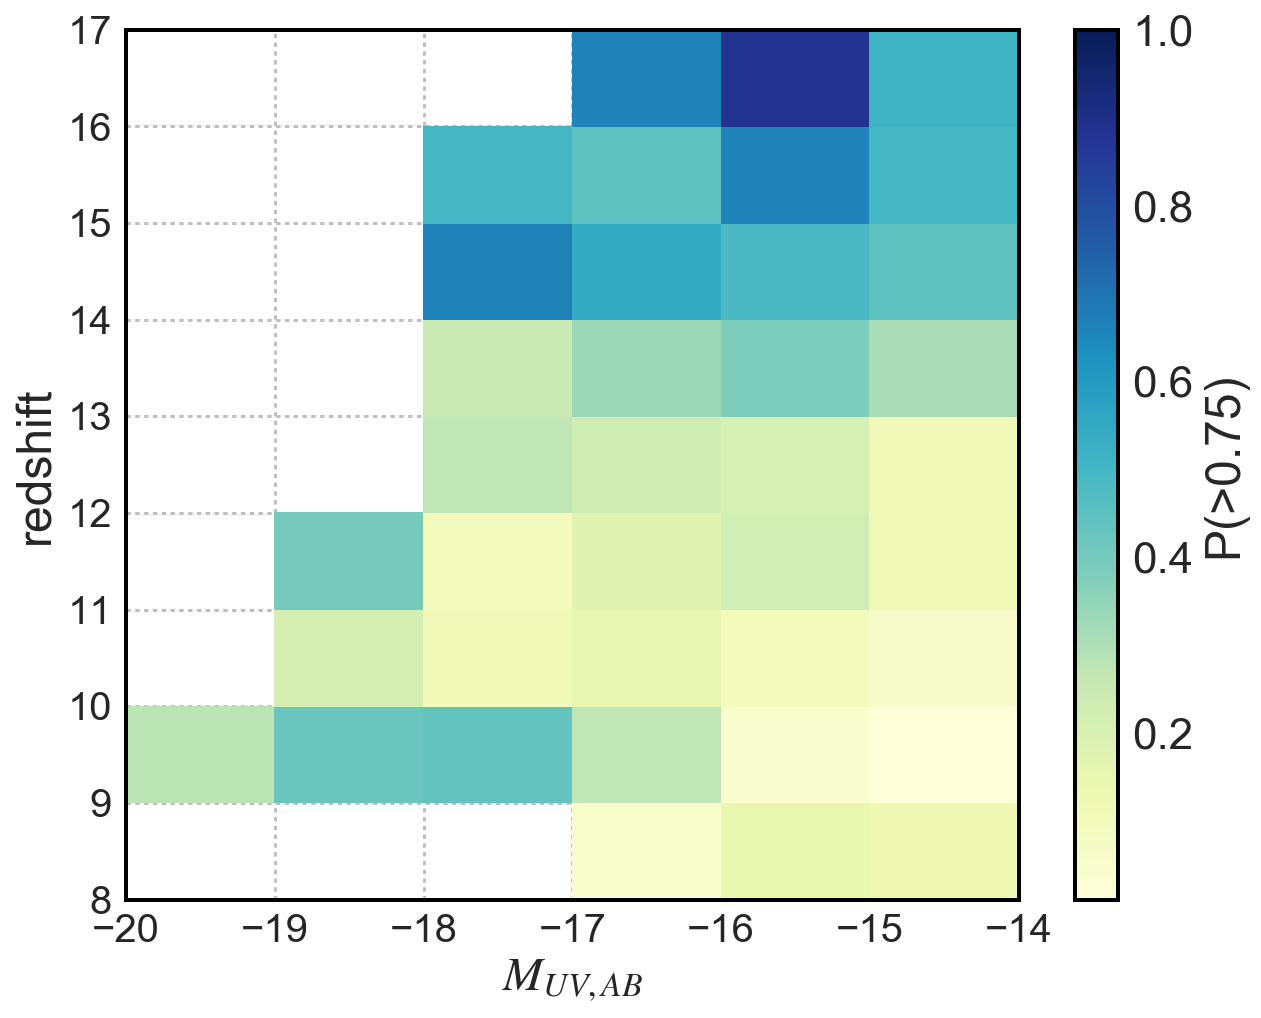

In [142]:
fig      = plt.figure(figsize=(10, 8))
ax       = plt.axes()

mat75m = np.ma.masked_where(mat75==0, mat75)

X, Y = np.meshgrid(magBins[:-1], range(7,17))  # Create a grid over the range of bins for the plot
X, Y = np.meshgrid(magBins[2:-1], range(7,17))  # Create a grid over the range of bins for the plot

print("min val = {}".format(mat75m.min()))

# im = (ax.pcolormesh(X, Y, m75m, cmap=mpl.cm.YlGnBu, vmin=-2.4, vmax=0) )
im = (ax.pcolormesh(X, Y, mat75m[:,2:], cmap=mpl.cm.YlGnBu, vmin=1e-2, vmax=1) )

ax.set_xlabel('$M_{UV,AB}$',fontsize=24)
# ax.set_xticks(magBins)
ax.set_ylabel('redshift',fontsize=24)
ax.set_yticklabels(zs+1)
ax.grid(which='major', axis='y', color='0.75', linestyle=':', linewidth=1.5)
ax.grid(which='both', axis='x', color='0.75', linestyle=':', linewidth=1.5)

# Create the colorbar
cbar = fig.colorbar(im)
cbar.ax.tick_params(labelsize=22) 
#cbar.ax.set_yticklabels(['1', '2', '4', '6', '10', maxCV], size=24)
cbar.set_label("P(>0.75)",fontsize=24)

plt.savefig("ProbvsRedshift.pdf",dpi=fig.dpi,bbox_inches='tight')


/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10


min val = 0.009433962264150938


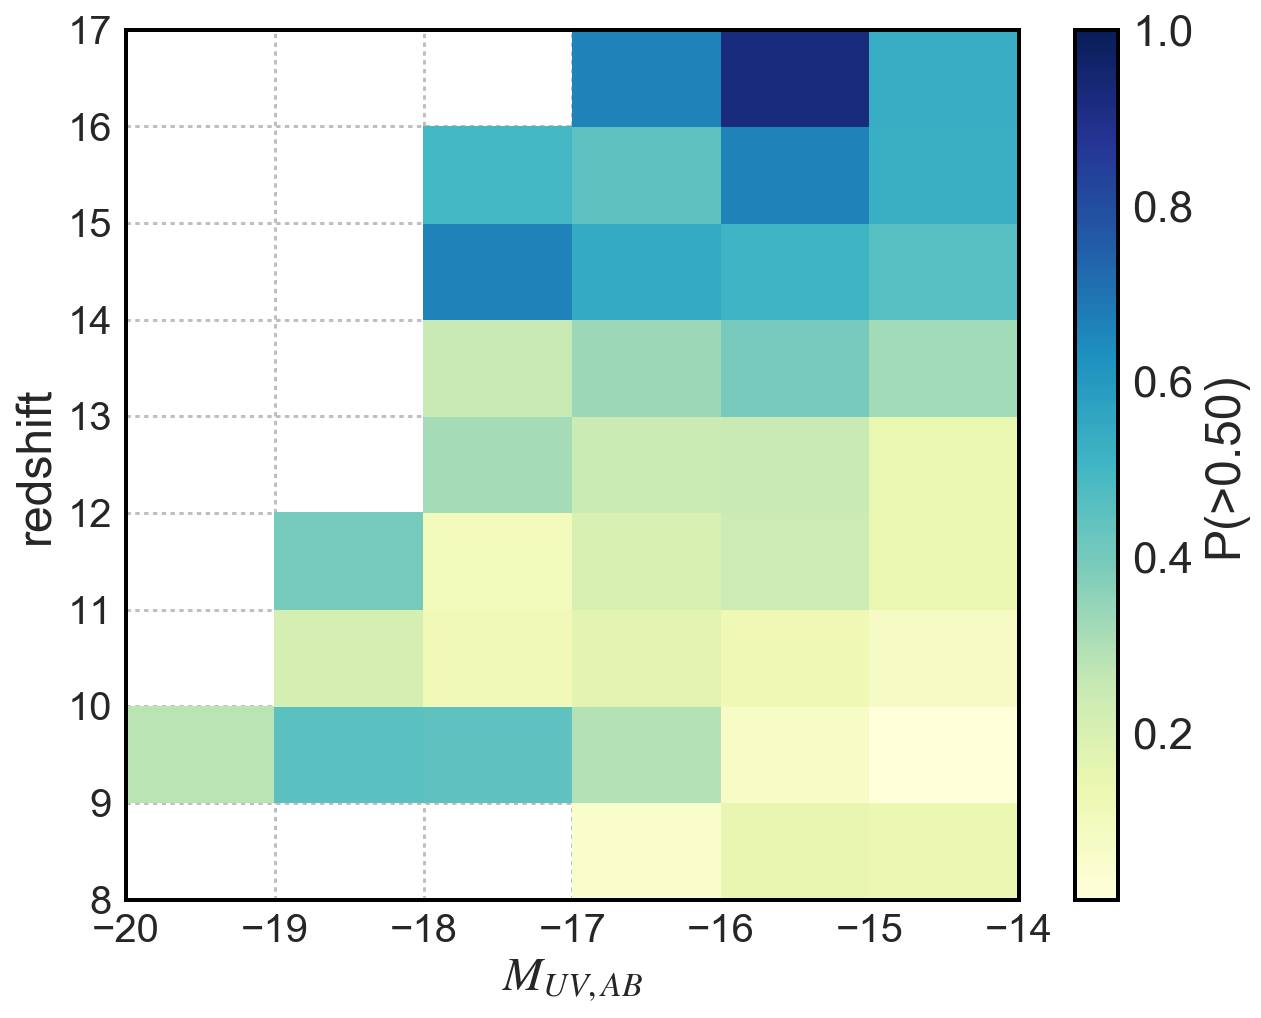

In [143]:
zs = np.arange(7,17)
fig      = plt.figure(figsize=(10, 8))
ax       = plt.axes()

mat50m = np.ma.masked_where(mat50==0, mat50)

m50m = np.log10(mat50m)
print("min val = {}".format(mat50m.min()))

X, Y = np.meshgrid(magBins[2:-1], range(7,17))  # Create a grid over the range of bins for the plot

# im = (ax.pcolormesh(X, Y, m50m, cmap=mpl.cm.YlGnBu, vmin=-2.3, vmax=0) )
im = (ax.pcolormesh(X, Y, mat50m[:,2:], cmap=mpl.cm.YlGnBu, vmin=1e-2, vmax=1) )

ax.set_xlabel('$M_{UV,AB}$',fontsize=24)
ax.set_ylabel('redshift',fontsize=24)
ax.set_yticklabels(zs+1)
ax.grid(which='major', axis='y', color='0.75', linestyle=':', linewidth=1.5)
ax.grid(which='both', axis='x', color='0.75', linestyle=':', linewidth=1.5)

# Create the colorbar
cbar = fig.colorbar(im)
cbar.ax.tick_params(labelsize=22) 
#cbar.ax.set_yticklabels(['1', '2', '4', '6', '10', maxCV], size=24)
cbar.set_label("P(>0.50)",fontsize=24)



In [ ]:
fig      = plt.figure(figsize=(10, 8))
ax       = plt.axes()

mat75m = np.ma.masked_where(mat75==0, mat75)

X, Y = np.meshgrid(magBins[:-1], range(7,17))  # Create a grid over the range of bins for the plot
X, Y = np.meshgrid(magBins[2:-1], range(7,17))  # Create a grid over the range of bins for the plot

m75m = np.log10(mat75m)
print("min val = {}".format(mat75m.min()))

# im = (ax.pcolormesh(X, Y, m75m, cmap=mpl.cm.YlGnBu, vmin=-2.4, vmax=0) )
im = (ax.pcolormesh(X, Y, mat75m[:,2:], cmap=mpl.cm.YlGnBu, vmin=1e-2, vmax=1) )

ax.set_xlabel('$M_{UV,AB}$',fontsize=24)
# ax.set_xticks(magBins)
ax.set_ylabel('redshift',fontsize=24)
ax.set_yticklabels(zs+1)
ax.grid(which='major', axis='y', color='0.75', linestyle=':', linewidth=1.5)
ax.grid(which='both', axis='x', color='0.75', linestyle=':', linewidth=1.5)

# Create the colorbar
cbar = fig.colorbar(im)
cbar.ax.tick_params(labelsize=22) 
#cbar.ax.set_yticklabels(['1', '2', '4', '6', '10', maxCV], size=24)
cbar.set_label("P(>0.75)",fontsize=24)

plt.savefig("ProbvsRedshift.pdf",dpi=fig.dpi,bbox_inches='tight')


z=8

\> 53%

['0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0017', '0.0122', '0.0137', '0.0116', '0.0166']

\> 73%

['0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0514', '0.1443', '0.1291', '0.0486', '0.0315', '0.0190']


Limiting absolute magnitude: -13
Convert to Abs Mag. DM = 47.20 @ z=8.0
Pop III flux fraction is 0.05545 at z=8
Number of galaxies 9199
Largest bin value: 0.000, smallest -2.8159096508867747


/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:52: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:53: RuntimeWarning: divide by zero encountered in log10


Convert to Abs Mag. DM = 47.38 @ z=9.0
Pop III flux fraction is 0.30985 at z=9
Number of galaxies 3831
Largest bin value: 0.000, smallest -2.9253120914996495
Convert to Abs Mag. DM = 47.54 @ z=10.0
Pop III flux fraction is 0.11879 at z=10
Number of galaxies 2667
Largest bin value: 0.000, smallest -2.8549130223078554
Convert to Abs Mag. DM = 47.68 @ z=11.0
Pop III flux fraction is 0.17830 at z=11
Number of galaxies 1943
Largest bin value: 0.000, smallest -2.6720978579357175
Convert to Abs Mag. DM = 47.80 @ z=12.0
Pop III flux fraction is 0.21308 at z=12
Number of galaxies 1365
Largest bin value: 0.000, smallest -2.534026106056135
Convert to Abs Mag. DM = 48.03 @ z=14.0
Pop III flux fraction is 0.44895 at z=14
Number of galaxies 531
Largest bin value: 0.000, smallest -2.130333768495006
Convert to Abs Mag. DM = 48.12 @ z=15.0
Pop III flux fraction is 0.51713 at z=15
Number of galaxies 294
Largest bin value: -0.176, smallest -1.8195439355418686
Convert to Abs Mag. DM = 48.21 @ z=16.0
Pop I

16499

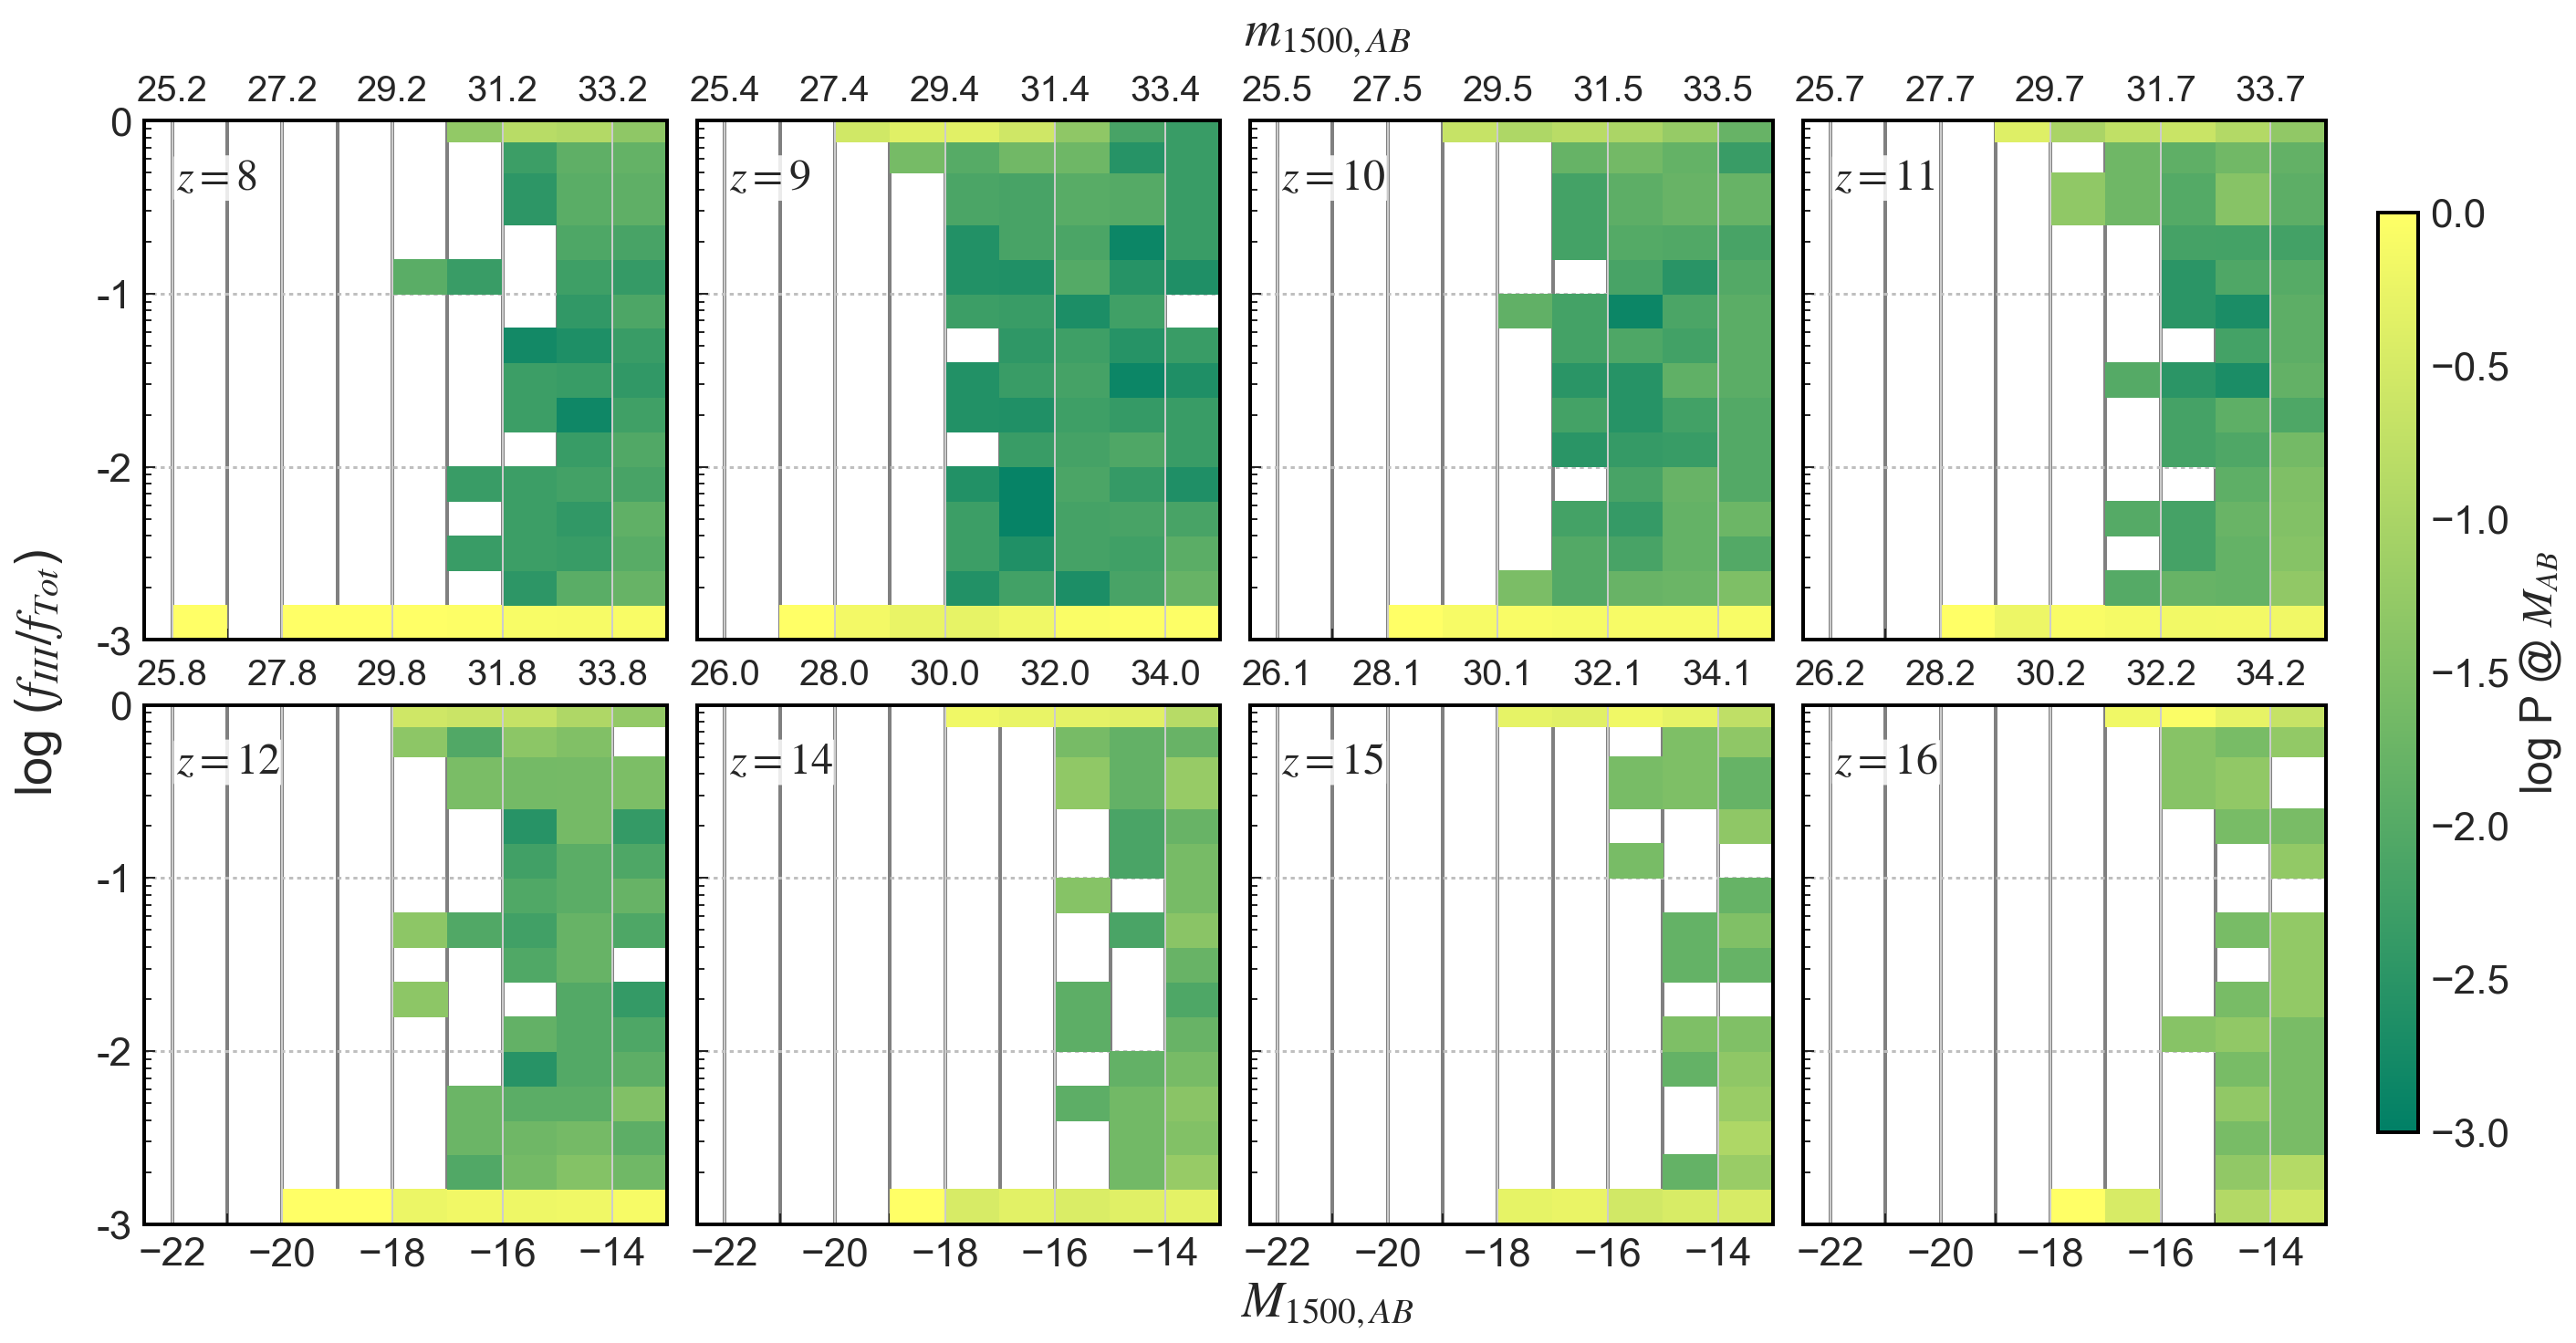

In [144]:
# Normalize the probability in each row such that it totals to 1.0

sns.set(style="whitegrid", font_scale=2, color_codes=True)
sns.set_style({'axes.edgecolor': '0.0','axes.linewidth': 2.0})

# Plot the fraction of Pop III magnitude vs M_AB NORMALIZED...

rgForSFunc = np.arange(brightM,limitM, 0.1)

brightM = -22
limitM  = brightM+9
magBins = np.linspace(brightM,limitM,(-brightM+limitM)*1 + 1) 
# Contrived bin spacing such that the top bin represents .75-1.0 Pop III fraction
# and the next bin down represents .5-0.75 ...
fracBins = [0.001,  0.00158489,  0.00251189,  0.00398107,  0.00630957,
             0.01,  0.01584893,  0.02511886,  0.03981072,  0.06309573,
             0.1,  0.15848932,  0.25118864,
             0.5,   0.75,   1.0]
print("Limiting absolute magnitude: {}".format(limitM))

fig, axs = plt.subplots(nrows=2, ncols=4, sharex='col',sharey='row',figsize=(20,10))
for z,ax in zip(np.sort([8,9,10,11,12,14,15,16]), axs.flat):

    # Convert observed magnitude to Absolute ...
    absMag, pop3Mag, nmAbsMag   = compMags(z)
    # Map 0 Pop 3 flux to 1e-3... 
    pop3Fraction                      = fluxes[z]['1500A_P3']/fluxes[z]['1500A']
    print("Pop III flux fraction is {:.5f} at z={}".format(fluxes[z]['1500A_P3'].sum()/fluxes[z]['1500A'].sum(),z))
    pop3Fraction[pop3Fraction < 1e-3] = 1e-3  # Map Pop 3 flux < 1e-3 to 1e-3
    

    
    Ng = len(absMag) # Number of galaxies at this z
    print("Number of galaxies {}".format(Ng))
    # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
    # both the improved Pop III luminosity and the classical

    # Note that we are reversing x,y here since pcolormesh interprets them backwards!
    nTempA, binsx, binsy = np.histogram2d(pop3Fraction,absMag,bins=[fracBins,magBins],normed=False)
    # could use weights=[1/simVol for i in absMag] to normalize by vol here... 
    # normed : bool, optional
    #        If False, returns the number of samples in each bin. If True, returns the bin density 
    #        bin_count / sample_count / bin_area.

    X, Y = np.meshgrid(magBins, fracBins)  # Create a grid over the range of bins for the plot

    # Mask out 0 values before taking log10... 
    H = np.ma.masked_where(nTempA==0.0, nTempA)
    for i in range(len(H[0,:])):     # Column index i, over len of row 0
        colTot = np.sum(H[:,i])
        for j in range(len(H[:,0])): # Row index j, over len of column 0
            H[:,i][j] = H[:,i][j]/colTot
    H = np.log10(H)        # Take log of counts, we've already normalized by volume and area
    print("Largest bin value: {:.3f}, smallest {}".format(H.max(),H.min()))
    # Create the plot
    im = (ax.pcolormesh(X, Y, H, cmap=mpl.cm.summer, vmin=-3, vmax=0) )
    
    ax.set_xscale('linear')
    ax.set_yscale('log')
    ax.yaxis.set_tick_params(which='major',width=1,length=6)
    ax.yaxis.set_tick_params(which='minor',width=1,length=4)
    ax.xaxis.set_tick_params(which='both',width=1,length=6)
    ax.xaxis.set_ticks(np.arange(brightM,limitM+1, 2))
    minorLocator = ticker.MultipleLocator(1)
    ax.xaxis.set_minor_locator(minorLocator)
    ax.get_yaxis().set_tick_params(which='both', direction='in',labelsize=22)
    ax.get_xaxis().set_tick_params(which='both', direction='in',labelsize=22)
    ax.yaxis.set_major_formatter(logfmt)
    ax.set_xlim([brightM-0.5,limitM])
#     ax.set_ylim([9e-4,1.05])
    ax.grid(which='major', axis='y', color='0.75', linestyle=':', linewidth=1.5)
    ax.grid(which='both', axis='x', color='0.5', linestyle='-', linewidth=2.0)

    # Top x-axis labels ... m_ab
    ax2 = ax.twiny()
    ax2.set_xlim([brightM-0.5,limitM]) # required...
    axXtics = ax.get_xticks()
    ax2.set_xticks(axXtics)   # Set the location of the tics same as for ax
    ax2Xs = getMag(axXtics,z) # Convert M_ab -> m_ab
    ax2.set_xticklabels(["{:.1f}".format(i) for i in ax2Xs])
    ax2.get_xaxis().set_tick_params(labelsize=20)

    # plt.gca().invert_xaxis()
    gc.collect()
    
    ax.annotate('$z={}$'.format(z), xy = (0.5, 0.5), xytext = (0.06, 0.85), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.85},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=24)

plt.subplots_adjust(left=0.05, bottom=0.08, right=.88, top=0.92, wspace=.057, hspace=.125)

fig.text(0.5, 0.977,'$m_{1500,AB}$', ha='center',size=28 )
fig.text(0.5, 0.01,'$M_{1500,AB}$', ha='center',size=28 )
fig.text(0.00, 0.5, r'log ($f_{III}/f_{Tot}$)',size=28,va='center', rotation='vertical')

# Create the colorbar
cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)

cbar.ax.tick_params(labelsize=22) 
#cbar.ax.set_yticklabels(['1', '2', '4', '6', '10', maxCV], size=24)
cbar.set_label("log P @ $M_{AB}$",fontsize=24)
#plt.savefig("PopIII_fraction_{}-Histograms-all.pdf".format(z),dpi=fig.dpi,bbox_inches='tight')

gc.collect()

### Build tables showing f_III/f_tot = f(z,M_AB)

In [76]:
# Normalize the probability in each row such that it totals to 1.0

brightM = 25
limitM  = 37
rgForSFunc = np.arange(brightM,limitM, 0.1)

magBins = np.linspace(brightM,limitM,(-brightM+limitM)*1 + 1) 
fracBins = np.logspace(-3,0,23)
# Contrived bin spacing such that the top bin represents .75-1.0 Pop III fraction
# and the next bin down represents .5-0.75 ...
fracBins = [0.001,  0.00158489,  0.00251189,  0.00398107,  0.00630957,
             0.01,  0.01584893,  0.02511886,  0.03981072,  0.06309573,
             0.1,  0.15848932,  0.25118864,
             0.5,   0.75,   1.0]
print(["{}".format(i) for i in magBins])

headers = np.concatenate(([['z'],magBins[1:]]))
dfom75 = pd.DataFrame( columns=headers)
dfom50 = pd.DataFrame( columns=headers)

matom75 = np.array([])
matom50 = np.array([])
ii = 0;
for z in np.sort([8,9,10,11,12,13,14,15,16]):

    # Convert flux to m ...
    mags = mag(fluxes[z]['1500A'])
    # Map 0 Pop 3 flux to 1e-3... 
    pop3Fraction                      = fluxes[z]['1500A_P3']/fluxes[z]['1500A']
    pop3Fraction[pop3Fraction < 1e-3] = 1e-3  # Map Pop 3 flux < 1e-3 to 1e-3
    
    Ng = len(mags) # Number of galaxies at this z
    # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
    # both the improved Pop III luminosity and the classical

    # Note that we are reversing x,y here since pcolormesh interprets them backwards!
    nTempA, binsx, binsy = np.histogram2d(pop3Fraction,mags,bins=[fracBins,magBins],normed=False)
    # could use weights=[1/simVol for i in mags] to normalize by vol here... 
    # normed : bool, optional
    #        If False, returns the number of samples in each bin. If True, returns the bin density 
    #        bin_count / sample_count / bin_area.


    # Mask out 0 values before taking log10... 
    H = np.ma.masked_where(nTempA==0.0, nTempA)
#     H = np.ma.masked_where(nTempA<=1.0, nTempA)
    if z==15:
        print("counts",H[-1,:])
        print("counts\n",H)
    for i in range(len(H[0,:])):     # Column index i, over len of row 0
        colTot = np.sum(H[:,i])
        for j in range(len(H[:,0])): # Row index j, over len of column 0
            H[:,i][j] = H[:,i][j]/colTot  ## IF colTot == 1 or 2, we likely have very bad statistics **************
    # Create arrays where fraction is greater than 50% and 75% ... 
    # REMEMBER: have to add the 75% bin to the 50% if we want combined P(>.50)
#     H = np.ma.filled(H, fill_value=0.0)
    if z==15:
        print("prob",H[-1,:])
    #########################################################################
    ##### Extract the "top two" rows ... these are bins 50% and 75% #########
    ##### if you change fracBins this changes!!!! ***************************
    #########################################################################
    gtom50 = H[-2,:]
    gtom75 = H[-1,:]
#     print("z={}, H (> 75%): \n{}".format(z,["{:.4f}".format(x) for x in gtom75]))
    dfom75.loc[ii] = np.concatenate(([z],gtom75))
    dfom50.loc[ii] = np.concatenate(([z],gtom50+gtom75)) ## Sum the fraction > .75 and .50 < frac < .75
    if z == 8: # first one
#         print(gtom75)
        # Build a new matrix with P3 frac vs M_AB 
        matom75 = np.append(matom75,gtom75)
        matom50 = np.append(matom50,gtom50+gtom75)
    else:
        matom75 = np.vstack((matom75,gtom75)) # A matrix (for plotting) of the table
        matom50 = np.vstack((matom50,gtom50+gtom75)) # a matrix of the table... 
    ii += 1
gc.collect()
# df75.index = range(8,16)
# df50.index = range(8,16)
print("> 75 and 50% respectively")
print (dfom75.to_string(index=False))
print (dfom50.to_string(index=False))


['25.0', '26.0', '27.0', '28.0', '29.0', '30.0', '31.0', '32.0', '33.0', '34.0', '35.0', '36.0', '37.0']


/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:53: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


counts [-- -- -- -- -- 1.0 4.0 23.0 33.0 12.0 14.0 5.0]
counts
 [[-- -- -- -- -- -- 5.0 9.0 26.0 19.0 17.0 1.0]
 [-- -- -- -- -- -- -- -- -- 5.0 4.0 1.0]
 [-- -- -- -- -- -- -- -- -- 5.0 3.0 3.0]
 [-- -- -- -- -- -- -- -- -- 3.0 4.0 3.0]
 [-- -- -- -- -- -- -- -- 1.0 2.0 3.0 3.0]
 [-- -- -- -- -- -- -- -- 2.0 2.0 2.0 5.0]
 [-- -- -- -- -- -- -- -- -- -- 1.0 --]
 [-- -- -- -- -- -- -- -- 1.0 1.0 2.0 1.0]
 [-- -- -- -- -- -- -- -- 1.0 2.0 1.0 --]
 [-- -- -- -- -- -- -- -- -- 1.0 1.0 --]
 [-- -- -- -- -- -- -- 1.0 -- -- -- 2.0]
 [-- -- -- -- -- -- -- -- -- 3.0 -- 1.0]
 [-- -- -- -- -- -- -- 1.0 2.0 1.0 4.0 3.0]
 [-- -- -- -- -- -- -- -- 2.0 3.0 2.0 --]
 [-- -- -- -- -- 1.0 4.0 23.0 33.0 12.0 14.0 5.0]]
prob [-- -- -- -- -- 1.0 0.4444444444444444 0.6764705882352942
 0.4852941176470588 0.2033898305084746 0.2413793103448276
 0.17857142857142858]
> 75 and 50% respectively
z  26.0  27.0      28.0      29.0      30.0      31.0      32.0      33.0      34.0      35.0      36.0      37.0
 8.0   0

In [77]:
H[-2,:],H[-1,:],magBins

(masked_array(data = [-- -- -- -- -- -- -- -- 0.027777777777777776 0.06521739130434782 --
  0.13636363636363635],
              mask = [ True  True  True  True  True  True  True  True False False  True False],
        fill_value = 1e+20),
 masked_array(data = [-- -- -- -- -- -- 0.5 0.9444444444444444 0.6111111111111112
  0.2608695652173913 0.17391304347826086 0.09090909090909091],
              mask = [ True  True  True  True  True  True False False False False False False],
        fill_value = 1e+20),
 array([ 25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
         36.,  37.]))

In [78]:
z15mags=mag(fluxes[15]['1500A']) ### Check out that 100% at z=15, m=31
pop3Fraction                      = fluxes[15]['1500A_P3']/fluxes[15]['1500A']
pop3Fraction[pop3Fraction < 1e-3] = 1e-3  # Map Pop 3 flux < 1e-3 to 1e-3
print("mags",z15mags[(z15mags<31.5)&(z15mags>30.5)])
print("ff",pop3Fraction[(z15mags<31.5)&(z15mags>30.5)])

mags [ 31.10186028  31.14134594  31.25109146  31.31946074  30.90267033
  31.4682204   31.42793398]
ff [ 0.001       0.001       0.001       0.001       0.97216951  1.          0.9967166 ]


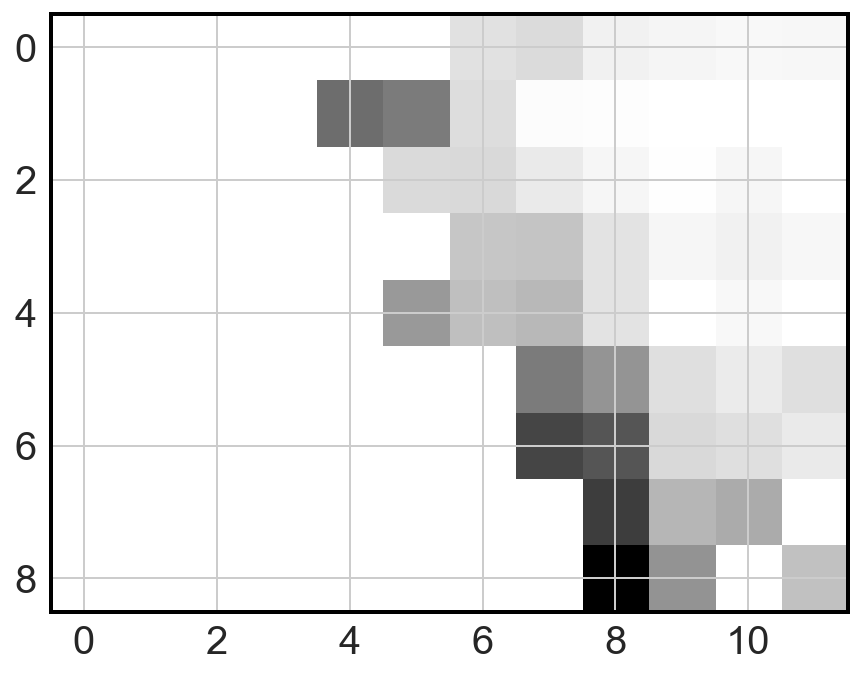

In [63]:
cm = sns.light_palette("green", as_cmap=True)
plt.imshow(matom50)
s2 = dfom75.style.background_gradient(cmap=cm)
s2.set_caption('$m_{UV,AB}$')

In [64]:
#dfom50.style.set_caption('$m_{UV,AB}$').background_gradient(cmap=cm)
dfom50.style.background_gradient(cmap=cm)

In [24]:
len(magBins[:-1]),len(mom75m[:,0]),len(mom75m[0,:])

NameError: name 'mom75m' is not defined

In [54]:
zs = np.arange(7,17)

fig      = plt.figure(figsize=(10, 8))
ax       = plt.axes()

matom75m = np.ma.masked_where(matom75==0, matom75)

X, Y = np.meshgrid(magBins[2:-3], zs)  # Create a grid over the range of bins for the plot

# mom75m = np.log10(matom75m)
print("max val = {}".format(matom75m.max()))
print("min val = {}".format(matom75m.min()))

# im = (ax.pcolormesh(X, Y, m75m, cmap=mpl.cm.YlGnBu, vmin=-2.4, vmax=0) )
im = (ax.pcolormesh(X, Y, matom75m[:,2:-3], cmap=mpl.cm.YlGnBu, vmin=2e-3, vmax=1) )

ax.set_xlabel('$m_{UV,AB}$',fontsize=24)
# ax.set_xticks(magBins)
ax.set_ylabel('redshift',fontsize=24)
ax.set_yticklabels(zs+1)
ax.grid(which='major', axis='y', color='0.75', linestyle=':', linewidth=1.5)
ax.grid(which='both', axis='x', color='0.75', linestyle=':', linewidth=1.5)

# Create the colorbar
cbar = fig.colorbar(im)
cbar.ax.tick_params(labelsize=22) 
#cbar.ax.set_yticklabels(['1', '2', '4', '6', '10', maxCV], size=24)
cbar.set_label("P(>0.75)",fontsize=24)

plt.savefig("ProbvsRedshiftObsMag.pdf",dpi=fig.dpi,bbox_inches='tight')


max val = 1.0
min val = 0.003795066413662239


In [158]:
mom75m[:,4:]

masked_array(data =
 [[-- -- -2.682145076373832 -1.9088678258509035 -1.8066175503250896 -1.8370752510408843 -1.756192206422384
  -1.7898370087088382]
 [-1.8789046024734604 -1.9388948175981704 -1.5590775548220595 -2.0601580087341946 -2.423245873936808 -- -- --]
 [-- -2.173186268412274 -1.5902071645329623 -1.6925531793391444 -2.2840545584360687 -2.5010592622177517
  -1.9319661147281726 --]
 [-- -- -1.6989700043360187 -1.8796692056320534 -1.5893480258118247 -1.9375178920173466 -1.919078092376074
  -1.7481880270062005]
 [-- -1.5440680443502757 -1.8228216453031045 -1.3089573640660823 -1.6478174818886375 -- -2.0293837776852097 --]
 [-- -- -- -2.143014800254095 -1.8409420802430991 -1.649334858712142 -1.348953547981164 -1.1583624920952496]
 [-- -- -- -1.5910646070264993 -1.8325089127062364 -1.7745169657285496 -1.3710678622717363 -1.1249387366083]
 [-- -- -- -- -1.5314789170422551 -1.2937307569224816 -1.462397997898956 --]
 [-- -- -- -- -1.5563025007672873 -1.1856365769619117 -- -0.865301426102

In [21]:
fluxes[10].dtype.names

('halo',
 'r_v',
 'ZZsun',
 'ZPZsun',
 'MstarMsun',
 'M3StarMsun',
 'M3YngMsun',
 '1500A',
 '1500A_P3',
 '1500A_NM',
 '1500A_P3NM',
 '1500A_10pc',
 '1500A_P3_10pc')